# Recomendador de Peliculas

## Nota:

No se recomienda correr todo el notebook de un solo comando. Esto ya que se hicieron pruebas en los modelos de K-Means para verificar las gráficas de codo y de silueta, pero tardan demasiado y para el modelo final ya no es necesario correrlas.

Antes de cada una de las celdas que se recomienda evitar se incluye una celda color rojo.

In [39]:
import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
import seaborn as sns   
import json
import os
import shutil

### Importamos lo scripts locales
import sys
sys.path.insert(1, '../scripts') #auxiliar para leer los scripts

import eda
import modelos as md

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
### Cargamos los csv originales
credits = pd.read_csv('../movies-metadata/credits_original.csv')
keywords = pd.read_csv('../movies-metadata/keywords_original.csv')
links = pd.read_csv('../movies-metadata/links.csv')
ratings = pd.read_csv('../movies-metadata/ratings.csv')

In [41]:
### Ajustes
links = links.dropna()
links['tmdbId'] = links['tmdbId'].apply(lambda x : int(x)) 

In [42]:
### En la base original, hay renglones problematicos que mejor evadimos
rows_to_remove = [19730, 19731, 29503, 29504, 35587, 35588]
movies_metadata = pd.read_csv('../movies-metadata/movies_metadata_original.csv', skiprows = rows_to_remove)

In [43]:
### Nos aseguramos de quitarlas en los demás DF (los índices se buscaron dentro del Excel)
credits.drop(credits[credits['id'].apply(lambda x : x in [82663, 122662, 249260])].index, inplace = True)
keywords.drop(keywords[keywords['id'].apply(lambda x : x in [82663, 122662, 249260])].index, inplace = True)
links.drop(links[links['tmdbId'].apply(lambda x : x in [82663, 122662, 249260])].index, inplace = True)

In [44]:
### Quitamos duplicados
credits = credits.drop_duplicates()
keywords = keywords.drop_duplicates()
links = links.drop_duplicates()
ratings = ratings.drop_duplicates()
movies_metadata = movies_metadata.drop_duplicates()

In [45]:
### Reseteamos índices
credits = credits.reset_index(drop = True)
keywords = keywords.reset_index(drop = True)
links = links.reset_index(drop = True)
ratings = ratings.reset_index(drop = True)
movies_metadata = movies_metadata.reset_index(drop = True)

In [46]:
### Cargamos (o creamos) DataFrames derivados de los originales para facilitar el manejo de los datos
credits_cast = eda.concat_df(credits, 'cast', '../movies-metadata/credits_cast.csv')
credits_crew = eda.concat_df(credits, 'crew', '../movies-metadata/credits_crew.csv')
movies_metadata_production_countries = eda.concat_df(movies_metadata, 'production_countries', '../movies-metadata/movies_metadata_production_countries.csv')
movies_metadata_production_companies = eda.concat_df(movies_metadata, 'production_companies', '../movies-metadata/movies_metadata_production_companies.csv')
movies_metadata_spoken_languages = eda.concat_df(movies_metadata, 'spoken_languages', '../movies-metadata/movies_metadata_spoken_languages.csv')
movies_metadata_genres = eda.concat_df(movies_metadata, 'genres', '../movies-metadata/movies_metadata_genres.csv')
keywords_keywords = eda.concat_df(keywords, 'keywords', '../movies-metadata/keywords_keywords.csv')

In [47]:
### Algunas modificaciones
credits_cast['id'] = credits_cast['id'].apply(lambda x : int(x))
credits_crew['id'] = credits_crew['id'].apply(lambda x : int(x))

In [48]:
### Unimos para tener el id de las películas unificado
if 'id_credits' not in credits_cast.columns:
    credits_cast = credits_cast.join(credits, on = 'parent_id', rsuffix = '_credits', how = 'inner').drop(['crew', 'cast'], 1)
    credits_cast.to_csv('../movies-metadata/credits_cast.csv')
    
if 'id_credits' not in credits_crew.columns:
    credits_crew = credits_crew.join(credits, on = 'parent_id', rsuffix = '_credits', how = 'inner').drop(['crew', 'cast'], 1)
    credits_crew.to_csv('../movies-metadata/credits_crew.csv')

## Idea #1 : Clustering

Nos gustaria agrupar a las peliculas segun  su semejanza. Esto lo podemos hacer por medio de algoritmos de clustering, como K-Means o Hierarchical Clustering. Podemos ocupar variables como lenguajes, genero, duracion, costo de la pelicula, etc. para agrupar.

### Modificacion de variables

#### Lenguajes

Observamos que la variable **iso_639_1**, que son los codigos para identificar a los principales idiomas del mundo (https://es.wikipedia.org/wiki/ISO_639-1) no tienen NA, mientras que la variable **name** sí tiene, por lo que mejor ocuparemos la primera.

In [49]:
print("Total de NA en la variable iso_639_1: " + str(movies_metadata_spoken_languages['iso_639_1'].isna().sum()))
print("Total de NA en la variable name: " + str(movies_metadata_spoken_languages['name'].isna().sum()))

Total de NA en la variable iso_639_1: 0
Total de NA en la variable name: 498


In [50]:
print("Valores mas comunes de iso_639_1: ")
print(movies_metadata_spoken_languages.groupby('iso_639_1').count().sort_values(
    'parent_id', ascending = False).head().index.tolist())

print("\nValores mas comunes de name: ")
print(movies_metadata_spoken_languages.groupby('name').count().sort_values(
    'parent_id', ascending = False).head().index.tolist())

Valores mas comunes de iso_639_1: 
['en', 'fr', 'de', 'es', 'it']

Valores mas comunes de name: 
['English', 'Français', 'Deutsch', 'Español', 'Italiano']


Unimos los lenguajes por pelicula, tal que se agregue un nuevo renglon por cada combinacion:

In [51]:
languages = movies_metadata_spoken_languages.join(movies_metadata, rsuffix = '_credits', on = 'parent_id', how = 'inner')

languages = languages[['id', 'original_title', 'iso_639_1']]

languages.head()

,id,original_title,iso_639_1
0,862,Toy Story,en
1,8844,Jumanji,en
2,8844,Jumanji,fr
3,15602,Grumpier Old Men,en
4,31357,Waiting to Exhale,en


No obstante, lo que nos servirá será crear variables dummy por cada lenguaje:

In [52]:
languages = languages.pivot_table(columns = 'iso_639_1', values='original_title', index = 'id', aggfunc = lambda x : 1).fillna(0)

languages

iso_639_1,ab,af,am,ar,as,ay,az,be,bg,bi,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finalmente, verificamos si hay registros con el mismo id

In [53]:
print(f'Hay un total de : {len(languages.index.tolist()) - len(set(languages.index.tolist()))} registros con mismo id')

Hay un total de : 0 registros con mismo id


#### Generos

Observamos que la variable que contiene al genero, **name**, no es vacia, por lo que podemos ocupar todos los valores:

In [54]:
print("Total de NA en la variable name: " + str(movies_metadata_genres['name'].isna().sum()))

Total de NA en la variable name: 0


In [55]:
print("\nValores mas comunes de name: ")
print(movies_metadata_genres.groupby('name').count().sort_values(
    'parent_id', ascending = False).head().index.tolist())


Valores mas comunes de name: 
['Drama', 'Comedy', 'Thriller', 'Romance', 'Action']


Unimos los lenguajes por pelicula, tal que se agregue un nuevo renglon por cada combinacion:

In [56]:
genres = movies_metadata_genres.join(movies_metadata, rsuffix = '_meta', on = 'parent_id', how = 'inner')

genres = genres[['id_meta', 'original_title', 'name']]
genres.columns = ['id', 'original_title', 'name']

genres.head()

,id,original_title,name
0,862,Toy Story,Animation
1,862,Toy Story,Comedy
2,862,Toy Story,Family
3,8844,Jumanji,Adventure
4,8844,Jumanji,Fantasy


No obstante, lo que nos servirá será crear variables dummy por cada lenguaje:

In [57]:
genres = genres.pivot_table(columns = 'name', values='original_title', index = 'id', aggfunc = lambda x : 1).fillna(0)

genres

name,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465044,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467731,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468343,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Finalmente, verificamos si hay registros con el mismo id

In [58]:
print(f'Hay un total de : {len(genres.index.tolist()) - len(set(genres.index.tolist()))} registros con mismo id')

Hay un total de : 0 registros con mismo id


#### Otras variables (no incluidas)

Algunas de las otras variables que podriamos considerar son actores, escritores, directores, etc. El problema es que la dimension que estas añadirian al dataframe lo haría casi inviable. La razon es que, a diferencia de leguajes o géneros, estas se extienden en el orden de los miles:

In [59]:
aux = pd.DataFrame(credits_cast.groupby(['id', 'name']).count()['cast_id'])
aux.columns = ['n']
print(f'Cantidad de actores diferentes: {aux.shape[0]}')
aux.head(5)

Cantidad de actores diferentes: 206160


,,n
id,name,
1,George Lucas,20
2,Mark Hamill,47
3,Harrison Ford,57
4,Carrie Fisher,46
5,Peter Cushing,69


In [60]:
aux = pd.DataFrame(credits_crew[credits_crew['job'] == 'Director'].groupby(['id', 'name']).count()['credit_id'])
aux.columns = ['n']
print(f'Cantidad de directores diferentes: {aux.shape[0]}')
aux.head(5)

Cantidad de directores diferentes: 19894


,,n
id,name,
1,George Lucas,7
2,Mark Hamill,1
7,Andrew Stanton,4
8,Lee Unkrich,1
13,Albert Brooks,7


In [61]:
aux = pd.DataFrame(credits_crew[credits_crew['job'] == 'Producer'].groupby(['id', 'name']).count()['credit_id'])
aux.columns = ['n']
print(f'Cantidad de productores diferentes: {aux.shape[0]}')
aux.head(5)

Cantidad de productores diferentes: 20175


,,n
id,name,
1,George Lucas,2
9,Graham Walters,1
24,Robert Zemeckis,17
28,Wendy Finerman,9
29,Steve Tisch,17


In [62]:
aux = pd.DataFrame(movies_metadata_production_companies.groupby(['id', 'name']).count()['parent_id'])
aux.columns = ['n']
print(f'Cantidad de compañias de produccion diferentes: {aux.shape[0]}')
aux.head(5)

Cantidad de compañias de produccion diferentes: 23692


,,n
id,name,
1.0,Lucasfilm,29
2.0,Walt Disney Pictures,263
3.0,Pixar Animation Studios,52
4.0,Paramount Pictures,1003
5.0,Columbia Pictures,431


In [63]:
aux = pd.DataFrame(movies_metadata_production_countries.groupby(['iso_3166_1', 'name']).count()['parent_id'])
aux.columns = ['n']
print(f'Cantidad de paises diferentes: {aux.shape[0]}')
aux.head(5)

Cantidad de paises diferentes: 160


,,n
iso_3166_1,name,
AE,United Arab Emirates,27
AF,Afghanistan,8
AL,Albania,5
AM,Armenia,8
AN,Netherlands Antilles,1


#### Juntar en dataframes

Previo a juntar dataframes, observamos que hay algunos valores con id repetidos:

In [64]:
aux = movies_metadata.set_index('id')
print(f'Hay un total de : {len(aux.index.tolist()) - len(set(aux.index.tolist()))} registros con mismo id')

Hay un total de : 13 registros con mismo id


In [65]:
movies_metadata.groupby('id').count().sort_values('original_title', ascending = False)['original_title'].head(10)

id
77221     2
69234     2
10991     2
14788     2
110428    2
22649     2
132641    2
109962    2
13209     2
15028     2
Name: original_title, dtype: int64

Viendo solo algunos, parece que en efecto solo son repetidos y no son errores de inputs como tal. Por ello, nuetsro criterio será simplemente quitar todos los repetidos excepto los primeros.

In [66]:
pre_clusters = movies_metadata.copy().drop_duplicates(subset = 'id', keep = 'first')

In [67]:
movies_metadata[movies_metadata['id'] == 141971]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
13258,False,NaN,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",NaN,141971,tt1180333,fi,Blackout,Recovering from a nail gun shot to the head an...,...,2008-12-26,0,108.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}]",Released,Which one is the first to return - memory or t...,Blackout,False,6.7,3


In [68]:
movies_metadata[movies_metadata['id'] == 13209]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
11339,False,NaN,2500,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,13209,tt0499537,fa,Offside,"Since women are banned from soccer matches, Ir...",...,2006-05-26,0,93.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,NaN,Offside,False,6.7,27
15761,False,NaN,2500,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,13209,tt0499537,fa,Offside,"Since women are banned from soccer matches, Ir...",...,2006-05-26,0,93.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,NaN,Offside,False,6.7,27


Juntamos las variables importantes en un solo dataframe, y normalizamos las numericas.

In [69]:
from sklearn import preprocessing

In [70]:
meta_cat = ['budget', 'popularity', 'revenue', 'runtime']

pre_clusters = pre_clusters[['id'] + meta_cat]
pre_clusters = pre_clusters.dropna()
pre_clusters.set_index('id', inplace = True)

### Convertimos a log
pre_clusters.loc[:,'budget'] = np.log(pre_clusters.loc[:,'budget'].astype(float) + 1)
pre_clusters.loc[:,'popularity'] = np.log(pre_clusters.loc[:,'popularity'].astype(float) + 1)
pre_clusters.loc[:,'revenue'] = np.log(pre_clusters.loc[:,'revenue'].astype(float) + 1)
pre_clusters.loc[:,'runtime'] = np.log(pre_clusters.loc[:,'runtime'].astype(float) + 1)

### Normalizamos 0-1
def norm_0_1(x) : return (x - x.min())/(x.max() - x.min())
pre_clusters.loc[:,'budget'] = norm_0_1(pre_clusters.loc[:,'budget'])
pre_clusters.loc[:,'popularity'] = norm_0_1(pre_clusters.loc[:,'popularity'])
pre_clusters.loc[:,'revenue'] = norm_0_1(pre_clusters.loc[:,'revenue'])
pre_clusters.loc[:,'runtime'] = norm_0_1(pre_clusters.loc[:,'runtime'])

### Normalizamos (suma de cuadrdos por renglon = 1)
# preprocessing.normalize(pre_clusters)

# pre_clusters.head()

In [71]:
pre_clusters = pre_clusters.join(genres).join(languages)
pre_clusters = pre_clusters.dropna()

pre_clusters.head()

,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
id,,,,,,,,,,,,,,,,,,,,,
862,0.871481,0.496766,0.907580,0.617492,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8844,0.910619,0.458405,0.891410,0.652136,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15602,0.000000,0.403131,0.000000,0.648075,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31357,0.839662,0.250657,0.837550,0.679891,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11862,0.000000,0.355053,0.834714,0.654780,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Antes de seguir, notamos que quiza son muchas columnas. Quitamos algunas. Aqui quien sabe si convenga entonces quitar todos los renglones que ya no contengan un 1 en las columnas de las categoricas que limpiamos, aunque al mismo tiempo, podria considerarse como la "otra" categoria.

In [72]:
genres_cat = sorted(movies_metadata_genres['name'].unique().tolist())
languages_cat = sorted(movies_metadata_spoken_languages.groupby('iso_639_1').count().sort_values('name', ascending = False).head(20).index.tolist())

pre_clusters[meta_cat + genres_cat + languages_cat]

pre_clusters.head(5)

,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
id,,,,,,,,,,,,,,,,,,,,,
862,0.871481,0.496766,0.907580,0.617492,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8844,0.910619,0.458405,0.891410,0.652136,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15602,0.000000,0.403131,0.000000,0.648075,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31357,0.839662,0.250657,0.837550,0.679891,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11862,0.000000,0.355053,0.834714,0.654780,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Recuperamos el nombre de la pelicula en otro dataframe para ocuparlo posteriormente. Si bien nos gustaria ocupar el nombre como id, hay casos de nombres repetidos, por lo que no es posible hacer esto.

In [73]:
print('Algunas peliculas con nombres repetidos:')
movies_metadata.groupby('original_title').count().sort_values('id', ascending = False)['id'].head(10)

Algunas peliculas con nombres repetidos:


original_title
Hamlet                  8
Alice in Wonderland     8
Macbeth                 7
The Three Musketeers    7
Les Misérables          7
Cinderella              7
A Christmas Carol       7
Jane Eyre               6
Frankenstein            6
Wuthering Heights       6
Name: id, dtype: int64

In [74]:
movie_pre_cluster = movies_metadata[['id', 'original_title']].drop_duplicates(subset = 'id', keep = 'first').set_index('id').join(pre_clusters, how = 'inner')

movie_pre_cluster.head(5)

,original_title,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
id,,,,,,,,,,,,,,,,,,,,,
862,Toy Story,0.871481,0.496766,0.907580,0.617492,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8844,Jumanji,0.910619,0.458405,0.891410,0.652136,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15602,Grumpier Old Men,0.000000,0.403131,0.000000,0.648075,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31357,Waiting to Exhale,0.839662,0.250657,0.837550,0.679891,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11862,Father of the Bride Part II,0.000000,0.355053,0.834714,0.654780,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Primeras Pruebas

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

Vemos que aun con 100 clusters, parece que el score sigue creciendo sin un claro aplanamiento:

<font color='red' size="+2">
====================================================================
======== No se recomienda correr la siguiente celda ya que tarda demasiado ========
====================================================================    
</font>

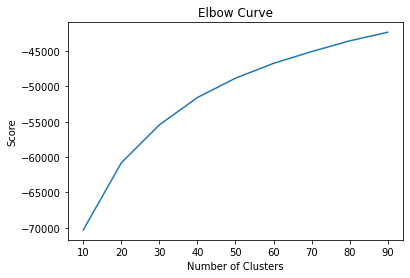

In [57]:
Nc = range(10, 100, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(pre_clusters).score(pre_clusters) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Probamos cambiando la metrica. Queremos ocupar la distancia de coseno. Para ello, basta con normalizar las entradas por renglon (https://stackoverflow.com/questions/46409846/using-k-means-with-cosine-similarity-python):

<font color='red' size="+2">
====================================================================
======== No se recomienda correr la siguiente celda ya que tarda demasiado ========
====================================================================    
</font>

In [ ]:
Nc = range(10, 100, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(preprocessing.normalize(pre_clusters)).score(preprocessing.normalize(pre_clusters)) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Previo a continuar, cabe notar que la razón para no hacer una gráfica de silueta es que aún si hay clusters que estén muy cercanos los unos a los otros, ya hemos pensado en formas de solventar este problema. Más aún, la gravedad de que ocurra esto para el propósito de este problema es negligible, a comparación por ejemplo de si queremos agrupar tipos de células o algo que sí requiera mucha precisión.

Sin mayor preferencia inducida por la grafica de codo, elegimos el modelo con 100 clusters con la distancia euclidiana.

In [76]:
K = 100

km_model = KMeans(n_clusters = K, random_state = 123).fit(pre_clusters)

Tratamos de darle interpretacion a algunos clusters:

In [77]:
clusters = pd.DataFrame(km_model.cluster_centers_, index = range(0,K), columns = pre_clusters.columns).round(6)

clusters.head(3)

,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,0.779415,0.357248,0.741595,0.644650,0.061538,0.000000,0.000000,0.000000,0.035897,-0.000000,...,0.010256,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.005128,-0.00000
1,0.008212,0.127605,0.041628,0.633426,0.000000,0.023788,0.004575,-0.000000,0.000000,0.025618,...,-0.000000,0.001372,0.000457,0.001372,0.000457,0.000915,0.000000,0.001372,0.003202,0.00183
2,0.081988,0.148516,0.052708,0.641391,1.000000,0.000000,0.000000,0.121569,-0.000000,0.011765,...,0.003922,0.003922,0.000000,0.000000,-0.000000,0.000000,0.003922,0.000000,0.015686,0.00000


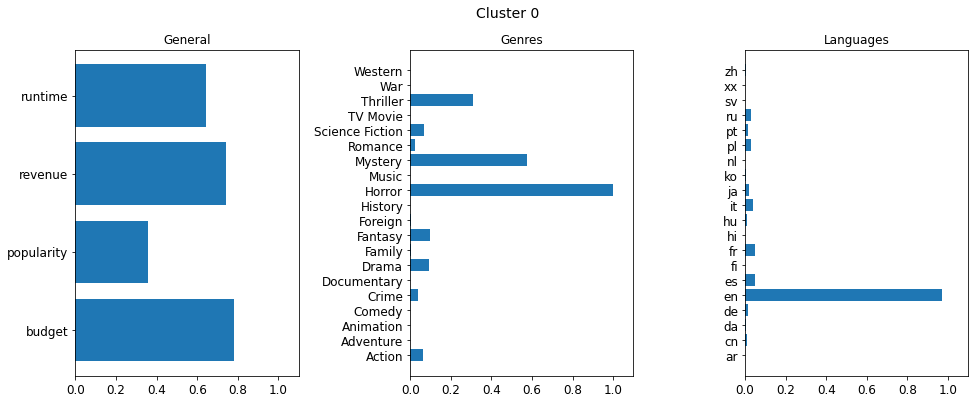

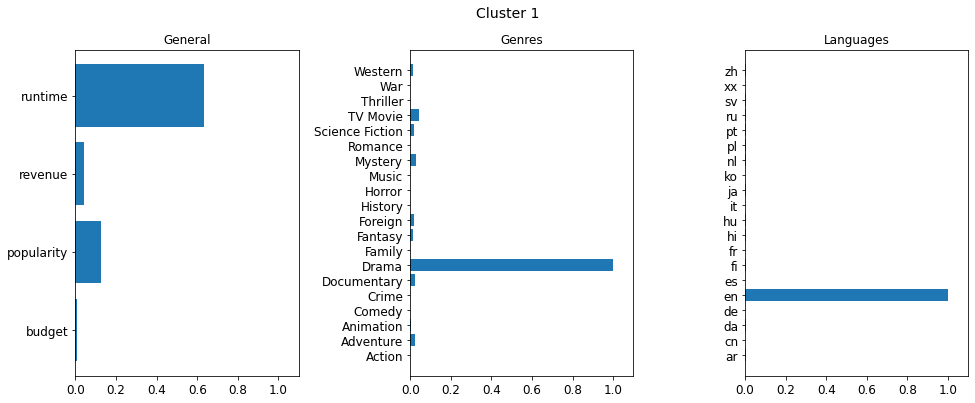

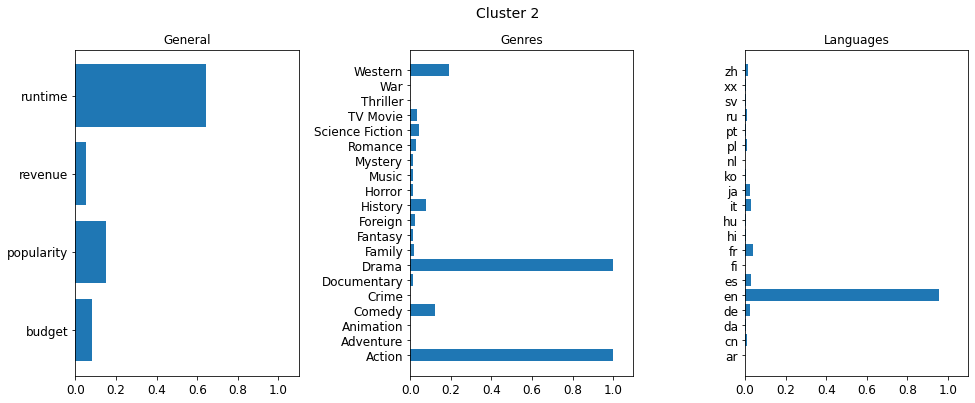

In [78]:
for cluster in [0,1,2]:
    md.plot_cluster_info(clusters, cluster, meta_cat, genres_cat, languages_cat)

Dadas algunas peliculas, veremos en que cluster están, y ver de qué forma las películas en esos clusters son similares:

In [79]:
### Lienas que sirvieron para obtener los nombres de algunas peliculas
# import re
# movies_metadata[['id', 'original_title']][movies_metadata['original_title'].apply(lambda x : re.search('Donnie Darko', x) is not None)]

### Seleccionamos las peliculas
some_movies = {
               141:'Donnie Darko', 
               862:'Toy Story', 
               500:'Reservoir Dogs',
               12153:'White Chicks', 
               38356:'Transformers: Dark of the Moon',
               }

some_movies_df = pd.DataFrame(pd.Series(some_movies), columns = ['original_title']).join(
                    pd.DataFrame(km_model.predict(pre_clusters.loc[[key for key in some_movies.keys()]]), 
                                 index = some_movies.keys(), columns = ['cluster']))

some_movies_df

,original_title,cluster
141,Donnie Darko,74
862,Toy Story,87
500,Reservoir Dogs,89
12153,White Chicks,6
38356,Transformers: Dark of the Moon,71


In [80]:
some_movies_df.iloc[0]['cluster']

74

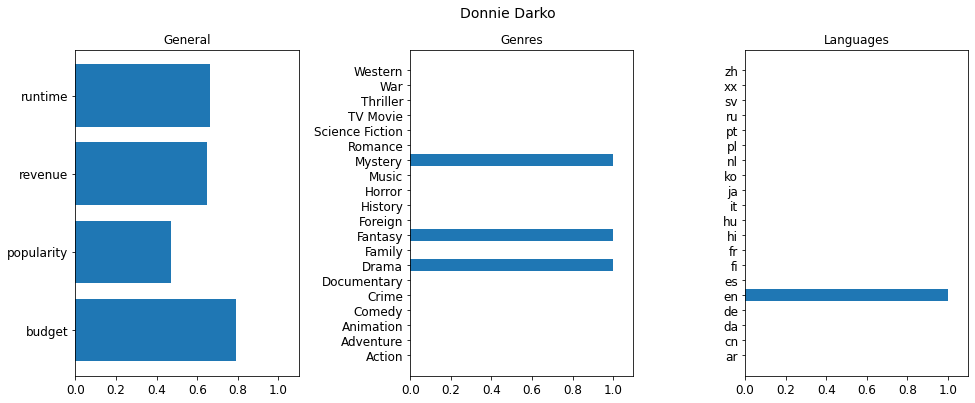

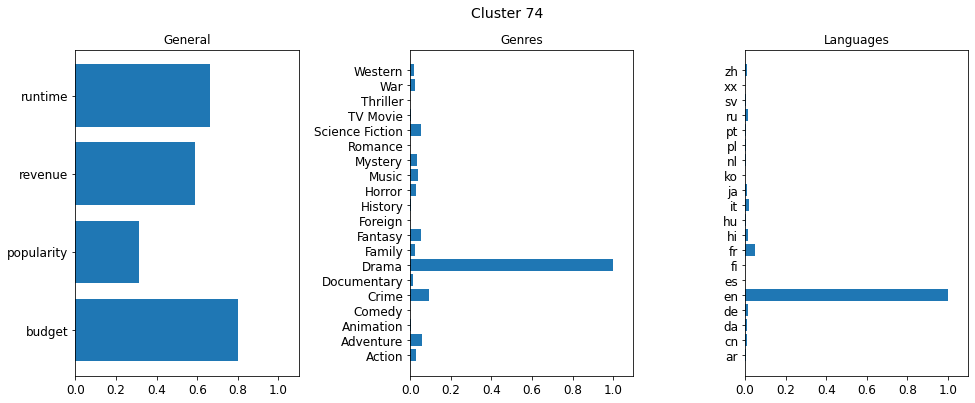

In [81]:
i = 0
md.plot_movie_info(movie_pre_cluster, some_movies_df.iloc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters, some_movies_df.iloc[i]['cluster'], meta_cat, genres_cat, languages_cat)

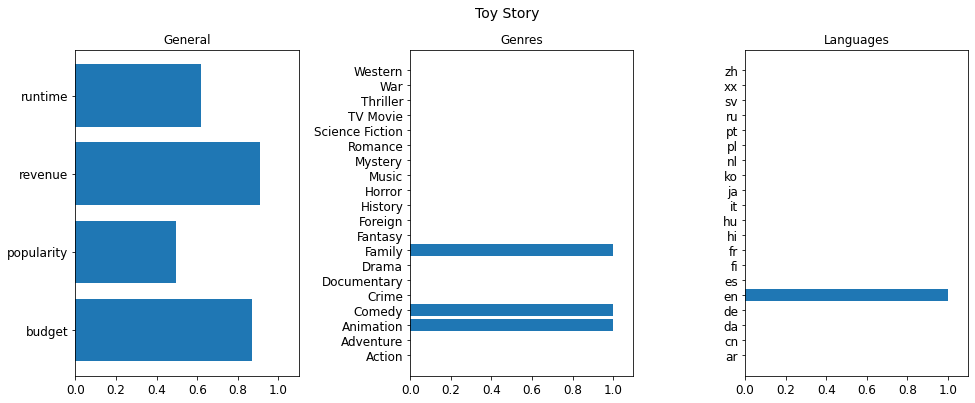

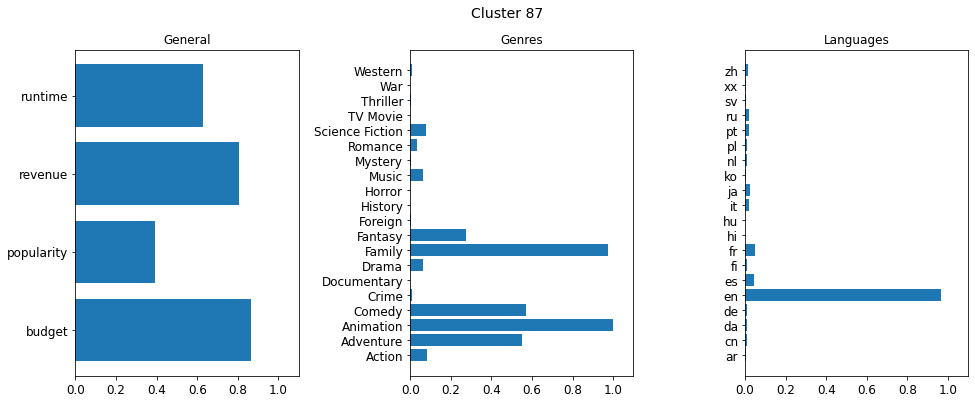

In [82]:
i = 1
md.plot_movie_info(movie_pre_cluster, some_movies_df.iloc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters, some_movies_df.iloc[i]['cluster'], meta_cat, genres_cat, languages_cat)

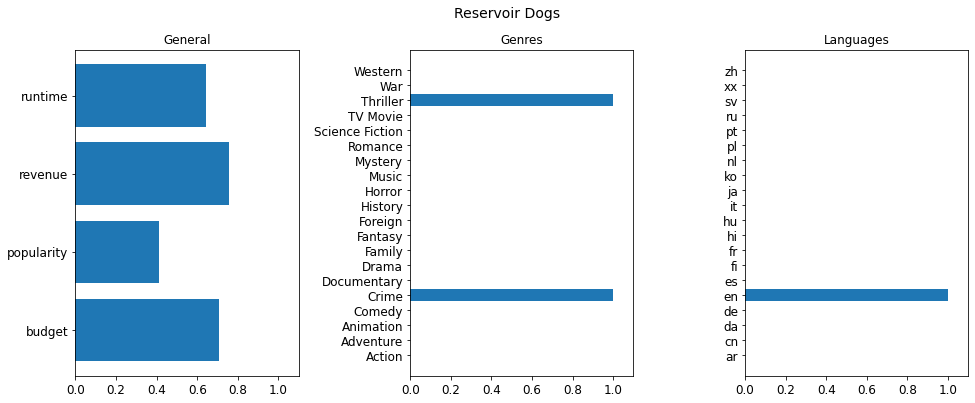

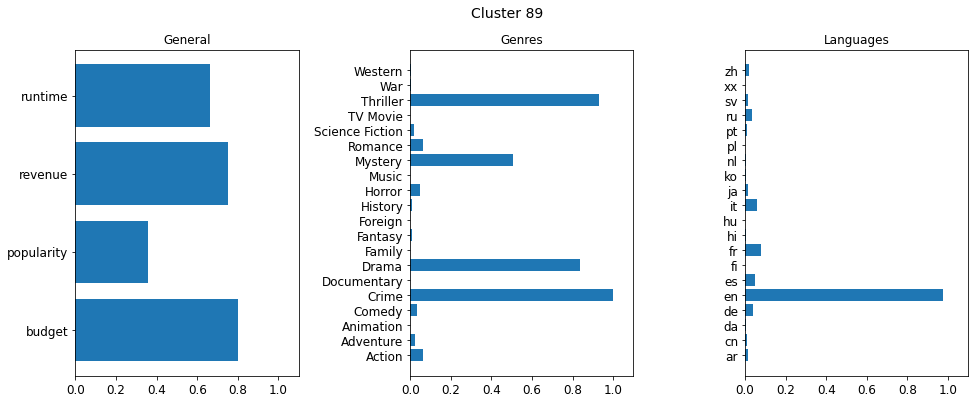

In [83]:
i = 2
md.plot_movie_info(movie_pre_cluster, some_movies_df.iloc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters, some_movies_df.iloc[i]['cluster'], meta_cat, genres_cat, languages_cat)

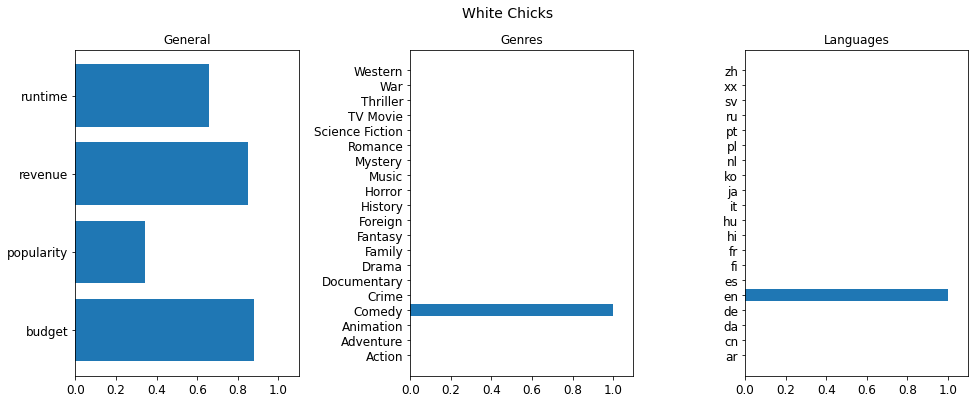

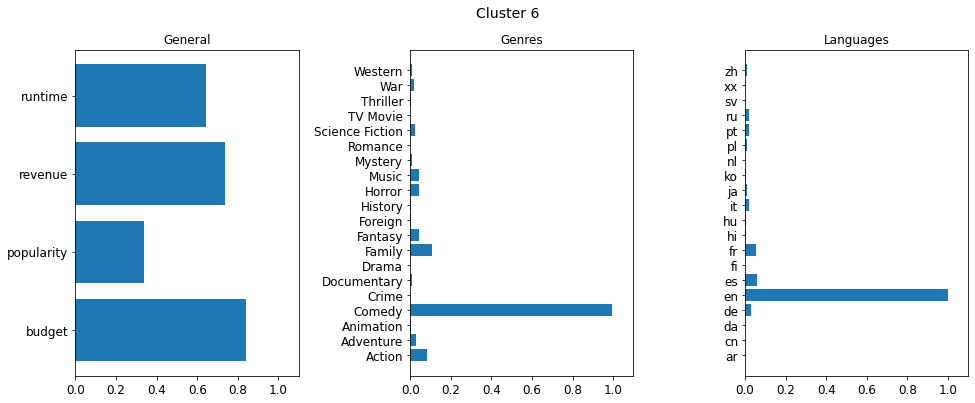

In [84]:
i = 3
md.plot_movie_info(movie_pre_cluster, some_movies_df.iloc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters, some_movies_df.iloc[i]['cluster'], meta_cat, genres_cat, languages_cat)

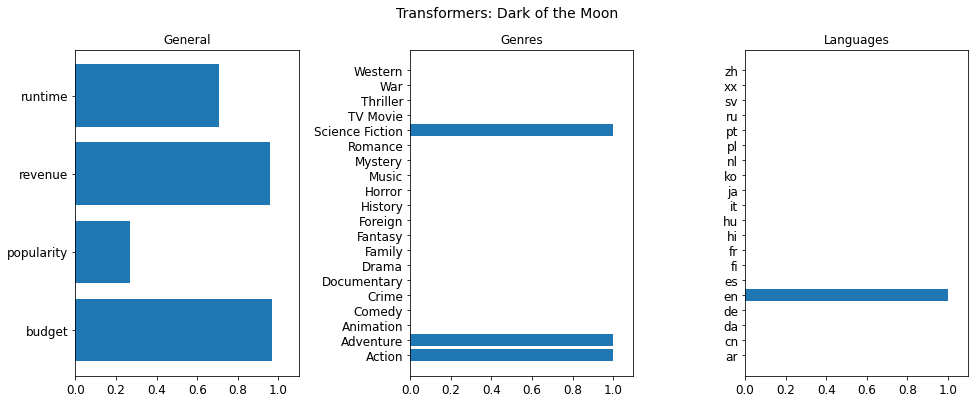

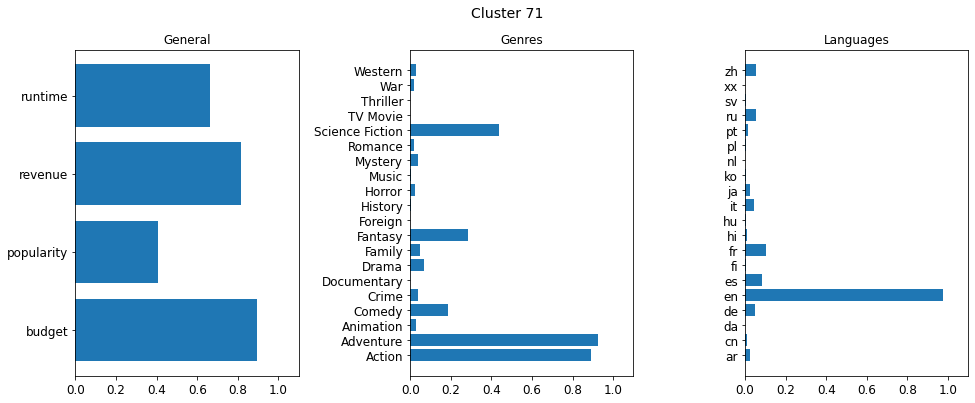

In [85]:
i = 4
md.plot_movie_info(movie_pre_cluster, some_movies_df.iloc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters, some_movies_df.iloc[i]['cluster'], meta_cat, genres_cat, languages_cat)

Preliminarmente vemos resultados positivos y coherentes. Ahora, nos gustaria que dada la eleccion de una pelicula, el sistema nos arrojara ya sea las otras más "cercanas" o parecidas, y además que nos regrese algunas aleatorias dentro del cluster en el que está. Para lo primero, el calcular las distancias vs todas las otras peliculas es muy lento, por lo que justo aprovecharemos el que ya tenemos los clusters para calcular las distancias unicamente dentro de los clusters.

#### Obteniendo las mas cercanas

Primero creamos un nuevo dataframe donde incluyamos el cluster al que pertenece cada pelicula

In [86]:
movie_clusters = movie_pre_cluster.copy()
movie_clusters['cluster'] = km_model.predict(pre_clusters)

Posteriormente, procedemos a obtener las mas cercanas dentro de ese cluster. Esto esta implementado tambien en modelos.py, pero lo presentamos una vez para que se vea el proceso

In [87]:
idx,n = 141,5 ### La 141 es Donnie Darko

### Guardamos el renglon con la pelicula que queremos comparar vs las demas
aux = movie_clusters.loc[idx].drop(['original_title', 'cluster'])

### El siguiente df recupera todas las peliculas en el mismo cluster que la pelicula seleccionada
movie_aux = movie_clusters.copy()
movie_aux = movie_aux[movie_aux['cluster'] == movie_aux.loc[idx]['cluster']]
movie_aux = movie_aux.drop(['original_title', 'cluster'], 1)

### Calculamos distancia euclidiana entre la pelicula y las de su cluster
movie_aux['dist'] = movie_aux.apply(lambda x : np.sqrt(np.sum((x-np.array(aux))**2)), 1)

### Agregamos el nombre
movie_aux = pd.DataFrame(movie_clusters['original_title']).join(movie_aux, how = 'inner')

### La primera es la misma, entonces se va
movie_aux = movie_aux.sort_values('dist').iloc[1:]

### Finalmente, recuperamos las n mas cercanas
print(f'Porque te gustó {some_movies[idx]}:')
movie_aux.head(n)

Porque te gustó Donnie Darko:


,original_title,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,...,ur,uz,vi,wo,xh,xx,yi,zh,zu,dist
id,,,,,,,,,,,,,,,,,,,,,
297,Meet Joe Black,0.927091,0.429643,0.863410,0.726883,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267439
1024,Heavenly Creatures,0.780785,0.371872,0.686499,0.645300,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.005756
1923,Twin Peaks: Fire Walk with Me,0.815871,0.360841,0.700792,0.687352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.007958
1939,Laura,0.700321,0.378513,0.667108,0.628970,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.008928
1411,The Rapture,0.709690,0.353903,0.646495,0.646694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.009984


In [88]:
idx,n = 141,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters, idx, n)

Porque te gustó Donnie Darko:


,original_title,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,...,ur,uz,vi,wo,xh,xx,yi,zh,zu,dist
id,,,,,,,,,,,,,,,,,,,,,
297,Meet Joe Black,0.927091,0.429643,0.863410,0.726883,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267439
1024,Heavenly Creatures,0.780785,0.371872,0.686499,0.645300,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.005756
1923,Twin Peaks: Fire Walk with Me,0.815871,0.360841,0.700792,0.687352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.007958
1939,Laura,0.700321,0.378513,0.667108,0.628970,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.008928
1411,The Rapture,0.709690,0.353903,0.646495,0.646694,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.009984


Vemos las demas peliculas:

In [89]:
idx,n = 862,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters, idx, n)['original_title']

Porque te gustó Toy Story:


id
863                               Toy Story 2
93456                         Despicable Me 2
585                            Monsters, Inc.
35                         The Simpsons Movie
109451    Cloudy with a Chance of Meatballs 2
Name: original_title, dtype: object

In [90]:
idx,n = 500,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters, idx, n)['original_title']

Porque te gustó Reservoir Dogs:


id
10909              Kalifornia
158011               The Call
64689     Killing Them Softly
199373      The Frozen Ground
276907                 Legend
Name: original_title, dtype: object

In [91]:
idx,n = 12153,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters, idx, n)['original_title']

Porque te gustó White Chicks:


id
2018         The Wedding Planner
32823       Get Him to the Greek
384682    Office Christmas Party
257091                  Get Hard
15373                Role Models
Name: original_title, dtype: object

In [92]:
idx,n = 38356,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters, idx, n)['original_title']

Porque te gustó Transformers: Dark of the Moon:


id
72545                Journey 2: The Mysterious Island
82700                                     After Earth
1895     Star Wars: Episode III - Revenge of the Sith
2135                                 The Time Machine
1894     Star Wars: Episode II - Attack of the Clones
Name: original_title, dtype: object

In [93]:
idx,n = 43347,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters, idx, n)['original_title']

Porque te gustó Love & Other Drugs:


id
38408                      Life As We Know It
11355                       Never Been Kissed
82696                            Hope Springs
76494    What to Expect When You're Expecting
7211                         Dan in Real Life
Name: original_title, dtype: object

#### Obteniendo aleatorias en el mismo cluster

Esto es todavía más sencillo. Viendo los resultados, quiza no vaya a servir tanto, y probablemente si realmente queremos más películas del mismo cluster, nos convenga seguir ocuando los n más cercanos haciendo crecer n.

In [94]:
idx,n = 141,5
movies_aux = movie_clusters.copy()[movie_clusters['cluster'] == movie_clusters.loc[idx]['cluster']]
movies_aux = movies_aux.drop(idx)

aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
movies_aux.sample(n)

Porque te gustó Donnie Darko:


,original_title,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,...,ur,uz,vi,wo,xh,xx,yi,zh,zu,cluster
id,,,,,,,,,,,,,,,,,,,,,
68722,The Master,0.874748,0.349672,0.788874,0.690432,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
226,Boys Don't Cry,0.734404,0.320222,0.747699,0.669675,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
1088,Whale Rider,0.804576,0.394512,0.806434,0.648075,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
266639,Jem and the Holograms,0.780785,0.294170,0.674203,0.670847,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
8065,21,0.879284,0.354207,0.830467,0.675442,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


In [95]:
idx,n = 141,5
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.aleatorias_en_cluster(movie_clusters, idx, n)

Porque te gustó Donnie Darko:


,original_title,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,...,ur,uz,vi,wo,xh,xx,yi,zh,zu,cluster
id,,,,,,,,,,,,,,,,,,,,,
127373,What Maisie Knew,0.790014,0.357535,0.638197,0.636629,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
175541,Black Nativity,0.844198,0.292975,0.724830,0.636629,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
43610,The Valley of Decision,0.738300,0.032891,0.736935,0.670847,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
3558,"Girl, Interrupted",0.886043,0.353313,0.000000,0.679891,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74
10220,Rounders,0.825100,0.361603,0.779251,0.673164,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


Dado que K-Means ocupa centroides relativamente aleatorios, entonces el que una película este o no junto con otras puede ser determinado a veces por suerte. Por ello, tenemos ideas que podemos implementar, por separado o en conjunto:

    1. Ocupar M corridas de K-Means. Asi, podemos recomendar peliculas de cualquiera de los M modelos.
    2. Ocupar diferentes niveles de K, e ir sugiriendo de mayor a menor. Esto ya que, una vez seleccionado el cluster 
        "ya no podemos salir", entonces, al menos mientras más grandes sean los clusters, agotamos las recomendaciones 
        menos rápido.
    3. Sugerir películas de los clusters más cercanos. Esto para evitar lo de "ya no poder salir"; en si resuelve lo
        mismo que el 2 pero con otro enfoque.      

## Idea #2 : Por Actor y/o Director

Si la película contiene al actor X, y este actor es "importante", entonces probablemente a la persona le interese ver películas con el mismo actor. 

Bajo esta idea, es importante definir que es "importante": Quiza no nos interese recomendar películas donde salgan los extras, pero sí los actores principales. Por otra parte, si esa película tiene muy bajos votos, quiza no nos interese recomendar ni a los prinipales.

Para ello, definimos entonces una métrica de "importancia"...

Asiumiendo que la variable **order** dentro de **credits_cast** si hace referencia al orden de importancia del actor en la pelicula, nos interesaria poder ocuparla para rankear a los actores. Como el 0 parece ser el valor mas importante y de ahi va subiendo, nos interesaria establecer una metrica inversa para que el 0 sea mapeado a un valor mas grande que el 1,2,etc.

Proponemos entonces lo siguiente:

Fijando el **id** de la pelicula $p$ (i.e. **parent_id**), definimos la metrica de orden como:

$$ M_{k,p} = 1 - O_{k,p}/(N_p)$$

donde $O_{k,p}$ es el valor de orden del actor k en la pelicula $p$, y $N_p$ es la cantidad de actores en tal pelicula. Asi, cuando $O_{k,p} = 0$, entonces $ M_{k,p} = 1$, y va decreciendo conforme aumente el valor de $O_{k,p}$.

In [96]:
if 'order_metric' not in credits_cast.columns:
    credits_cast['order_metric'] = None

    for k in credits_cast['parent_id'].unique():
        aux = credits_cast[credits_cast['parent_id'] == k]
        credits_cast.loc[aux.index, 'order_metric'] = np.array(1 - aux['order']/len(aux))
    
    credits_cast.to_csv('../movies-metadata/credits_cast.csv')

credits_cast['order_metric'] = credits_cast['order_metric'].apply(lambda x : float(x))

In [97]:
if 'order_metric2' not in credits_cast.columns:
    credits_cast['order_metric2'] = None

    for k in credits_cast['parent_id'].unique():
        aux = credits_cast[credits_cast['parent_id'] == k]
        credits_cast.loc[aux.index, 'order_metric2'] = np.array(1 - np.array(range(len(aux)))/len(aux))

    credits_cast.to_csv('../movies-metadata/credits_cast.csv')
    
credits_cast['order_metric2'] = credits_cast['order_metric2'].apply(lambda x : float(x))

#### Un comentario sobre la metrica de orden de actores

Aun si dos actores tienen por ejemplo un valor de 1 en la metrica, no implica que los dos sean en general "igual de buenos". Por ejemplo, no podemos directamente comparar a Tom Hanks en Toy Story contra el actor principal en alguna pelicula de bajo renombre.

Más adelante se vio que como **order** no siempre empieza en 0, habia valores erroneamente calculados. Por ello, creamos **order_metric2** que resuelve esto.

In [98]:
credits_cast['order_metric'][credits_cast['order_metric'] < 0].sort_values()

504626   -23.000000
521855    -9.000000
405130    -7.333333
547056    -5.142857
547055    -5.000000
            ...    
14767     -0.006623
215858    -0.005952
202408    -0.005464
180373    -0.005405
502458    -0.004808
Name: order_metric, Length: 3666, dtype: float64

In [99]:
credits_cast['order_metric2'][credits_cast['order_metric2'] < 0].sort_values()

Series([], Name: order_metric2, dtype: float64)

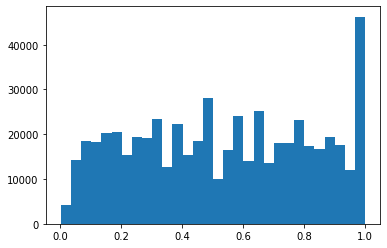

In [100]:
fig, ax = plt.subplots()
ax.hist(credits_cast['order_metric2'], bins = 30); plt.show()

De esta forma, comparando con los resultados anteriores, vemos que por ejemplo aunque Bess Flowers participo en 241 peliculas, en general era como extra, por lo que una mejor forma de representar la importancia es a traves de la orden de metrica propuesta:

In [101]:
credits_cast.groupby('name').sum()['order_metric2'].sort_values(ascending = False).head(10)

name
John Wayne            110.503753
Christopher Lee       110.045172
Jackie Chan           100.674952
Michael Caine          98.446688
Samuel L. Jackson      98.395827
Robert De Niro         95.519364
Gérard Depardieu       94.200447
Donald Sutherland      84.443632
Christopher Walken     79.147906
Nicolas Cage           76.446808
Name: order_metric2, dtype: float64

Complementando la metrica generada, nos gustaria combinarla con los ratings. Una primera idea seria ocupar el promedio de **rating** fijando **movieId**:

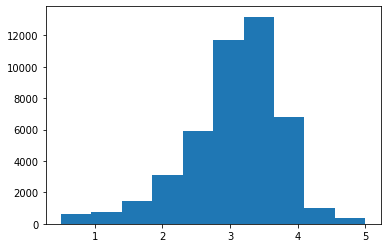

In [102]:
fig, ax = plt.subplots()
ax.hist(ratings.groupby('movieId').mean().rating); plt.show()

#### Issue

No obstante, notamos que hay una cantidad significativa de peliculas para los cuales muy pocos usuarios votaron.

Por ejemplo, un 39.727de las peliculas tienen menos de 5 votos. 

#### Solucion

Algunas posibles soluciones serian:

    1. Descartar las peliculas con menos de 3 (4, 5, etc. habra que ver el mejor corte) votos
    2. Asociarle a las que tengan menos de X votos el promedio de ratings
    3. Ignorarlo y trabajar asumiendo que aun 1 solo voto fue suficiente}
    
Por el momento se trabajará con la solución 3

Porcentaje de películas con menos de 5 votos:  39.727


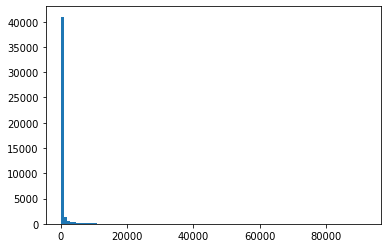

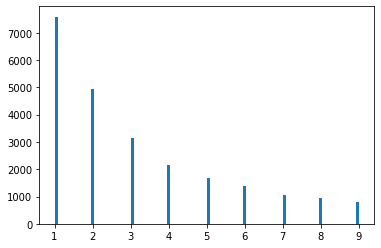

In [103]:
aux = ratings.groupby('movieId').count().rating

k = 5
print(f"Porcentaje de películas con menos de {k} votos: ", np.round(100*len(aux[aux < k])/len(aux), 3))

fig, ax = plt.subplots()
ax.hist(aux, bins = 100); plt.show()

fig, ax = plt.subplots()
ax.hist(aux[aux < 10], bins = 100); plt.show()

#### Nota: 
Es importante notar que incluso hay muchas películas sin votos. Específicamente tenemos la siguiente proporción:

In [104]:
### Quitamos los NA y convertimos a enteros los indices de tmdbId
links = links.dropna()
links['tmdbId'] = links['tmdbId'].apply(lambda x : int(x))
ratings = ratings.dropna()
ratings['tmdbId'] = ratings['tmdbId'].apply(lambda x : int(x))

In [105]:
aux = ratings.groupby('tmdbId').count()#.rating

In [106]:
print("Porcentaje de películas con al menos 1 voto:")
np.round(100*aux.join(credits, how = 'inner').shape[0]/aux.shape[0],2)

Porcentaje de películas con al menos 1 voto:


41.76

No obstante, ocuparemos lo que tenemos, ya que el modelo derivado de estas manipulaciones será usado en conjunto con otros, por lo que no necesitamos que contenga a todas las películas.

### Metrica score actor

Hay que ser cuidadosos con la definicion de la metrica  que resuma que tan bueno es un actor. Como ya hemos mencionado, no podemos simplemente tomar la cantidad de peliculas en las que ha salido, ni la metrica de orden que definimos, ni un promedio de ratings de las peliculas en las que ha salido. Al menos tendriamos que considerar esas 3 cantidades en conjunto y asociar una regla de correspondencia que sea coherente.

Previo a definir la metrica, mencionamos algunas cosas que nos gustaria evitar. Para este ejemplo, asumamos que $A_1$ es Tom Hanks, quien ha salido en multiples peliculas (72 en la base) que podrian ser consideradas buenas, $A_2$ es Marc Price, un actor elegido a proposito dado que tiene un orden de 0 (actor mas importante) y solo ha aparecido en una pelicula, y $A_3$ es Gerard Butler, que ha salido en 36 peliculas de acuerdo a la base (la mitad que Tom Hanks).

1. Suponiendo que la pelicula de $A_2$ tuvo rating de 5 (perfecto) y que el promedio de las 72 peliculas en las que ha salido $A_1$ sea menor a 5 (muy probable), no nos gustaria decir que $score(A_1) <= score(A_2)$, ya que, si bien pudiera existir la posibilidad que $A_2$ en verdad sea mejor que $A_1$, existen muy pocos registros (1 en este caso) para respaldarlo.

2. Suponiendo que el promedio de $A_1$ y $A_3$ en ratings es el mismo (digamos 4.2), y dado que la cantidad de peliculas en las que ha salido $A_1$ es el doble que $A_3$, no nos gustaria alguna relacion del estilo $score(A_1) = 2*score(A_3)$, sino tal vez aplicar logaritmos para que si se preserve $score(A_1) > score(A_3)$ pero no por tanto.

#### Sobre ocupar links

Algo muy importante previo a ocupar directamente **movieId** en **ratings** como si fuera el **id** en **credits** o en **movies_metadata**, es que este no es el mismo. Mas bien, hay que ocupar el csv de **links** para conectarlos, en la cual **movieId** coincide con **movieId** en **ratings**, y **tmdbid** coincide con **id** en **credits** y **movies_metadata**.

Las siguientes celdas nos ayudan justamente a unir todo tomando esto en cuenta.

In [107]:
if 'id_credits' not in credits_cast.columns:
    credits_cast = credits_cast.join(credits, rsuffix = '_credits', on = 'parent_id', how = 'inner').drop(['crew', 'cast'], 1)
    credits_cast.to_csv('../movies-metadata/credits_cast.csv')
    
credits_cast['id_credits'] = credits_cast['id_credits'].apply(lambda x : int(x))

In [108]:
if 'tmdbId' not in ratings.columns:
    ratings = ratings.join(links.set_index('movieId'), on = 'movieId')
    ratings = ratings.dropna() #Son muy pocos los NA
    ratings.drop('Unnamed: 0', 1, inplace = True)
    ratings.to_csv('../movies-metadata/ratings.csv')

ratings['tmdbId'] = ratings['tmdbId'].apply(lambda x: int(x))

Calculamos la media de ratings por id

In [109]:
mean_ratings = ratings.groupby('tmdbId').mean().rating
mean_ratings

tmdbId
2         3.673664
3         3.770115
5         3.409031
6         2.924862
11        4.132299
            ...   
465044    0.500000
467731    3.500000
468343    3.250000
468707    4.000000
469172    3.833333
Name: rating, Length: 44872, dtype: float64

Y ahora sí calculamos el score:

In [110]:
aux = credits_cast.join(mean_ratings, how = 'inner', on = 'id_credits')#[['name', 'id', 'order_metric', 'rating']]
aux['actor_score'] = aux['order_metric2']*aux['rating']

### El como determinar la siguiente trasnformación quiza afecte bastante. En general queremos algo monotonamente
### creciente. No obstante, aplicar log(x+1) aplasta mucho todo, y quiza aplicar raiz cuadrada
### no lo haga lo suficiente. Esto se debe analizar con más profundidad después.

# aux = aux.groupby('id').sum()['actor_score'].apply(lambda x: np.log(1 + x))
# aux = aux.groupby('id').sum()['actor_score'].apply(lambda x: x**(7/20))
# aux = aux.groupby('id').sum()['actor_score'].apply(lambda x: x**(8/20))
# aux = aux.groupby('id').sum()['actor_score'].apply(lambda x: x**(9/20))
aux = aux.groupby('id').sum()['actor_score'].apply(lambda x: np.sqrt(x))

score_actor = credits_cast[['name', 'id']].drop_duplicates().join(aux, how = 'inner', on = 'id')

Una pequeña gráfica ejemplificando el comentario hecho en la celda anterior

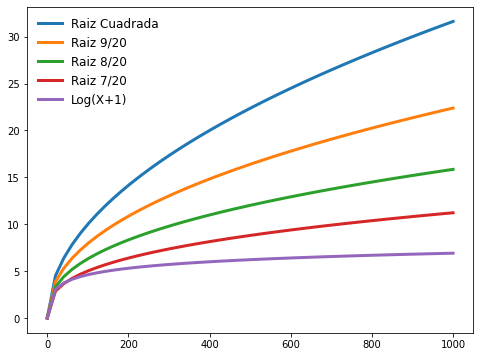

In [111]:
X = np.linspace(0, 1000, 50)
fig, ax = plt.subplots(figsize = (8, 6))
lw = 3
ax.plot(X, np.sqrt(X), label = 'Raiz Cuadrada', linewidth = lw)
ax.plot(X, X**(9/20), label = 'Raiz 9/20', linewidth = lw)
ax.plot(X, X**(8/20), label = 'Raiz 8/20', linewidth = lw)
ax.plot(X, X**(7/20), label = 'Raiz 7/20', linewidth = lw)
ax.plot(X, np.log(X+1), label = 'Log(X+1)', linewidth = lw)
plt.legend(frameon = False, fontsize = 12)

Observamos aquellos actores con el score más alto:

In [112]:
score_actor.sort_values(by = 'actor_score', ascending = False)[['name', 'actor_score']].set_index('name').head(10)

,actor_score
name,
John Wayne,17.905691
Christopher Lee,17.868135
Michael Caine,17.829644
Samuel L. Jackson,17.733898
Robert De Niro,17.692381
Jackie Chan,17.620916
Gérard Depardieu,17.254426
Donald Sutherland,16.392393
Christopher Walken,15.755753


Veamos si algunas de las condiciones que queriamos se cumplen

In [113]:
### Al parecer Mark Price desaparecio dentro de los join, pero en teoría debería de funcionar bien
print(score_actor[score_actor['name'] == 'Tom Hanks'])
print(score_actor[score_actor['name'] == 'Mark Price'])

        name  id  actor_score
0  Tom Hanks  31    14.499911
Empty DataFrame
Columns: [name, id, actor_score]
Index: []


In [114]:
print(score_actor[score_actor['name'] == 'Tom Hanks'])
print(score_actor[score_actor['name'] == 'Gerard Butler'])

        name  id  actor_score
0  Tom Hanks  31    14.499911
                name     id  actor_score
27568  Gerard Butler  17276     10.19412


El histograma de los scores se ve de la siguiente forma:

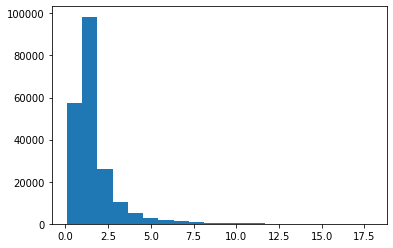

In [115]:
fig, ax = plt.subplots()
ax.hist(score_actor.actor_score, bins=20);

Podemos ocupar justamente la distribución implicita por el histograma como la probabilidad de recomendar una película con ese actor condicionado a que la película gustada contenga a tal actor. Por ejemplo, probando con actores reconocidos, esperaríamos que su probabilidad de ser recomendados sea alta:

In [116]:
score_actor['prob'] = score_actor['actor_score']/score_actor['actor_score'].max()

actores_reconocidos = ['Anne Hathaway', 'Gerard Butler', 'Tom Hanks', 'Scarlett Johansson', 'Vin Diesel']

score_actor[score_actor['name'].isin(actores_reconocidos)][['name', 'prob']].sort_values(by = 'prob', ascending = False)

,name,prob
0,Tom Hanks,0.809793
1962,Scarlett Johansson,0.671473
27568,Gerard Butler,0.569323
78364,Anne Hathaway,0.527997
34013,Vin Diesel,0.520468


Más adelante vimos que quiza el valor de la proba que tienen, para la forma en que se ocupará, tal vez sea muy alto. Por ello dejaremos algun parámetro que este entre 0 y 1 para reescalarlas:

In [117]:
actores_reconocidos = ['Anne Hathaway', 'Gerard Butler', 'Tom Hanks', 'Scarlett Johansson', 'Vin Diesel']

aux = score_actor[score_actor['name'].isin(actores_reconocidos)][['name', 'prob']].sort_values(by = 'prob', ascending = False)

factor_proba = 0.8
aux['prob'] = aux['prob']*factor_proba
aux

,name,prob
0,Tom Hanks,0.647835
1962,Scarlett Johansson,0.537179
27568,Gerard Butler,0.455458
78364,Anne Hathaway,0.422398
34013,Vin Diesel,0.416374


Ahora, lo que nos gustaría es recomendar una cantidad de películas del mismo actor aleatoriamente dentro de aquel conjunto de películas en las que el actor fue "importante". Al momento definiremos ese conjunto como a lo más $M$ películas, y dentro de esas $M$ películas se elegirán aleatoriamente una cantidad  $X \sim Bin(N,r)$, donde $r$ es el score normalizado del actor (que consideraremos como probabilidad).

Es importante notar que los valores de $M$ y $N$ establecidos previamente son arbitrarios, y la forma de elegirlos adecuadamente dependerá en el futuro de qué tanto les gusta a los usuarios que se les recomienden películas basado en actores.

También, nos gustaría tener la flexibilidad de poder elegir a la cantidad de actores para los que se llevará a cabo la elección aleatoria.

In [118]:
from scipy.stats import binom

In [119]:
idx = 862 ### Es Toy Story

## Parámetros
N = 5
M = 10
factor_proba = 0.5
maximo_actores = 4

## Obtenemos los índices de los actores en la determinada película
actors_indexes = list(credits_cast.set_index('id_credits').loc[idx].sort_values(by = 'order_metric2', ascending = False)['id'])

## Auxiliar para inicializar el DF
recomendadas_por_actores = 0

for actor_idx in actors_indexes[:maximo_actores]:
    # Obtenemos la proba (score) del actor
    prob = score_actor[score_actor['id'] == actor_idx]['prob'].iloc[0] 
    
    # Obtenemos la cantidad k de películas por actor aleatoriamente (a lo más N)
    k_por_actor = binom.rvs(N, prob*factor_proba)
    
    # Obtenemos películas con el mismo actor (quitando la misma película), y nos quedamos con el top M
    # de acuerdo a que tan importante fue el actor en esa película particular (order_metric2)
    top_10_por_actor = credits_cast[credits_cast['id'] == actor_idx].set_index('id_credits').drop(idx).sort_values(by = 'order_metric2', ascending=False).iloc[:M]
    
    # De las m <= M (porque puede que el actor no tenga M otras películas) seleccionadas,
    # obtenemos las k (con reemplazo porque si k > m truena) y quitamos los duplicados
    recomendadas_por_actor = top_10_por_actor.sample(k_por_actor, replace = True).drop_duplicates()
    
    # Vamos guardando todo en un DF
    if not isinstance(recomendadas_por_actores, pd.DataFrame):
        recomendadas_por_actores = recomendadas_por_actor
    else:
        recomendadas_por_actores = pd.concat([recomendadas_por_actores, recomendadas_por_actor])

## Finalmente, unimos con el df de películas y obtenemos los títulos     
movies_metadata.join(recomendadas_por_actores[['name']], on = "id", how = 'inner')[['original_title', 'name']].sort_values(by='name')        

,original_title,name
5448,Ernest Scared Stupid,Jim Varney
13760,Ernest Rides Again,Jim Varney
351,Forrest Gump,Tom Hanks
8237,The Polar Express,Tom Hanks
9116,From the Earth to the Moon,Tom Hanks


Repetimos esto pero ya implementado en el script. Como es de esperarse, no serán las mismas siempre.

In [120]:
idx = 862 ### Es Toy Story

md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata, N = 5, M = 10, factor_proba = 0.5, maximo_actores = 4)

,original_title,name
2996,Toy Story 2,Don Rickles
414,The Beverly Hillbillies,Jim Varney
5510,Ernest In The Army,Jim Varney
19043,Chimpanzee,Tim Allen
147,Apollo 13,Tom Hanks
8237,The Polar Express,Tom Hanks
9116,From the Earth to the Moon,Tom Hanks


Es importante notar por ejemplo en este caso de Toy Story, que quiza un menor sea quien esté viendo películas, y no le interese en lo más mínimo ver alguna de las recomendadas de esta forma. No obstante, cabe recordar que el algoritmo está siendo desarrollado para **nuevos usuarios**. Por lo tanto, suponiendo que no contamos con la información de la edad de la persona ni su historial previo de películas, podríamos atinarle a sus gustos al recomendarle de esta forma.

Ya posteriormente con más historial de películas podría empezar a reemplazarse este algoritmo para ese determinado usuario por el de la descomposición SVD.

Analizamos para algunas otras películas

In [121]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata)

Porque te gustó Donnie Darko:


,original_title,name
15261,Prince of Persia: The Sands of Time,Jake Gyllenhaal
16205,Love & Other Drugs,Jake Gyllenhaal
16828,Source Code,Jake Gyllenhaal
32935,Demolition,Jake Gyllenhaal
42559,Lovesong,Jena Malone
19742,Won't Back Down,Maggie Gyllenhaal
4998,Green Dragon,Patrick Swayze


Vemos las demas peliculas, ocupando los parámetros default( N = 5, M = 10, factor_proba = 0.5 & maximo_actores = 4):

In [122]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata)

Porque te gustó Toy Story:


,original_title,name
2996,Toy Story 2,Don Rickles
12025,The Wool Cap,Don Rickles
26491,Muscle Beach Party,Don Rickles
14653,Ernest Goes to School,Jim Varney
11376,The Santa Clause 3: The Escape Clause,Tim Allen
147,Apollo 13,Tom Hanks
8156,The Man with One Red Shoe,Tom Hanks
12279,Charlie Wilson's War,Tom Hanks


In [123]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata)

Porque te gustó Reservoir Dogs:


,original_title,name
24166,Cement,Chris Penn
2495,Three Seasons,Harvey Keitel
9096,Executive Target,Michael Madsen
17044,Vice,Michael Madsen
20377,The Liability,Tim Roth


In [124]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata)

Porque te gustó White Chicks:


,original_title,name
586,The Silence of the Lambs,Frankie Faison
26907,Mayor Cupcake,Frankie Faison
4181,Pearl Harbor,Jaime King
20216,A Haunted House,Marlon Wayans
62,Don't Be a Menace to South Central While Drink...,Shawn Wayans


In [125]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata)

Porque te gustó Transformers: Dark of the Moon:


,original_title,name
3772,Almost Famous,Frances McDormand
6956,Al di là delle nuvole,John Malkovich
13643,The Great Buck Howard,John Malkovich
15767,Vampires Suck,Ken Jeong
10386,The Greatest Game Ever Played,Shia LaBeouf
22068,Charlie Countryman,Shia LaBeouf


In [126]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata)

Porque te gustó Love & Other Drugs:


,original_title,name
13294,Bride Wars,Anne Hathaway
1772,Godzilla,Hank Azaria
17493,The Smurfs,Hank Azaria
11643,Zodiac,Jake Gyllenhaal
3325,Funny Bones,Oliver Platt


### Pendientes:

    1. Hacer lo mismo pero para directores.

## Idea #3 : Mezclando algoritmos

Una vez generados estos 2 algoritmos y previo a definir los demás o las mejoras a estos mismos, trabajamos en una forma de mezclarlos. Esto en si es simple, ya que lo único que hariamos es llamar a ambos métodos y definir un vector de probabilidades $p = (p_1, ..., p_k)$ (en el caso de ser 2 modelos, basta con una proba) tal que cada modelo elija con probabilidad $p_k$ a cada renglón:

In [127]:
### Parametros
#Para k-means
n = 12

#Para actores
N_ac=8
M_ac=10
factor_proba_ac=0.5
maximo_actores=5

#Probabilidades de seleccionar modelos
p_k = 0.7
p_k_means = p_k
p_actores = 1-p_k

Revisamos para las películas que hemos venido analizando. En si, no debería de cambiar drásticamente de lo que hemos visto si no que solo debería ser una mezcla de ambos

In [128]:
idx = 862 ## Toy Story

modelos = {
           'k-means': {
                       'funcion': md.mas_cercanas_a_pelicula(movie_clusters, idx, n)['original_title'],
                       'p_k': p_k_means
                      },
                       
                       
           'actores': {
                       'funcion': md.recomendadas_por_actores(idx, credits_cast, score_actor, movies_metadata,
                                                              N_ac, M_ac, factor_proba_ac, maximo_actores)['original_title'],
                       'p_k': p_actores
                      },                       
          }

pd.concat([modelos[key]['funcion'].sample(frac = modelos[key]['p_k']) for key in modelos.keys()])

11836       The SpongeBob SquarePants Movie
7443                            Chicken Run
585                          Monsters, Inc.
378236                      The Emoji Movie
93456                       Despicable Me 2
9982                         Chicken Little
22794     Cloudy with a Chance of Meatballs
35                       The Simpsons Movie
5633                   My Dinner with André
8237                      The Polar Express
21866                            The Double
Name: original_title, dtype: object

Lo implementamos en el script

In [129]:
idx = 862 ## Toy Story
p = {'k-means': 0.7, 'actores': 0.3}

md.mezcla_modelos(idx, p, 
                  movie_clusters, n, 
                  credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores)

378236                        The Emoji Movie
7443                              Chicken Run
35                         The Simpsons Movie
863                               Toy Story 2
295693                          The Boss Baby
585                            Monsters, Inc.
93456                         Despicable Me 2
109451    Cloudy with a Chance of Meatballs 2
2085                               Dirty Work
7213                          The Ladykillers
329                      Vanya on 42nd Street
Name: original_title, dtype: object

Vemos que con una proba de 1 en cualquiera de los dos casos recuperamos lo que veiamos antes (en k-means es exacto y en actores existe variabilidad por la binomial):

In [130]:
idx = 862 ## Toy Story
p = {'k-means': 1, 'actores': 0}

md.mezcla_modelos(idx, p, 
                  movie_clusters, 5, 
                  credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores)

585                            Monsters, Inc.
863                               Toy Story 2
35                         The Simpsons Movie
109451    Cloudy with a Chance of Meatballs 2
93456                         Despicable Me 2
Name: original_title, dtype: object

In [131]:
idx = 862 ## Toy Story
p = {'k-means': 0, 'actores': 1}

md.mezcla_modelos(idx, p, 
                  movie_clusters, n, 
                  credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores)

10855                 The Shaggy Dog
5633            My Dinner with André
10969              The Da Vinci Code
20674                      Admission
12025                   The Wool Cap
11168                           Zoom
21866                     The Double
19043                     Chimpanzee
26491             Muscle Beach Party
8237               The Polar Express
45394    Cop and a Half: New Recruit
7359                      Just Write
5510              Ernest In The Army
Name: original_title, dtype: object

## Mejoras a lo que se tiene

### Mejoras a K-Means

Ya hemos construido dos modelos de recomendación, pero nos gustaría mejorarlos o aumentarlos. Comenzamos con los K-Means. Si bien 100 clusters nos estaba dando resultados buenos, queremos ver si en algún momento la gráfica de codo se suaviza. 

Vemos de la gráfica siguiente que no parece haber un claro momento en el que se aplane, y seguir aumentando los clusters nos puede dejar con relativamente pocas películas pór cluster. Por ejemplo, como tenemos 45473 registros de películas, el ocupar 1000 clusters nos dejaría en promedio con 45 películas por cluster. Quiza no son tan pocos, pero nos gustaría tener más, por lo que lo elegiremos aquel K que nos deje con 120 películas, que son alrededor de 380.

In [132]:
print("Cantidad de películas en la base:")
credits.shape[0]

Cantidad de películas en la base:


45436

In [133]:
print("Cantidad de películas por cluster si K=1000:")
credits.shape[0]/1000

Cantidad de películas por cluster si K=1000:


45.436

In [134]:
print("Valor de K si queremos que en promedio hayan 120 películas por cluster:")
credits.shape[0]/120

Valor de K si queremos que en promedio hayan 120 películas por cluster:


378.6333333333333

<font color='red' size="+2">
====================================================================
======== No se recomienda correr la siguiente celda ya que tarda demasiado ========
====================================================================    
</font>

In [ ]:
Nc = range(100, 500, 5)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(pre_clusters).score(pre_clusters) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Como comentábamos previamente en las limitaciones, por pura suerte puede ser que dos o más películas muy cercanas no caigan en el mismo cluster, por lo que ocuparemos 3 modelos:
 
     1. K = 380, semilla = 123 (120 películas por cluster)
     2. K = 380, semilla = 765 (120 películas por cluster)
     3. K = 190, semilla = 888 (240 películas por cluster)
     
Tal que los primeros 2 traten de resolver esa intersección, y el tercero trate de abracar un conjunto más grande.

In [135]:
K = 380

km_model_1 = KMeans(n_clusters = K, random_state = 123).fit(pre_clusters)

In [136]:
K = 380

km_model_2 = KMeans(n_clusters = K, random_state = 765).fit(pre_clusters)

In [137]:
K = 190

km_model_3 = KMeans(n_clusters = K, random_state = 888).fit(pre_clusters)

In [138]:
K = 380
clusters_1 = pd.DataFrame(km_model_1.cluster_centers_, index = range(0,K), columns = pre_clusters.columns).round(6)

clusters_1.head(3)

,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,0.479364,0.241207,0.596234,0.667322,0.142857,0.000000,0.000000,0.428571,0.071429,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.071013,0.134946,0.012227,0.400400,-0.000000,0.005848,1.000000,0.298246,-0.000000,0.0,...,0.0,-0.0,0.0,-0.000000,0.0,0.0,0.005848,-0.000000,-0.000000,0.0
2,0.003417,0.162092,0.010375,0.620714,0.213333,0.073333,0.006667,1.000000,1.000000,-0.0,...,0.0,-0.0,0.0,0.006667,0.0,0.0,-0.000000,0.006667,0.006667,0.0


In [139]:
K = 380
clusters_2 = pd.DataFrame(km_model_2.cluster_centers_, index = range(0,K), columns = pre_clusters.columns).round(6)

clusters_2.head(3)

,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,0.096745,0.090527,0.000000,0.658446,1.0,0.15625,0.031250,0.09375,0.28125,0.031250,...,0.0,-0.0,0.0,0.0625,0.0,0.000000,0.0,-0.000000,0.0,0.000000
1,0.000451,0.267618,0.001101,0.632637,-0.0,0.00000,0.000000,1.00000,0.00000,-0.000000,...,0.0,-0.0,0.0,0.0000,0.0,0.000000,-0.0,0.003215,-0.0,0.000000
2,0.014381,0.140175,0.063018,0.640868,-0.0,-0.00000,0.001449,0.00000,0.00000,0.001449,...,0.0,-0.0,0.0,0.0000,0.0,0.001449,-0.0,0.001449,-0.0,0.001449


In [140]:
K = 190
clusters_3 = pd.DataFrame(km_model_3.cluster_centers_, index = range(0,K), columns = pre_clusters.columns).round(6)

clusters_3.head(3)

,budget,popularity,revenue,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
0,0.059842,0.085464,0.022729,0.621771,-0.000000,0.013055,-0.0,-0.000000,0.036554,0.010444,...,0.015666,0.005222,0.0,0.010444,0.002611,0.000000,0.096606,0.005222,-0.000000,0.002611
1,0.771443,0.309907,0.455834,0.637675,0.070866,0.011811,-0.0,0.059055,0.070866,-0.000000,...,0.003937,-0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
2,0.007596,0.140250,0.072399,0.631801,0.015428,0.008415,0.0,1.000000,0.000000,0.004208,...,0.000000,-0.000000,0.0,0.000000,0.000000,0.001403,-0.000000,0.000000,0.001403,0.002805


#### Obteniendo las mas cercanas

Primero creamos un nuevo dataframe donde incluyamos el cluster al que pertenece cada pelicula

In [141]:
movie_clusters_1 = movie_pre_cluster.copy()
movie_clusters_2 = movie_pre_cluster.copy()
movie_clusters_3 = movie_pre_cluster.copy()

movie_clusters_1['cluster'] = km_model_1.predict(pre_clusters)
movie_clusters_2['cluster'] = km_model_2.predict(pre_clusters)
movie_clusters_3['cluster'] = km_model_3.predict(pre_clusters)

Posteriormente, procedemos a obtener las mas cercanas dentro de cada modelo para ese cluster. Notamos que ocupando cada cluster trae resultados diferentes, lo cual es algo esperado (el 2 se parece mucho al 3, pero igual es algo que puede ocurrir)

In [142]:
all_movie_clusters = [movie_clusters_1, movie_clusters_2, movie_clusters_3]

In [143]:
idx,n = 141,5

k = 0 
movie_clusters_k = all_movie_clusters[k].copy()

aux = movie_clusters_k.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters_k, idx, n)['original_title']

Porque te gustó Donnie Darko:


id
1923    Twin Peaks: Fire Walk with Me
1939                            Laura
1411                      The Rapture
9777                            Proof
15                       Citizen Kane
Name: original_title, dtype: object

In [144]:
idx,n = 141,5

k = 1
movie_clusters_k = all_movie_clusters[k].copy()

aux = movie_clusters_k.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters_k, idx, n)['original_title']

Porque te gustó Donnie Darko:


id
297                    Meet Joe Black
1923    Twin Peaks: Fire Walk with Me
1939                            Laura
1411                      The Rapture
9777                            Proof
Name: original_title, dtype: object

In [145]:
idx,n = 141,5

k = 2
movie_clusters_k = all_movie_clusters[k].copy()

aux = movie_clusters_k.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters_k, idx, n)['original_title']

Porque te gustó Donnie Darko:


id
297                    Meet Joe Black
1024               Heavenly Creatures
1923    Twin Peaks: Fire Walk with Me
1939                            Laura
1411                      The Rapture
Name: original_title, dtype: object

Procedemos a hacer una función que junte las películas de los 3 clusters, dándole más peso a los primeros dos ya que son más específicos:

In [146]:
idx, n = 141, [5, 5, 2]

## Incicializamos para facilitar obtener el DF
todas_las_mas_cercanas = 0

for movie_clusters_k, n_k in zip(all_movie_clusters, n):     
    
    df = md.mas_cercanas_a_pelicula(movie_clusters_k, idx, n_k)
    
    # Vamos guardando todo en un DF
    if not isinstance(todas_las_mas_cercanas, pd.DataFrame):
        todas_las_mas_cercanas = df
    else:
        todas_las_mas_cercanas = pd.concat([todas_las_mas_cercanas, df])

todas_las_mas_cercanas = todas_las_mas_cercanas.drop_duplicates()

In [147]:
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
todas_las_mas_cercanas['original_title']

Porque te gustó Donnie Darko:


id
1923    Twin Peaks: Fire Walk with Me
1939                            Laura
1411                      The Rapture
9777                            Proof
15                       Citizen Kane
297                    Meet Joe Black
1024               Heavenly Creatures
Name: original_title, dtype: object

Lo replicamos en el script:

In [148]:
idx, n = 141, [5, 5, 2]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mezcla_mas_cercanas_a_pelicula(all_movie_clusters, idx, n)['original_title']

Porque te gustó Donnie Darko:


id
1923    Twin Peaks: Fire Walk with Me
1939                            Laura
1411                      The Rapture
9777                            Proof
15                       Citizen Kane
297                    Meet Joe Black
1024               Heavenly Creatures
Name: original_title, dtype: object

Vemos las demas peliculas. Lo que notamos es que, al menos para la selección de películas que estamos revisando, los clusters son prácticamente idénticos entre si. Más aún, se parecen mucho a los resultados que obtuvimos con solo 100 clusters. Entonces, desde antes ya estábamos teniendo una buena separación (basados en estas películas).

In [149]:
idx, n = 862, [5, 5, 2]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mezcla_mas_cercanas_a_pelicula(all_movie_clusters, idx, n)['original_title']

Porque te gustó Toy Story:


id
863                               Toy Story 2
93456                         Despicable Me 2
585                            Monsters, Inc.
35                         The Simpsons Movie
109451    Cloudy with a Chance of Meatballs 2
Name: original_title, dtype: object

In [150]:
idx, n = 500, [5, 5, 2]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mezcla_mas_cercanas_a_pelicula(all_movie_clusters, idx, n)['original_title']

Porque te gustó Reservoir Dogs:


id
10909              Kalifornia
158011               The Call
64689     Killing Them Softly
199373      The Frozen Ground
276907                 Legend
Name: original_title, dtype: object

In [151]:
idx, n = 12153, [5, 5, 2]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mezcla_mas_cercanas_a_pelicula(all_movie_clusters, idx, n)['original_title']

Porque te gustó White Chicks:


id
2018         The Wedding Planner
32823       Get Him to the Greek
384682    Office Christmas Party
257091                  Get Hard
15373                Role Models
Name: original_title, dtype: object

In [152]:
idx, n = 38356, [5, 5, 2]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mezcla_mas_cercanas_a_pelicula(all_movie_clusters, idx, n)['original_title']

Porque te gustó Transformers: Dark of the Moon:


id
72545                Journey 2: The Mysterious Island
82700                                     After Earth
1895     Star Wars: Episode III - Revenge of the Sith
2135                                 The Time Machine
1894     Star Wars: Episode II - Attack of the Clones
Name: original_title, dtype: object

In [153]:
idx, n = 43347, [5, 5, 2]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mezcla_mas_cercanas_a_pelicula(all_movie_clusters, idx, n)['original_title']

Porque te gustó Love & Other Drugs:


id
38408                      Life As We Know It
11355                       Never Been Kissed
82696                            Hope Springs
76494    What to Expect When You're Expecting
7211                         Dan in Real Life
Name: original_title, dtype: object

Solo como una prueba de la risa, vemos cuantas películas hay en cada cluster y como se comporta la cantidad de películas  en la unión. La intuición detrás de esto es que, si la unión contiene una cantidad de películas similar a la máxima cantidad entre cada modelo por si sólo, entonces realmente no hay variedad entre modelos y en todo caso convendría ocupar al de mayor cardinalidad. Por otra parte, si la cardinalidad de la unión es muy alta comparada al máximo, entonces cada modelo está aportando una cantidad significativa de películas, por lo que preservar a cada uno de ellos es deseable.

Esto nos dio visibilidad que aunque el promedio de películas que esperábamos era de 120, hay clusters con muchos menos valores de los que esperábamos. Por esta razón, aunque para las películas más cercanas se vea que no hay gran diferencia, consideramos que ocupar a los 3 modelos nos dará palanca dado que algún usuario agote rápidamente las películas que le hubiera recomendado sólo 1 modelo:

In [154]:
idx, n = 141, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])

Porque te gustó Donnie Darko:
Cantidad de películas en el modelo 1:
89
Cantidad de películas en el modelo 2:
39
Cantidad de películas diferentes del modelo 1 + 2:
108
Cantidad de películas en el modelo 3:
438


In [155]:
idx, n = 862, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])

Porque te gustó Toy Story:
Cantidad de películas en el modelo 1:
82
Cantidad de películas en el modelo 2:
120
Cantidad de películas diferentes del modelo 1 + 2:
165
Cantidad de películas en el modelo 3:
100


In [156]:
idx, n = 500, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])

Porque te gustó Reservoir Dogs:
Cantidad de películas en el modelo 1:
53
Cantidad de películas en el modelo 2:
82
Cantidad de películas diferentes del modelo 1 + 2:
119
Cantidad de películas en el modelo 3:
60


In [157]:
idx, n = 12153, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])

Porque te gustó White Chicks:
Cantidad de películas en el modelo 1:
307
Cantidad de películas en el modelo 2:
324
Cantidad de películas diferentes del modelo 1 + 2:
340
Cantidad de películas en el modelo 3:
388


In [158]:
idx, n = 38356, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])

Porque te gustó Transformers: Dark of the Moon:
Cantidad de películas en el modelo 1:
88
Cantidad de películas en el modelo 2:
97
Cantidad de películas diferentes del modelo 1 + 2:
110
Cantidad de películas en el modelo 3:
150


In [159]:
idx, n = 43347, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])

Porque te gustó Love & Other Drugs:
Cantidad de películas en el modelo 1:
191
Cantidad de películas en el modelo 2:
237
Cantidad de películas diferentes del modelo 1 + 2:
254
Cantidad de películas en el modelo 3:
263


Con respecto a las mejoras que teníamos:

1. Ocupar M corridas de K-Means. Asi, podemos recomendar peliculas de cualquiera de los M modelos.

    **Ocupamos M=2 para empezar y ya desde ese momento vimos que los clusters son muy similares, por lo que nos quedamos
    con ese valor.**


2. Ocupar diferentes niveles de K, e ir sugiriendo de mayor a menor. Esto ya que, una vez seleccionado el cluster 
    "ya no podemos salir", entonces, al menos mientras más grandes sean los clusters, agotamos las recomendaciones 
    menos rápido.

    **Ocupamos K = 380 tal que haya en promedio 120 películas, pero al analizar algunos de los clusters se aprecia que
    hay algunos con muy poca cantidad, por lo que también ocupamos K = 190 (240 películas en promedio).**


3. Sugerir películas de los clusters más cercanos. Esto para evitar lo de "ya no poder salir"; en si resuelve lo
    mismo que el 2 pero con otro enfoque.      

    **En si el punto 2 ya soluciona esto.**

### Hierarchical Clustering

También nos gustaría ocupar un modelo de Hierarchical Clustering para comparar:

In [160]:
from sklearn.cluster import AgglomerativeClustering

h_cluster = AgglomerativeClustering(n_clusters=380, affinity='euclidean', linkage='ward').fit(pre_clusters)

#### Obteniendo las mas cercanas

Primero creamos un nuevo dataframe donde incluyamos el cluster al que pertenece cada pelicula

In [161]:
movie_clusters_h = movie_pre_cluster.copy()

movie_clusters_h['cluster'] = h_cluster.labels_

Obtenemos las más cercanas análogo a lo que se hizo previamente:

In [162]:
idx,n = 141,5

aux = movie_clusters_h.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.mas_cercanas_a_pelicula(movie_clusters_h, idx, n)['original_title']

Porque te gustó Donnie Darko:


id
297          Meet Joe Black
9667             The Jacket
137321        Winter's Tale
9697      Lady in the Water
2668          Sleepy Hollow
Name: original_title, dtype: object

Directamente compararemos con respecto a las intersecciones. 

Los resultados de las siguientes celdas nos indican que para la mayoría de las películas que estamos analizando, el modelo de Hierarchical Clustering sí está aportando variedad (la cantidad de películas en la unión de los modelos i.e. quitando duplicados aumenta considerablemente), por lo que es de nuestro interés conservarlo.

In [163]:
idx, n = 141, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas en el modelo HC:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])
print("Cantidad de películas en modelo 1 + 2 + 3 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])

Porque te gustó Donnie Darko:
Cantidad de películas en el modelo 1:
89
Cantidad de películas en el modelo 2:
39
Cantidad de películas en el modelo HC:
76
Cantidad de películas diferentes del modelo 1 + 2:
108
Cantidad de películas diferentes del modelo 1 + 2 + HC:
176
Cantidad de películas en el modelo 3:
438
Cantidad de películas en modelo 1 + 2 + 3 + HC:
599


In [164]:
idx, n = 862, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas en el modelo HC:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])
print("Cantidad de películas en modelo 1 + 2 + 3 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])

Porque te gustó Toy Story:
Cantidad de películas en el modelo 1:
82
Cantidad de películas en el modelo 2:
120
Cantidad de películas en el modelo HC:
75
Cantidad de películas diferentes del modelo 1 + 2:
165
Cantidad de películas diferentes del modelo 1 + 2 + HC:
209
Cantidad de películas en el modelo 3:
100
Cantidad de películas en modelo 1 + 2 + 3 + HC:
236


In [165]:
idx, n = 500, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas en el modelo HC:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])
print("Cantidad de películas en modelo 1 + 2 + 3 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])

Porque te gustó Reservoir Dogs:
Cantidad de películas en el modelo 1:
53
Cantidad de películas en el modelo 2:
82
Cantidad de películas en el modelo HC:
83
Cantidad de películas diferentes del modelo 1 + 2:
119
Cantidad de películas diferentes del modelo 1 + 2 + HC:
180
Cantidad de películas en el modelo 3:
60
Cantidad de películas en modelo 1 + 2 + 3 + HC:
214


In [166]:
idx, n = 12153, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas en el modelo HC:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])
print("Cantidad de películas en modelo 1 + 2 + 3 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])

Porque te gustó White Chicks:
Cantidad de películas en el modelo 1:
307
Cantidad de películas en el modelo 2:
324
Cantidad de películas en el modelo HC:
231
Cantidad de películas diferentes del modelo 1 + 2:
340
Cantidad de películas diferentes del modelo 1 + 2 + HC:
345
Cantidad de películas en el modelo 3:
388
Cantidad de películas en modelo 1 + 2 + 3 + HC:
420


In [167]:
idx, n = 38356, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas en el modelo HC:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])
print("Cantidad de películas en modelo 1 + 2 + 3 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])

Porque te gustó Transformers: Dark of the Moon:
Cantidad de películas en el modelo 1:
88
Cantidad de películas en el modelo 2:
97
Cantidad de películas en el modelo HC:
93
Cantidad de películas diferentes del modelo 1 + 2:
110
Cantidad de películas diferentes del modelo 1 + 2 + HC:
137
Cantidad de películas en el modelo 3:
150
Cantidad de películas en modelo 1 + 2 + 3 + HC:
187


In [168]:
idx, n = 43347, [1000]
aux = movie_clusters_1.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
print("Cantidad de películas en el modelo 1:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n).shape[0])
print("Cantidad de películas en el modelo 2:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n).shape[0])
print("Cantidad de películas en el modelo HC:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n).shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas diferentes del modelo 1 + 2 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])
print("Cantidad de películas en el modelo 3:")
print(md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n).shape[0])
print("Cantidad de películas en modelo 1 + 2 + 3 + HC:")
print(pd.concat([md.mezcla_mas_cercanas_a_pelicula([movie_clusters_1], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_2], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_3], idx, n),
                 md.mezcla_mas_cercanas_a_pelicula([movie_clusters_h], idx, n)]).drop_duplicates().shape[0])

Porque te gustó Love & Other Drugs:
Cantidad de películas en el modelo 1:
191
Cantidad de películas en el modelo 2:
237
Cantidad de películas en el modelo HC:
169
Cantidad de películas diferentes del modelo 1 + 2:
254
Cantidad de películas diferentes del modelo 1 + 2 + HC:
260
Cantidad de películas en el modelo 3:
263
Cantidad de películas en modelo 1 + 2 + 3 + HC:
285


### Metrica score director

Esta métrica será muy similar a la de actor. Incluso, será más sencilla, ya que para los actores consideramos el orden de aparición en las películas, pero para director eso no existe. Se tomarán en cuenta las mismas consideraciones que para la de actor.

Primero, notamos que hay dos formas en las que parece que podemos obtener al Director: ya sea con **department** o con **job**:

In [169]:
print("Cantidad de renglones si job == Director:", credits_crew[credits_crew['job'] == 'Director'].shape[0])
credits_crew[credits_crew['job'] == 'Director'].head(3)

Cantidad de renglones si job == Director: 49005


,credit_id,department,gender,id,job,name,profile_path,parent_id,id_credits
0,52fe4284c3a36847f8024f49,Directing,2.0,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg,0,862
109,52fe44bfc3a36847f80a7c7d,Directing,2.0,4945,Director,Joe Johnston,/fok4jaO62v5IP6hkpaaAcXuw2H.jpg,1,8844
122,52fe466a9251416c75077a89,Directing,2.0,26502,Director,Howard Deutch,/68Vae1HkU1NxQZ6KEmuxIpno7c9.jpg,2,15602


In [170]:
print("Cantidad de renglones si department == Directing:", credits_crew[credits_crew['department'] == 'Directing'].shape[0])
credits_crew[credits_crew['department'] == 'Directing'].head(3)

Cantidad de renglones si department == Directing: 58080


,credit_id,department,gender,id,job,name,profile_path,parent_id,id_credits
0,52fe4284c3a36847f8024f49,Directing,2.0,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg,0,862
25,589213d39251412dc8009832,Directing,0.0,1748707,Layout,Roman Figun,NaN,0,862
82,589213e2c3a3680973009026,Directing,0.0,1748709,Layout,Desirée Mourad,NaN,0,862


No obstante, si los intersectamos, vemos que justo es con **job = Director**:

In [171]:
aux = credits_crew[credits_crew['job'] == 'Director']
print("Cantidad de renglones si job == Director && department == Directing:", aux[aux['department'] == 'Directing'].shape[0])
aux[aux['department'] == 'Directing'].head(3)

Cantidad de renglones si job == Director && department == Directing: 49005


,credit_id,department,gender,id,job,name,profile_path,parent_id,id_credits
0,52fe4284c3a36847f8024f49,Directing,2.0,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg,0,862
109,52fe44bfc3a36847f80a7c7d,Directing,2.0,4945,Director,Joe Johnston,/fok4jaO62v5IP6hkpaaAcXuw2H.jpg,1,8844
122,52fe466a9251416c75077a89,Directing,2.0,26502,Director,Howard Deutch,/68Vae1HkU1NxQZ6KEmuxIpno7c9.jpg,2,15602


Añadimos **id_credits** a  **credits_crew** para hacer el join y convertimos a entero el **id** en **credits_crew**:

In [172]:
if 'id_credits' not in credits_crew.columns:
    credits_crew = credits_crew.join(credits, rsuffix = '_credits', on = 'parent_id', how = 'inner').drop(['crew', 'cast'], 1)
    credits_crew.to_csv('../movies-metadata/credits_crew.csv')
    
credits_crew['id_credits'] = credits_crew['id_credits'].apply(lambda x : int(x))

In [173]:
credits_crew['id'] = credits_crew['id'].apply(lambda x : int(x))

Y ahora sí calculamos el score:

In [174]:
aux = credits_crew[credits_crew['job'] == 'Director'].join(mean_ratings, how = 'inner', on = 'id_credits')#[['name', 'id', 'order_metric', 'rating']]
aux['director_score'] = aux['rating']

### El como determinar la siguiente trasnformación quiza afecte bastante. En general queremos algo monotonamente
### creciente. No obstante, aplicar log(x+1) aplasta mucho todo, y quiza aplicar raiz cuadrada
### no lo haga lo suficiente. Esto se debe analizar con más profundidad después.

aux = aux.groupby('id').sum()['director_score'].apply(lambda x: np.log(1 + x))
# aux = aux.groupby('id').sum()['director_score'].apply(lambda x: x**(7/20))
# aux = aux.groupby('id').sum()['director_score'].apply(lambda x: x**(8/20))
# aux = aux.groupby('id').sum()['director_score'].apply(lambda x: x**(9/20))
# aux = aux.groupby('id').sum()['director_score'].apply(lambda x: np.sqrt(x))

score_director = credits_crew[['name', 'id']].drop_duplicates().join(aux, how = 'inner', on = 'id')

Una pequeña gráfica ejemplificando el comentario hecho en la celda anterior

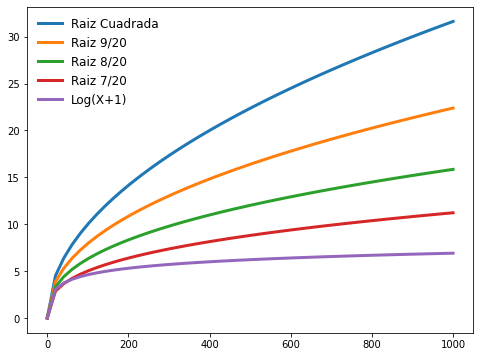

In [175]:
X = np.linspace(0, 1000, 50)
fig, ax = plt.subplots(figsize = (8, 6))
lw = 3
ax.plot(X, np.sqrt(X), label = 'Raiz Cuadrada', linewidth = lw)
ax.plot(X, X**(9/20), label = 'Raiz 9/20', linewidth = lw)
ax.plot(X, X**(8/20), label = 'Raiz 8/20', linewidth = lw)
ax.plot(X, X**(7/20), label = 'Raiz 7/20', linewidth = lw)
ax.plot(X, np.log(X+1), label = 'Log(X+1)', linewidth = lw)
plt.legend(frameon = False, fontsize = 12)

Observamos aquellos directores con el score más alto:

In [176]:
score_director.sort_values(by = 'director_score', ascending = False)[['name', 'director_score']].set_index('name').head(10)

,director_score
name,
John Ford,5.452754
Michael Curtiz,5.276510
Werner Herzog,5.255481
Alfred Hitchcock,5.198873
Woody Allen,5.153236
Jean-Luc Godard,5.094805
Georges Méliès,4.998201
Sidney Lumet,4.987233
Martin Scorsese,4.986395


El histograma de los scores se ve de la siguiente forma:

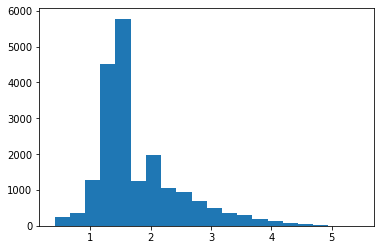

In [177]:
fig, ax = plt.subplots()
ax.hist(score_director.director_score, bins=20);

Podemos ocupar justamente la distribución implicita por el histograma como la probabilidad de recomendar una película con ese actor condicionado a que la película gustada contenga a tal actor. Por ejemplo, probando con actores reconocidos, esperaríamos que su probabilidad de ser recomendados sea alta:

In [178]:
score_director['prob'] = score_director['director_score']/score_director['director_score'].max()

directores_reconocidos = ['Quentin Tarantino', 'Tim Burton', 'Michael Bay', 'James Cameron', 'Martin Scorsese']

score_director[score_director['name'].isin(directores_reconocidos)][['name', 'prob']].sort_values(by = 'prob', ascending = False)

,name,prob
379,Martin Scorsese,0.914473
2844,Tim Burton,0.783934
403,Quentin Tarantino,0.689020
3561,James Cameron,0.683616
2641,Michael Bay,0.677642


Más adelante vimos que quiza el valor de la proba que tienen, para la forma en que se ocupará, tal vez sea muy alto. Por ello dejaremos algun parámetro que este entre 0 y 1 para reescalarlas:

In [179]:
directores_reconocidos = ['Quentin Tarantino', 'Tim Burton', 'Michael Bay', 'James Cameron', 'Martin Scorsese']

aux = score_director[score_director['name'].isin(directores_reconocidos)][['name', 'prob']].sort_values(by = 'prob', ascending = False)

factor_proba = 0.8
aux['prob'] = aux['prob']*factor_proba
aux

,name,prob
379,Martin Scorsese,0.731578
2844,Tim Burton,0.627147
403,Quentin Tarantino,0.551216
3561,James Cameron,0.546893
2641,Michael Bay,0.542114


Repetimos el proceso hecho con los actores (lo de la $X \sim Bin(N,r)$  y demás consideraciones), adaptándolo para que funcione con el director. En este caso, como solo hay un director, la $N$ en general será más grande:

In [180]:
from scipy.stats import binom

In [181]:
idx = 862 ### Es Toy Story

## Parámetros
N = 7
M = 14
factor_proba = 0.9

## Como solo nos interesan los renglones donde el director en efecto fungió como director
## (pues también pudo ser escritor, productor, etc.), filtramos de entrada estos renglones
aux = credits_crew[credits_crew['job'] == 'Director']

## Obtenemos los índices de los actores en la determinada película
director_idx = aux.set_index('id_credits').loc[idx]['id']

# Obtenemos la proba (score) del director
prob = score_director[score_director['id'] == director_idx]['prob'].iloc[0] 

# Obtenemos la cantidad k de películas por director aleatoriamente (a lo más N)
k_por_director = binom.rvs(N, prob*factor_proba)

# Obtenemos películas con el mismo director (quitando la misma película), y nos quedamos con el top M
top_10_por_director = aux[aux['id'] == director_idx].set_index('id_credits').drop(idx).iloc[:M]

# De las m <= M (porque puede que el director no tenga M otras películas) seleccionadas,
# obtenemos las k (con reemplazo porque si k > m truena) y quitamos los duplicados
recomendadas_por_director = top_10_por_director.sample(k_por_director, replace = True).drop_duplicates()

## Finalmente, unimos con el df de películas y obtenemos los títulos     
movies_metadata.join(recomendadas_por_director[['name']], on = "id", how = 'inner')[['original_title', 'name']].sort_values(by='name')

,original_title,name
2996,Toy Story 2,John Lasseter
10656,Luxo Jr.,John Lasseter
19160,Red's Dream,John Lasseter
22843,Mater and the Ghostlight,John Lasseter


Repetimos esto pero ya implementado en el script. Como es de esperarse, no serán las mismas siempre.

In [182]:
idx = 862 ### Es Toy Story

md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata, N = 7, M = 14, factor_proba = 0.9)

,original_title,name
2996,Toy Story 2,John Lasseter
10976,Cars,John Lasseter
22843,Mater and the Ghostlight,John Lasseter


Vemos las demas peliculas, ocupando los parámetros default( N = 7, M = 14 & factor_proba = 0.9):

In [183]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata)

Porque te gustó Donnie Darko:


,original_title,name
12187,Southland Tales,Richard Kelly
14413,The Box,Richard Kelly


In [184]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata)

Porque te gustó Toy Story:


,original_title,name
2241,A Bug's Life,John Lasseter
2996,Toy Story 2,John Lasseter
19210,Knick Knack,John Lasseter


In [185]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata)

Porque te gustó Reservoir Dogs:


,original_title,name
292,Pulp Fiction,Quentin Tarantino
6724,Kill Bill: Vol. 1,Quentin Tarantino
28119,The Hateful Eight,Quentin Tarantino
41221,My Best Friend's Birthday,Quentin Tarantino


In [186]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata)

Porque te gustó White Chicks:


,original_title,name
3939,I'm Gonna Git You Sucka,Keenen Ivory Wayans
4259,Scary Movie 2,Keenen Ivory Wayans


In [187]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata)

Porque te gustó Transformers: Dark of the Moon:


,original_title,name
716,The Rock,Michael Bay
1807,Armageddon,Michael Bay
6398,Bad Boys II,Michael Bay
10218,The Island,Michael Bay
11922,Transformers,Michael Bay
20792,Pain & Gain,Michael Bay


In [188]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendadas_por_director(idx, credits_crew, score_director, movies_metadata)

Porque te gustó Love & Other Drugs:


,original_title,name
637,Courage Under Fire,Edward Zwick
1197,Glory,Edward Zwick
33033,Pawn Sacrifice,Edward Zwick
41031,Jack Reacher: Never Go Back,Edward Zwick


## Idea #4 : Overview

Otra idea sería agrupar las películas con base en qué tan similar es el resumen (overview) de las mismas. Por ejemplo, si el overview de una contiene palabras como "amor", "ciudad", "drama", entonces con cierta probabilidad a esa persona le interesan esos temas.

In [189]:
movies_metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [190]:
overview = movies_metadata.copy()[['id', 'overview', 'original_title']]
overview = overview.drop_duplicates()

Vamos a convertir el vector de palabras de cada entrada de **overview** en un Term Frequency-Inverse Document Frequency (TF-IDF).

La frecuencia es la frecuencia relativa de una palabra en un documento y se da como instancia de: términos/ instancias totales.

La frecuencia inversa de frecuencia de documentos es el recuento relativo de documentos que contiene un registros: log(número de documentos / documentos con término).

La importancia general de cada palabra para los documentos en los que aparece es igual a la multiplicación de frecuencia de términos por la inversa de frecuencia de documentos(Term Frequency y Inverse Document Frequency): 
TF * IDF

Esto nos dará una matriz donde cada columna representa una palabra en el vocabulario general (todas las palabras que aparecen en al menos un documento) y cada fila representa una película, como antes. Esto se hace para reducir la importancia de las palabras que ocurren con frecuencia. en las descripciones generales de la trama y, por lo tanto, su importancia en el cálculo de la puntuación final de similitud.

In [191]:
#Importamos TfIdfVectorizer de scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos al TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Quitamos Nan con espacios vacíos
overview['overview'] = overview['overview'].fillna('')

#Construimos la matriz TF-IDF:
tfidf_matrix = tfidf.fit_transform(overview['overview'])

#La matriz tfidf_matrix tiene la siguiente forma:
tfidf_matrix.shape

(45430, 75827)

De esta forma, obtenemos la similaridad entre cada una de las 45433 películas con base en las 75827 palabras

In [192]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Construimos la matriz de similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.01503741 0.         ... 0.         0.00595357 0.        ]
 [0.01503741 1.         0.04680486 ... 0.         0.0219809  0.00929986]
 [0.         0.04680486 1.         ... 0.         0.01402332 0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.00595357 0.0219809  0.01402332 ... 0.         1.         0.        ]
 [0.         0.00929986 0.         ... 0.         0.         1.        ]]


Para realizar una función que tome como input el título de la película y nos arroje una lista de las 10 películas más parecidas, tenemos que identificar a cada película con un índice.

In [193]:
#Construimos un dataframe de título de película con su índice
indices = pd.Series(overview.index, index = overview['id']).drop_duplicates()
print(indices)

id
862           0
8844          1
15602         2
31357         3
11862         4
          ...  
439050    45438
111109    45439
67758     45440
227506    45441
461257    45442
Length: 45430, dtype: int64


Lo implementamos en el script:

In [194]:
idx = 862 ## Es Toy Story
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

id
10193                                      Toy Story 3
863                                        Toy Story 2
6957                            The 40 Year Old Virgin
82424                                        Small Fry
92848                      Andy Hardy's Blonde Trouble
181801                                      Hot Splash
364123                Andy Kaufman Plays Carnegie Hall
250434    Superstar: The Life and Times of Andy Warhol
355984    Andy Peters: Exclamation Mark Question Point
Name: original_title, dtype: object

Vemos las demas peliculas, ocupando n = 10 como default. Quiza este es el modelo para el cual menos intuitivamente se halle una clara relación a partir de las películas observadas:

In [195]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

Porque te gustó Donnie Darko:


id
64720                  Take Shelter
300090                 White Rabbit
58160               Little Hiawatha
10378                Big Buck Bunny
205076                  Not My Life
28969          The Velveteen Rabbit
81060                         Happy
46930                        Magnus
349045    Looney Tunes: Rabbits Run
Name: original_title, dtype: object

In [196]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

Porque te gustó Toy Story:


id
10193                                      Toy Story 3
863                                        Toy Story 2
6957                            The 40 Year Old Virgin
82424                                        Small Fry
92848                      Andy Hardy's Blonde Trouble
181801                                      Hot Splash
364123                Andy Kaufman Plays Carnegie Hall
250434    Superstar: The Life and Times of Andy Warhol
355984    Andy Peters: Exclamation Mark Question Point
Name: original_title, dtype: object

In [197]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

Porque te gustó Reservoir Dogs:


id
100914                Wuya yu maque
4564               Sex and the City
4883       And then there were none
357940                          老炮儿
43818           Pride and Prejudice
9438                      Mr. Magoo
59706                The Fatal Hour
8856        The Karate Kid, Part II
49848     Little Fish, Strange Pond
Name: original_title, dtype: object

In [198]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

Porque te gustó White Chicks:


id
40048                              In My Sleep
410126                           Patient Seven
8961                               Bad Boys II
48833                         Night Catches Us
53000                            Soul Assassin
771                                 Home Alone
87593                                    Kevin
13194     Highlander: The Search for Vengeance
117269                                 Lambada
Name: original_title, dtype: object

In [199]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

Porque te gustó Transformers: Dark of the Moon:


id
14517                                 Mirrormask
14539                                       江山美人
44773                 The 7 Adventures of Sinbad
47065                 Tales of an Ancient Empire
43689                            The Merry Widow
81541     Diario segreto da un carcere femminile
382523                                    Vaesen
26535                                 Billy Liar
141423                      The Legend of Mor'du
Name: original_title, dtype: object

In [200]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_overview(overview, idx, indices, cosine_sim = cosine_sim)['original_title']

Porque te gustó Love & Other Drugs:


id
117534      E Aí... Comeu?
358901    Film Kteer Kbeer
25659       Zenzen daijobu
28938         Männerherzen
41558      Separation City
20213          The Manxman
121652       Φτηνά Τσιγάρα
210302      Love's Routine
28858      Brothers at War
Name: original_title, dtype: object

No obstante, dado que ya tenemos la estructura para mezclar modelos y de asignarles parámetros para que regrese sólo algunos valores para cada modelo, podemos incluirlo e ir afinando tales probabilidades y parámetros hasta refinar el modelo final.

## Modelo Final

Hemos generado diversos modelos, cada uno enfocado a recomendar películas con base en un cierto criterio. En este punto, nos gustaría un modelo generalizado que pueda hacer recomendaciones de cada uno de los modelos particulares, para tratar de abarcar los diferentes gustos y preferencias de los usuarios.

El código ya había sido implementado previamente en la funcion mezcla_modelos, y solo lo actualizamos en la funcion modelo_final para permitirle cubrir cada modelo.

Definimos el vector de proporciones bajo el cual se seleccionarán las películas:

In [201]:
p = {'k-means_1': 0.2, 'k-means_2': 0.1, 'k-means_3': 0.05, 'hierarchical':0.2,
     'actores': 0.2,'director':0.2, 'overview': 0.05 }

### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
assert np.allclose(1, np.array(list(p.values())).sum())

Definimos los parámetros:

In [202]:
n_1 = 10 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 10 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
N_dir, M_dir, factor_proba_dir =  15, 25, 0.9 # Director
n_ov = 15 # Overview

Probamos con las películas que hemos estado revisando:

In [204]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Donnie Darko:


,original_title,model
15,Citizen Kane,k-means_1
14359,Doubt,k-means_1
9777,Proof,k-means_2
297,Meet Joe Black,hierarchical
9697,Lady in the Water,hierarchical
4226,Youngblood,actores
31960,10 Cent Pistol,actores
23545,For Ellen,actores
16828,Source Code,actores
26669,The Ballad of Lucy Whipple,actores


In [205]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Toy Story:


,original_title,model
93456,Despicable Me 2,k-means_1
11836,The SpongeBob SquarePants Movie,k-means_1
93456,Despicable Me 2,k-means_2
35,The Simpsons Movie,hierarchical
11836,The SpongeBob SquarePants Movie,hierarchical
1622,For Richer or Poorer,actores
414,The Beverly Hillbillies,actores
26106,Snowboard Academy,actores
38493,A Hologram for the King,actores
22186,The Rat Race,actores


In [206]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Reservoir Dogs:


,original_title,model
10909,Kalifornia,k-means_1
189,Sin City: A Dame to Kill For,k-means_1
276907,Legend,k-means_2
158011,The Call,hierarchical
199373,The Frozen Ground,hierarchical
42316,Amsterdam Heavy,actores
7171,Starsky & Hutch,actores
14695,Wrong Turn at Tahoe,actores
18740,The Bleeding,actores
34193,United Passions,actores


In [207]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó White Chicks:


,original_title,model
10327,"Legally Blonde 2: Red, White & Blonde",k-means_1
48988,Hall Pass,k-means_1
2018,The Wedding Planner,k-means_2
10327,"Legally Blonde 2: Red, White & Blonde",hierarchical
11007,Cheaper by the Dozen,hierarchical
404,Above the Rim,actores
3823,Requiem for a Dream,actores
23235,A Haunted House 2,actores
3662,Scary Movie,director
8961,Bad Boys II,overview


In [208]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Transformers: Dark of the Moon:


,original_title,model
49529,John Carter,k-means_1
1895,Star Wars: Episode III - Revenge of the Sith,k-means_1
49529,John Carter,k-means_2
13475,Star Trek,hierarchical
72545,Journey 2: The Mysterious Island,hierarchical
3560,Blood Simple,actores
3258,Der Unhold,actores
10368,Æon Flux,actores
20747,Educazione siberiana,actores
11743,Disturbia,actores


In [209]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Love & Other Drugs:


,original_title,model
7211,Dan in Real Life,k-means_1
38408,Life As We Know It,k-means_1
10184,He's Just Not That Into You,k-means_2
10184,He's Just Not That Into You,hierarchical
7211,Dan in Real Life,hierarchical
20499,Zig Zag,actores
21596,Prisoners,actores
33006,Everest,actores
13292,Passengers,actores
262,Legends of the Fall,director


## Pruebas/Encuesta

Ya hecho el modelo, queremos saber que tan efectivo es. Solicitamos la ayuda de diferentes personas para que nos dijeran alguna(s) película(s) y ver si el algoritmo lograba recomendarles otras que les pudieran interesar.

#### Rich

In [210]:
some_movies = {78 : 'Blade Runner', 
               147 : 'Les Quatre Cents Coups', # Los 400 Golpes
               2860 : 'Le genou de Claire'} # La Rodilla de Clara

In [211]:
idx = 78
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Blade Runner:


,original_title,model
14337,Primer,k-means_1
228066,Victor Frankenstein,k-means_1
39538,Contagion,k-means_2
97370,Under the Skin,hierarchical
2900,The Astronaut's Wife,hierarchical
344,Clear and Present Danger,actores
38812,Blind Side,actores
14948,Haunted Echoes,actores
35492,Das Amulett des Todes,actores
7343,Soldaat van Oranje,actores


In [212]:
idx = 147
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Les Quatre Cents Coups:


,original_title,model
133558,Saints and Soldiers: Airborne Creed,k-means_1
102000,L'enfant d'en haut,k-means_1
10613,The King Is Alive,k-means_2
10613,The King Is Alive,hierarchical
8319,Chapter 27,hierarchical
18962,Le ciel est à vous,actores
13727,Les deux Anglaises et le continent,actores
6982,Tirez sur le pianiste,director
9752,Domicile Conjugal,director
16932,Après vous...,overview


In [213]:
idx = 2860
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Le genou de Claire:


,original_title,model
50435,Bilitis,k-means_1
27030,Madame de…,k-means_1
27030,Madame de…,k-means_2
28209,Emmanuelle 2: L'antivierge,hierarchical
42726,Un Homme et une femme,hierarchical
10751,L'amour l'après-midi,actores
17821,The Romantic Englishwoman,actores
6102,Pauline à la plage,director
5230,L'Anglaise et le duc,director
385390,Love by Chance,overview


#### Mau

In [214]:
some_movies = {121 : 'The Lord of the Rings: The Two Towers',
               807 : 'Se7en',
               340666 : 'Nocturnal Animals',
               597 : 'Titanic', # De esta hay 3 llamadas igual, pero ese índice es la de 1997
               254320 : 'The Lobster', 
               } 

In [215]:
p = {'k-means_1': 1, 'k-means_2': 1, 'k-means_3': 0.05, 'hierarchical': 1,
     'actores': 0.5,'director':0.5, 'overview': 0.05 }

n_1 = 5 # K-Means 1
n_2 = 5 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 5 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 8, 15, 0.9, 5 # Actores
N_dir, M_dir, factor_proba_dir =  25, 40, 1 # Director
n_ov = 15 # Overview

In [216]:
idx = 121
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó The Lord of the Rings: The Two Towers:


,original_title,model
1930,The Amazing Spider-Man,k-means_1
209112,Batman v Superman: Dawn of Justice,k-means_1
120,The Lord of the Rings: The Fellowship of the Ring,k-means_1
102382,The Amazing Spider-Man 2,k-means_1
122,The Lord of the Rings: The Return of the King,k-means_1
122,The Lord of the Rings: The Return of the King,k-means_2
102382,The Amazing Spider-Man 2,k-means_2
1930,The Amazing Spider-Man,k-means_2
120,The Lord of the Rings: The Fellowship of the Ring,k-means_2
209112,Batman v Superman: Dawn of Justice,k-means_2


In [217]:
idx = 807
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Se7en:


,original_title,model
8224,8MM,k-means_1
320,Insomnia,k-means_1
3489,88 Minutes,k-means_1
16617,Mindhunters,k-means_1
70436,The Raven,k-means_1
8224,8MM,k-means_2
16617,Mindhunters,k-means_2
3489,88 Minutes,k-means_2
320,Insomnia,k-means_2
70436,The Raven,k-means_2


In [218]:
idx = 340666
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Nocturnal Animals:


,original_title,model
302401,Snowden,k-means_1
48231,A Dangerous Method,k-means_1
264644,Room,k-means_1
1700,Misery,k-means_1
293768,Kidnap,k-means_1
264644,Room,k-means_2
293768,Kidnap,k-means_2
48231,A Dangerous Method,k-means_2
1700,Misery,k-means_2
302401,Snowden,k-means_2


In [219]:
idx = 597
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó Titanic:


,original_title,model
4959,The International,k-means_1
43566,Before and After,k-means_1
45803,Svengali,k-means_1
4176,Murder on the Orient Express,k-means_1
32037,The Cassandra Crossing,k-means_1
11329,Runaway Jury,k-means_2
2502,The Bourne Supremacy,k-means_2
4959,The International,k-means_2
44214,Black Swan,k-means_2
4176,Murder on the Orient Express,k-means_2


In [220]:
idx = 254320
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                overview, indices, cosine_sim, n_ov, # Overview
                )

Porque te gustó The Lobster:


,original_title,model
9895,Man of the Year,k-means_1
121826,Quartet,k-means_1
4951,10 Things I Hate About You,k-means_1
88005,Seeking a Friend for the End of the World,k-means_1
55347,Beginners,k-means_1
350,The Devil Wears Prada,k-means_2
121826,Quartet,k-means_2
4951,10 Things I Hate About You,k-means_2
10497,Bitter Moon,k-means_2
392,Chocolat,k-means_2


#### Algunas lineas que sirvieron para encontrar las películas

In [221]:
import re
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Hobbi', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
8784,False,"{'id': 141290, 'name': 'The Lord of the Rings ...",3000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",NaN,1362,tt0077687,en,The Hobbit,Bilbo Baggins the Hobbit was just minding his ...,...,1977-11-27,0,77.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Hobbit,False,6.0,76
19964,False,"{'id': 121938, 'name': 'The Hobbit Collection'...",250000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.thehobbit.com/,49051,tt0903624,en,The Hobbit: An Unexpected Journey,"Bilbo Baggins, a hobbit enjoying his quiet lif...",...,2012-11-26,1021103568,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,From the smallest beginnings come the greatest...,The Hobbit: An Unexpected Journey,False,7.0,8427
22050,False,"{'id': 121938, 'name': 'The Hobbit Collection'...",250000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.thehobbit.com/,57158,tt1170358,en,The Hobbit: The Desolation of Smaug,"The Dwarves, Bilbo and Gandalf have successful...",...,2013-12-11,958400000,161.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beyond darkness... beyond desolation... lies t...,The Hobbit: The Desolation of Smaug,False,7.6,4633
25378,False,"{'id': 121938, 'name': 'The Hobbit Collection'...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.thehobbit.com/,122917,tt2310332,en,The Hobbit: The Battle of the Five Armies,Immediately after the events of The Desolation...,...,2014-12-10,956019788,144.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Witness the defining chapter of the Middle-Ear...,The Hobbit: The Battle of the Five Armies,False,7.1,4884


In [222]:
movies_metadata[movies_metadata['original_title'] == 'Se7en']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
46,False,NaN,33000000,"[{'id': 80, 'name': 'Crime'}, {'id': 9648, 'na...",http://www.sevenmovie.com/,807,tt0114369,en,Se7en,Two homicide detectives are on a desperate hun...,...,1995-09-22,327311859,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Seven deadly sins. Seven ways to die.,Se7en,False,8.1,5915


In [223]:
movies_metadata[movies_metadata['original_title'] == 'Titanic']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1638,False,NaN,200000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.titanicmovie.com,597,tt0120338,en,Titanic,"84 years later, a 101-year-old woman named Ros...",...,1997-11-18,1845034188,194.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Nothing on Earth could come between them.,Titanic,False,7.5,7770
3284,False,NaN,1805000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,16535,tt0046435,en,Titanic,"Unhappily married, Julia Sturges decides to go...",...,1953-04-11,4905000,98.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,TITANIC in Emotion...in Spectacle...in Climax....,Titanic,False,6.2,27
25461,False,NaN,13000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,2699,tt0115392,en,Titanic,A story of the romances of two couples upon th...,...,1996-11-17,0,173.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Titanic,False,6.3,45


In [224]:
movies_metadata[movies_metadata['original_title'] == 'Avengers: Age of Ultron']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
26546,False,"{'id': 86311, 'name': 'The Avengers Collection...",280000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,tt2395427,en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,...,2015-04-22,1405403694,141.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A New Age Has Come.,Avengers: Age of Ultron,False,7.3,6908


In [225]:
credits_crew[credits_crew['id_credits'] == 99861]

,credit_id,department,gender,id,job,name,profile_path,parent_id,id_credits
322454,55d5f7d4c3a3683e7e0016eb,Sound,2.0,531,Original Music Composer,Danny Elfman,/pWacZpYPos8io22nEiim7d3wp2j.jpg,26540,99861
322455,55f7d48892514103b60074ad,Sound,0.0,900,Supervising Sound Editor,Christopher Boyes,/qPYrAJif2AYqgUckgE9bEkjrdVw.jpg,26540,99861
322456,55f7d30d9251416d96004fd1,Sound,0.0,900,Sound Re-Recording Mixer,Christopher Boyes,/qPYrAJif2AYqgUckgE9bEkjrdVw.jpg,26540,99861
322457,550b070ec3a3684874001c9a,Production,1.0,7232,Casting,Sarah Finn,NaN,26540,99861
322458,55d5f7e2c3a3687b990044bd,Sound,2.0,6041,Original Music Composer,Brian Tyler,/22QWiNJj03amY6GT1QPUs7dbdcB.jpg,26540,99861
...,...,...,...,...,...,...,...,...,...
322523,55f7d4ffc3a3686d0300ccb4,Crew,0.0,1510438,Special Effects Coordinator,Ben Vokes,NaN,26540,99861
322524,55f7d85bc3a3686d2700bfe5,Camera,0.0,1510439,Camera Operator,Ki S. Hwang,NaN,26540,99861
322525,55f7d8f4c3a3686d2700bff5,Camera,0.0,1510440,Camera Operator,Derek Walker,NaN,26540,99861
322526,55f7d9b9c3a3680a0d00d53b,Camera,0.0,1510441,Still Photographer,Jae-Hyeok Lee,NaN,26540,99861


In [226]:
movies_metadata[movies_metadata['original_title'] == 'Nocturnal Animals']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
35337,False,NaN,22500000,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",http://www.focusfeatures.com/nocturnalanimals,340666,tt4550098,en,Nocturnal Animals,Susan Morrow receives a book manuscript from h...,...,2016-11-04,29252978,116.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,When you love someone you can't just throw it ...,Nocturnal Animals,False,7.2,1990


## Limitaciones

Derivado de esta breve encuesta, detectamos varias cosas en las que podemos mejorar y aumentar el modelo:

    1. Está tronando en Nocturnal Animals y The Lobster. Es muy probable que sea por temas de los modelos de actores y
        director, ya que al hacer el join con mean_ratings simplemente dejan de existir ciertas películas sin reseñas.
        Para esto una solución puede ser meter algo como try-except KeyError y solo no mostrar resultados (pues no hay)
        de actores y/o director. [Esto  ya dejó de tronar cuando corregimos los 3 renglones erroneos de movies_metadata]
    2. Los de K-Means y Hierarchical dan cosas buenas, pero al estar aleatoreizando dentro de las top n, estamos
        perdiendo buenas recomendaciones (nos gustaría quedarnos con las más más cercanas). Se soluciona si hacemos p_k=1.
    3. En LOTR, esperaríamos con mucha proba que recomendará las de The Hobbit, pero no lo hace. Una buena solución
        que ayudará a mejorar las recomendaciones de otras sería implmentar algo como el modelo de apriori tal que
        los "productos" i.e. actores de una película se parezcan a los de las demás, construyendo así una matriz
        de similitud por actores (tal vez también funcione si se hace como overview), donde la metrica sería del estilo
        cardinalidad de la interesección sobre cardinalidad de la unión.
        
En las siguientes celdas buscaremos solventar particularmente el punto 3, ya que los demás tienen que ver con ajustes en el script y este sí es una nueva implementación de modelo.

## Idea #5 : Coocurrencia de Actores

Al realizar la asociación por actores, nos dimos cuenta que a la gente no nceseariamente les interesa únicamente el hecho que se comparta un sólo actor pues las películas pueden ser considerablemente diferentes. Al mismo tiempo, nos dimos cuenta al analizar los resultados de LOTR que no salen recomendaciones obvias como lo son las películas de The Hobbit.

Estas dos limitaciones se pueden corregir si consideramos la coocurrencia de actores. Exploraremos opciones para ello, por ejemplo, alguna métrica del tipo:

$$\rho_{A,B} = \frac{|A\cap B|}{|A\cup B|}$$

donde $A$ y $B$ son los conjuntos de actores de dos películas diferentes.

Notamos que si la cardinaldad de la intersección es alta con respecto a la de la unión, entonces una gran cantidad del cast aparece en ambas, lo que sugiere ya sea que pertenecen a la misma saga o trilogía, o simplemente que ese conjunto de actores es muy parecido, ambas cosas pudiendo implicar que a la persona que le guste la película con los actores de $A$ le gusten los de $B$ y por ende, ambas películas.

Por ejemplo, obtenemos al conjunto de actores de Toy Story:

In [227]:
set(credits_cast[credits_cast['id_credits'] == 862]['name'])

{'Annie Potts',
 'Don Rickles',
 'Erik von Detten',
 'Jim Varney',
 'John Morris',
 'John Ratzenberger',
 'Laurie Metcalf',
 'Penn Jillette',
 'R. Lee Ermey',
 'Sarah Freeman',
 'Tim Allen',
 'Tom Hanks',
 'Wallace Shawn'}

Y lo generalizamos con el siguiente código:

In [228]:
conjunto_actores = credits_cast.groupby('id_credits')['name'].apply(lambda x : set(x))

In [229]:
conjunto_actores[862]

{'Annie Potts',
 'Don Rickles',
 'Erik von Detten',
 'Jim Varney',
 'John Morris',
 'John Ratzenberger',
 'Laurie Metcalf',
 'Penn Jillette',
 'R. Lee Ermey',
 'Sarah Freeman',
 'Tim Allen',
 'Tom Hanks',
 'Wallace Shawn'}

#### Nota: No obstante, no podemos ocupar al nombre del actor como identificador. Esto ya que puede que haya repetición de valores.

In [230]:
set(credits_cast[credits_cast['id_credits'] == 862]['id'])

{31,
 7167,
 7907,
 8655,
 8873,
 12133,
 12898,
 12899,
 12900,
 12901,
 12903,
 37221,
 1116442}

Y lo generalizamos con el siguiente código:

In [231]:
conjunto_actores_id = credits_cast.groupby('id_credits')['id'].apply(lambda x : set(x))

In [232]:
conjunto_actores_id[862]

{31,
 7167,
 7907,
 8655,
 8873,
 12133,
 12898,
 12899,
 12900,
 12901,
 12903,
 37221,
 1116442}

No obstante, hay algunas películas que NO tienen actores. Para estas, crearemos renglones falsos con conjuntos {0}, {-1},{-2} ... y así tal que no coincida con ninguno anterior:

In [233]:
movies_wo_actores = set(credits.id).symmetric_difference(set(credits_cast.id_credits))
print("Cantidad de películas sin actores: ", len(movies_wo_actores))

Cantidad de películas sin actores:  2414


In [234]:
aux = {id_credit : set([-k]) for k, id_credit in enumerate(movies_wo_actores)}
conjunto_actores_id = pd.concat([conjunto_actores_id, pd.Series(aux, name = 'id')]).sort_index()
conjunto_actores_id = conjunto_actores_id.rename_axis('id_credits')

Y vemos que ya tenemos a todos los renglones que necesitamos:

In [235]:
conjunto_actores_id.shape

(45429,)

In [236]:
credits.drop_duplicates(subset  = 'id', keep = 'first').shape

(45429, 3)

Para la métrica propuesta, ocuparemos el módulo itertools, tal que crucemos cada película:

In [237]:
import itertools

In [238]:
### Funciones auxiliares para determinar la cardinalidad de las intersecciones y uniones

def cardinalidad_interseccion(A, B):   
    return len(A.intersection(B))

def cardinalidad_union(A, B):  
    if len(A.union(B)) == 0:
        return 1
    else:
        return len(A.union(B))
    
def metrica_inter_union(A, B):
    return cardinalidad_interseccion(A, B)/cardinalidad_union(A, B)

In [239]:
### Dejamos como vestigio esta celda, que al momento de correrla tronó por Memory Error

# ### Aquí iremos guardando los valores de la intersección
# aux = []

# ### Aplicamos la función a cada pareja de películas (tarda como 10 minutos)
# for pair in itertools.product(np.array(conjunto_actores), repeat=2):
#     aux.append(cardinalidad_interseccion(*pair)/cardinalidad_union(*pair))

Hacemos una prueba con solo 1000 ya que tronó el intento anterior:

In [240]:
### Aquí iremos guardando los valores de la intersección
aux = []

### Aplicamos la función a cada pareja de películas (tarda como 10 minutos)
for pair in itertools.product(np.array(conjunto_actores_id)[:1000], repeat=2):
    aux.append(cardinalidad_interseccion(*pair)/cardinalidad_union(*pair))

In [241]:
### Le damos formato de matriz
# matriz_actores = np.array(aux).reshape(len(conjunto_actores), len(conjunto_actores))
matriz_actores = np.array(aux).reshape(1000, 1000)

In [242]:
### Pasamos a DataFrame para poder unir con lo demás
# df_actores = pd.DataFrame(matriz_actores, index = conjunto_actores.index, columns = conjunto_actores.index)
df_actores = pd.DataFrame(matriz_actores, index = conjunto_actores_id.index[:1000], columns = conjunto_actores_id.index[:1000])

Encontramos que la 193 tiene 2 películas muy similares:

In [243]:
df_actores[193][df_actores[193].apply(lambda x : x >= 0.3).sort_values()]

id_credits
193    1.000000
199    0.347826
200    0.333333
Name: 193, dtype: float64

En efecto, vemos que las 3 son películas de la saga Star Trek:

In [244]:
movies_metadata[movies_metadata['id'] == 193]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
324,False,"{'id': 115570, 'name': 'Star Trek: The Next Ge...",38000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",NaN,193,tt0111280,en,Star Trek: Generations,Captain Jean-Luc Picard and the crew of the En...,...,1994-11-17,120000000,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Boldly go.,Star Trek: Generations,False,6.4,461


In [245]:
movies_metadata[movies_metadata['id'] == 199]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1308,False,"{'id': 115570, 'name': 'Star Trek: The Next Ge...",46000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://www.startrek.com/startrek/view/series/M...,199,tt0117731,en,Star Trek: First Contact,"The Borg, a relentless race of cyborgs, are on...",...,1996-11-21,150000000,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Resistance is futile.,Star Trek: First Contact,False,7.0,671


In [246]:
movies_metadata[movies_metadata['id'] == 200]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
2279,False,"{'id': 115570, 'name': 'Star Trek: The Next Ge...",70000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",NaN,200,tt0120844,en,Star Trek: Insurrection,When an alien race and factions within Starfle...,...,1998-12-10,118000000,103.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The battle for paradise has begun.,Star Trek: Insurrection,False,6.3,402


### Idea análoga a TFidf

No podemos ocupar los pasos anteriores ya que truena por memoria. No obstante, TFidf realiza practicamente lo análogo a lo que queremos lograr, y lo hace con funciones optimizadas que quiza podemos ocupar para nuestro propósito:

In [247]:
### Auxiliar para convertir el cada set de números a una cadena de texto, tal que TFidf la reconozca
def set2str(a_set):
    s = ""
    for v in a_set:
        s += str(v) + ' '
    return s

In [248]:
conjunto_actores_id.apply(lambda x : set2str(x))

id_credits
2                                   54768 54769 4826 54770 
3              1086499 53508 1086500 5999 222320 4826 4828 
5         138 3122 3123 3124 3125 3126 3127 3128 3129 31...
6         2880 55964 121667 105988 52422 10822 1226696 1...
11        2 3 4 5 6 187398 390158 161301 216087 1178140 ...
                                ...                        
465044     1846625 1846626 1026286 1621486 1856334 1432275 
467731    2177 5251 178789 1698085 1217991 1517128 6442 ...
468343                                               -1500 
468707       232398 1810257 147734 1365271 1860857 1860858 
469172    1281664 1677062 1170198 5275 130715 73756 1506...
Name: id, Length: 45429, dtype: object

In [249]:
conjunto_actores_df = conjunto_actores_id.reset_index()
conjunto_actores_df['id'] = conjunto_actores_df['id'].apply(lambda x : set2str(x))
conjunto_actores_df = movies_metadata[['id', 'original_title']].join(conjunto_actores_df.reset_index().set_index('id_credits'), on = 'id', rsuffix = '_', how = 'inner')
conjunto_actores_df = conjunto_actores_df.drop_duplicates(subset = 'id')
conjunto_actores_df.drop('index', 1, inplace = True)
conjunto_actores_df.columns = ['id','original_title','pseudo_overview']
conjunto_actores_df

,id,original_title,pseudo_overview
0,862,Toy Story,12898 12899 12900 7907 12901 12133 12903 8873 ...
1,8844,Jumanji,188949 5149 25389 1235504 1480246 1483449 1483...
2,15602,Grumpier Old Men,16523 589 3151 16757 6837 7166 13567
3,31357,Waiting to Exhale,352 34 1276777 18284 87118 8851 9780 66804 108...
4,11862,Father of the Bride Part II,14592 24358 519 70696 18793 20906 54348 26510 ...
...,...,...,...
45438,439050,رگ خواب,240240 1619957 1749839
45439,111109,Siglo ng Pagluluwal,1728582 1042953 278923 1204271 1184497 1043186...
45440,67758,Betrayal,46277 55270 1736 51656 154762 2059 93930 16863...
45441,227506,Satana likuyushchiy,1136422 544742 1090923 29199 1261758


Realizamos todo de forma análoga:

In [250]:
#Importamos TfIdfVectorizer de scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos al TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf_actores = TfidfVectorizer(stop_words='english')

#Construimos la matriz TF-IDF:
tfidf_actores_matrix = tfidf_actores.fit_transform(conjunto_actores_df['pseudo_overview'])

#La matriz tfidf_matrix tiene la siguiente forma:
tfidf_actores_matrix.shape

(45429, 207157)

De esta forma, obtenemos la similaridad entre cada una de las 45433 películas con base en las 75827 palabras

In [251]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel
# from sklearn.metrics.pairwise import manhattan_distances
# from sklearn.metrics.pairwise import euclidean_distances


# Construimos la matriz de similitud de coseno
cosine_sim_actores = linear_kernel(tfidf_actores_matrix, tfidf_actores_matrix)
print(cosine_sim_actores)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Para realizar una función que tome como input el título de la película y nos arroje una lista de las 10 películas más parecidas, tenemos que identificar a cada película con un índice.

In [252]:
#Construimos un dataframe de título de película con su índice
indices_actores = pd.Series(conjunto_actores_df.index, index = conjunto_actores_df['id']).drop_duplicates()
print(indices_actores)

id
862           0
8844          1
15602         2
31357         3
11862         4
          ...  
439050    45438
111109    45439
67758     45440
227506    45441
461257    45442
Length: 45429, dtype: int64


Lo implementamos en el script:

Vemos las demas peliculas, ocupando n = 10 como default. Quiza este es el modelo para el cual menos intuitivamente se halle una clara relación a partir de las películas observadas:

In [253]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10, c = 0.05)['original_title']

Porque te gustó Donnie Darko:


21118     Waking Up in Reno
17532              S. Darko
108021    A Dangerous Woman
25196           Crazy Heart
17133             Homegrown
Name: original_title, dtype: object

In [254]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10, c = 0.05)['original_title']

Porque te gustó Toy Story:


863                       Toy Story 2
213121           Toy Story of Terror!
256835     Toy Story That Time Forgot
10193                     Toy Story 3
82424                       Small Fry
77887               Hawaiian Vacation
130925                Partysaurus Rex
15302                 The Pixar Story
18937               Quest for Camelot
37641     Elvis Has Left the Building
Name: original_title, dtype: object

In [255]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10, c = 0.05)['original_title']

Porque te gustó Reservoir Dogs:


44535              Somebody to Love
10614     My Best Friend's Birthday
14583                      Deceiver
15192                 The Grey Zone
409536              Horace and Pete
36606              Full Tilt Boogie
273248            The Hateful Eight
24235                      Champion
75490              Imaginary Crimes
680                    Pulp Fiction
Name: original_title, dtype: object

In [256]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10, c = 0.05)['original_title']

Porque te gustó White Chicks:


9072                                             Little Man
4247                                            Scary Movie
21724                                           Dance Flick
6217                                             Cat People
410315                                The Mistletoe Promise
10607     Don't Be a Menace to South Central While Drink...
184125                               Assault on Wall Street
9757                                                 Norbit
4248                                          Scary Movie 2
14938                                             The Alibi
Name: original_title, dtype: object

In [257]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10, c = 0.05)['original_title']

Porque te gustó Transformers: Dark of the Moon:


8373     Transformers: Revenge of the Fallen
1858                            Transformers
23127    The Haunted World of El Superbeasto
Name: original_title, dtype: object

In [258]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10 , c = 0.05)['original_title']

Porque te gustó Love & Other Drugs:


17133             Homegrown
32940      The Terminal Man
142      Brokeback Mountain
1551             Flatliners
Name: original_title, dtype: object

In [259]:
idx = 121
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.recomendacion_por_conjunto_actores(conjunto_actores_df, idx, indices_actores, cosine_sim_actores,
                                      credits, credits_cast, conjunto_actores_id, n_0 = 15000, n_f = 10, c = 0.05)['original_title']

Porque te gustó The Lord of the Rings: The Two Towers:


122           The Lord of the Rings: The Return of the King
120       The Lord of the Rings: The Fellowship of the Ring
49051                     The Hobbit: An Unexpected Journey
122917            The Hobbit: The Battle of the Five Armies
57158                   The Hobbit: The Desolation of Smaug
174487                                  True Love and Chaos
14440                                         The Tattooist
Name: original_title, dtype: object

### Reglas y Asociaciones

La idea de juntar actores también puede ser explorada desde los algoritmos Apriori, ECLAT y FPGrowth, considerando a cada item como un actor y a cada itemset como un conjunto de actores.

#### Nota: Esta idea se descartó tras releer lo que hacen los algoritmos.

Esto ya que si bien nos serviría para "vender" las películas con los actores más concurrentes, no nos dice nada sobre las películas con actores menos concurrentes, y queremos justo asociaciones entre todas las películas.

## Idea #6: Fuzzy C-Means
Como recomendación del profesor, probaremos usar Fuzzy C-Means, que es un algoritmo similar a K-Means. Para más detalle:

https://es.wikipedia.org/wiki/Fuzzy_clustering

Para comenzar, podríamos basarnos en el siguiente código:

https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html

#### Nota: Esta idea se dejará para alguna futura exploración

La razón es que los otros algoritmos ya nos están dando buenos resultados con los que estamos conformes. Sin duda la idea detreás de Fuzzy C-Means puede beneficiarnos, pero por motivos de tiempo lo dejaremos para una implementación futura.

# Modelo Final (Versión 2)

Habiendo corregido algunas cosas desde como procesábamos la base, realizando pruebas preguntando a conocidos e implementando el modelo de coocurrencia de actores, nos sentimos cómodos para definir de nuevo el modelo final. Este nuevamente tomará en cuenta recomendaciones por diferentes pesos. 

In [260]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 1, 
     'coocurrencia_actores': 0.7}

Definimos los parámetros:

In [261]:
n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
N_dir, M_dir, factor_proba_dir =  30, 50, 1# Director
n_ov = 15 # Overview
n_0, n_f, c = 15000, 10, 0.05 

Probamos con las películas que hemos estado revisando:

In [262]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Donnie Darko:


,original_title,model
1923,Twin Peaks: Fire Walk with Me,k-means_1
1939,Laura,k-means_1
1411,The Rapture,k-means_1
9777,Proof,k-means_1
297,Meet Joe Black,hierarchical
9667,The Jacket,hierarchical
137321,Winter's Tale,hierarchical
9697,Lady in the Water,hierarchical
14448,Brothers,actores
12187,Southland Tales,director


In [263]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Toy Story:


,original_title,model
863,Toy Story 2,k-means_1
93456,Despicable Me 2,k-means_1
585,"Monsters, Inc.",k-means_1
35,The Simpsons Movie,k-means_1
863,Toy Story 2,hierarchical
93456,Despicable Me 2,hierarchical
585,"Monsters, Inc.",hierarchical
35,The Simpsons Movie,hierarchical
10226,The Aristocrats,actores
1771,Quest for Camelot,actores


In [264]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Reservoir Dogs:


,original_title,model
10909,Kalifornia,k-means_1
158011,The Call,k-means_1
64689,Killing Them Softly,k-means_1
199373,The Frozen Ground,k-means_1
10909,Kalifornia,hierarchical
158011,The Call,hierarchical
64689,Killing Them Softly,hierarchical
199373,The Frozen Ground,hierarchical
530,Short Cuts,actores
550,True Romance,actores


In [265]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó White Chicks:


,original_title,model
2018,The Wedding Planner,k-means_1
32823,Get Him to the Greek,k-means_1
384682,Office Christmas Party,k-means_1
257091,Get Hard,k-means_1
2018,The Wedding Planner,hierarchical
32823,Get Him to the Greek,hierarchical
384682,Office Christmas Party,hierarchical
257091,Get Hard,hierarchical
32576,Tio Papi,actores
382,A Low Down Dirty Shame,director


In [266]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Transformers: Dark of the Moon:


,original_title,model
72545,Journey 2: The Mysterious Island,k-means_1
82700,After Earth,k-means_1
1895,Star Wars: Episode III - Revenge of the Sith,k-means_1
2135,The Time Machine,k-means_1
72545,Journey 2: The Mysterious Island,hierarchical
82700,After Earth,hierarchical
1895,Star Wars: Episode III - Revenge of the Sith,hierarchical
2135,The Time Machine,hierarchical
152,Beyond Rangoon,actores
30743,The Good Dinosaur,actores


In [267]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Love & Other Drugs:


,original_title,model
38408,Life As We Know It,k-means_1
11355,Never Been Kissed,k-means_1
82696,Hope Springs,k-means_1
76494,What to Expect When You're Expecting,k-means_1
38408,Life As We Know It,hierarchical
11355,Never Been Kissed,hierarchical
82696,Hope Springs,hierarchical
76494,What to Expect When You're Expecting,hierarchical
23213,Rio 2,actores
18247,The Dark Knight Rises,actores


## Pruebas/Encuesta

Ya hecho el modelo (versión 2), queremos saber que tan efectivo es. Solicitamos la ayuda de diferentes personas para que nos dijeran alguna(s) película(s) y ver si el algoritmo lograba recomendarles otras que les pudieran interesar.

#### Rich

In [268]:
some_movies = {78 : 'Blade Runner', 
               147 : 'Les Quatre Cents Coups', # Los 400 Golpes
               2860 : 'Le genou de Claire'} # La Rodilla de Clara

In [515]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 1,
     'director': 0.3, 
     'coocurrencia_actores': 0.7}

In [518]:
n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 5, 10, 1, 2 # Actores
N_dir, M_dir, factor_proba_dir =  30, 50, 1# Director
n_ov = 15 # Overview
n_0, n_f, c = 15000, 10, 0.05 

In [519]:
idx = 78
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Blade Runner:


,original_title,model
339988,The Circle,k-means_1
2900,The Astronaut's Wife,k-means_1
333371,10 Cloverfield Lane,k-means_1
49047,Gravity,k-means_1
339988,The Circle,hierarchical
2900,The Astronaut's Wife,hierarchical
333371,10 Cloverfield Lane,hierarchical
49047,Gravity,hierarchical
6334,Hollywood Homicide,actores
12622,Indiana Jones and the Kingdom of the Crystal S...,actores


In [271]:
idx = 147
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Les Quatre Cents Coups:


,original_title,model
8276,Il y a longtemps que je t'aime,k-means_1
102000,L'enfant d'en haut,k-means_1
9956,The Brave,k-means_1
10613,The King Is Alive,k-means_1
8276,Il y a longtemps que je t'aime,hierarchical
102000,L'enfant d'en haut,hierarchical
9956,The Brave,hierarchical
10613,The King Is Alive,hierarchical
2616,Jules et Jim,director
4582,L'Enfant sauvage,director


In [272]:
idx = 2860
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Le genou de Claire:


,original_title,model
27030,Madame de…,k-means_1
10239,Conte d'automne,k-means_1
50435,Bilitis,k-means_1
42726,Un Homme et une femme,k-means_1
27030,Madame de…,hierarchical
10239,Conte d'automne,hierarchical
50435,Bilitis,hierarchical
42726,Un Homme et une femme,hierarchical
10751,L'amour l'après-midi,actores
786,Les Rendez-vous de Paris,director


#### Mau

In [273]:
### Seleccionamos las peliculas
some_movies = {121 : 'The Lord of the Rings: The Two Towers',
               807 : 'Se7en',
               340666 : 'Nocturnal Animals',
               597 : 'Titanic', # De esta hay 3 llamadas igual, pero ese índice es la de 1997
               254320 : 'The Lobster', 
               } 

some_movies_df = pd.DataFrame(pd.Series(some_movies), columns = ['original_title']).join(
                    pd.DataFrame(km_model.predict(pre_clusters.loc[[key for key in some_movies.keys()]]), 
                                 index = some_movies.keys(), columns = ['cluster']))

some_movies_df

,original_title,cluster
121,The Lord of the Rings: The Two Towers,71
807,Se7en,89
340666,Nocturnal Animals,19
597,Titanic,60
254320,The Lobster,58


In [274]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 0.3, 
     'coocurrencia_actores': 0.7}

In [275]:
idx = 121
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Lord of the Rings: The Two Towers:


,original_title,model
120,The Lord of the Rings: The Fellowship of the Ring,k-means_1
122,The Lord of the Rings: The Return of the King,k-means_1
102382,The Amazing Spider-Man 2,k-means_1
209112,Batman v Superman: Dawn of Justice,k-means_1
120,The Lord of the Rings: The Fellowship of the Ring,hierarchical
122,The Lord of the Rings: The Return of the King,hierarchical
102382,The Amazing Spider-Man 2,hierarchical
209112,Batman v Superman: Dawn of Justice,hierarchical
10336,Everything is Illuminated,actores
42185,I Don't Feel at Home in This World Anymore,actores


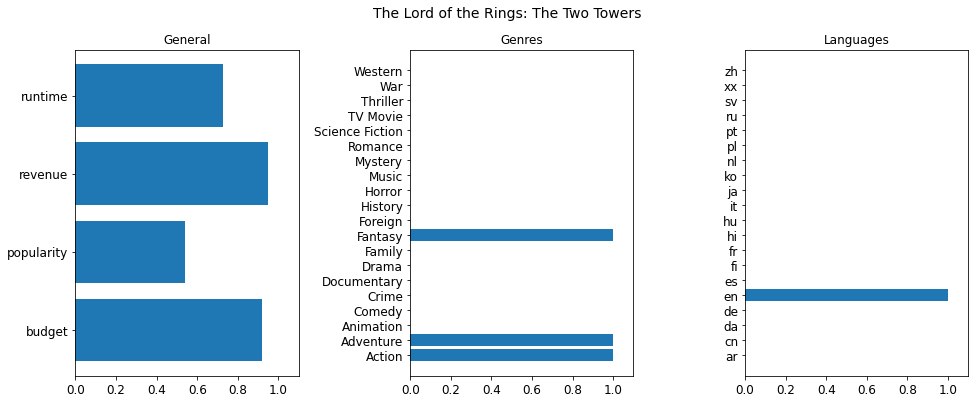

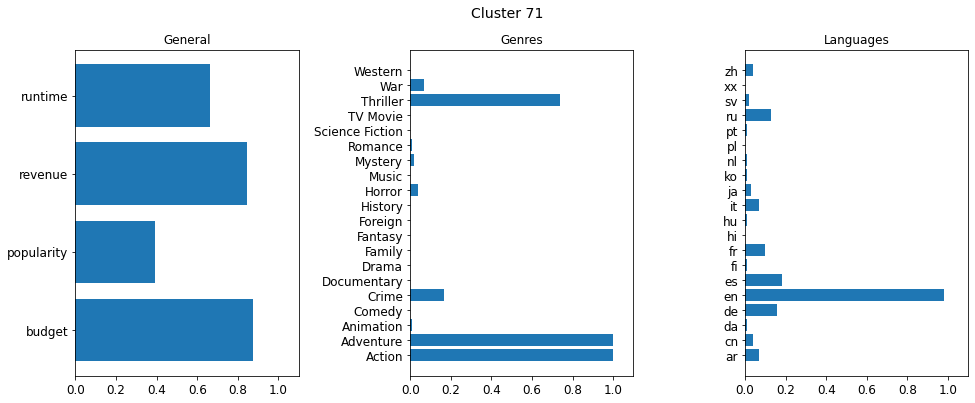

In [276]:
i = 121
md.plot_movie_info(movie_pre_cluster, some_movies_df.loc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters_1, some_movies_df.loc[i]['cluster'], meta_cat, genres_cat, languages_cat)

In [277]:
idx = 807
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Se7en:


,original_title,model
320,Insomnia,k-means_1
8224,8MM,k-means_1
70436,The Raven,k-means_1
3489,88 Minutes,k-means_1
320,Insomnia,hierarchical
8224,8MM,hierarchical
70436,The Raven,hierarchical
3489,88 Minutes,hierarchical
44281,War Machine,actores
18679,The Dark Side of the Sun,actores


In [278]:
idx = 340666
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Nocturnal Animals:


,original_title,model
293768,Kidnap,k-means_1
1700,Misery,k-means_1
302401,Snowden,k-means_1
264644,Room,k-means_1
293768,Kidnap,hierarchical
1700,Misery,hierarchical
302401,Snowden,hierarchical
264644,Room,hierarchical
43313,The Wall,actores
26546,Avengers: Age of Ultron,actores


In [279]:
idx = 597
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Titanic:


,original_title,model
4959,The International,k-means_1
32037,The Cassandra Crossing,k-means_1
4176,Murder on the Orient Express,k-means_1
43566,Before and After,k-means_1
2768,American Gigolo,hierarchical
2502,The Bourne Supremacy,hierarchical
296098,Bridge of Spies,hierarchical
48289,The Debt,hierarchical
501,Orlando,actores
24886,Darfur,actores


In [280]:
idx = 254320
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Lobster:


,original_title,model
88005,Seeking a Friend for the End of the World,k-means_1
55347,Beginners,k-means_1
4951,10 Things I Hate About You,k-means_1
121826,Quartet,k-means_1
88005,Seeking a Friend for the End of the World,hierarchical
84332,Safety Not Guaranteed,hierarchical
26454,Deliver Us from Eva,hierarchical
8067,A Life Less Ordinary,hierarchical
3824,Tigerland,actores
5310,Minority Report,actores


#### Player & Perrito

In [524]:
some_movies = {8835 : 'Legally Blonde',
               
               } 

some_movies_df = pd.DataFrame(pd.Series(some_movies), columns = ['original_title']).join(
                    pd.DataFrame(km_model_1.predict(pre_clusters.loc[[key for key in some_movies.keys()]]), 
                                 index = some_movies.keys(), columns = ['cluster']))

some_movies_df

,original_title,cluster
8835,Legally Blonde,22


In [282]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 0.3, 
     'coocurrencia_actores': 0.7}

In [525]:
idx = 8835
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Legally Blonde:


,original_title,model
16996,17 Again,k-means_1
88042,Parental Guidance,k-means_1
252838,The Wedding Ringer,k-means_1
195589,Neighbors,k-means_1
16996,17 Again,hierarchical
88042,Parental Guidance,hierarchical
252838,The Wedding Ringer,hierarchical
195589,Neighbors,hierarchical
6049,Old School,actores
6343,Alex & Emma,actores


#### Quique

In [281]:
some_movies = {12405 : 'Slumdog Millionaire',
               8054 : 'The Imaginarium of Doctor Parnassus',
               86837 : 'Amour',
               194 : 'Le fabuleux destin d\'Amélie Poulain', #Amelie
               } 

some_movies_df = pd.DataFrame(pd.Series(some_movies), columns = ['original_title']).join(
                    pd.DataFrame(km_model_1.predict(pre_clusters.loc[[key for key in some_movies.keys()]]), 
                                 index = some_movies.keys(), columns = ['cluster']))

some_movies_df

,original_title,cluster
12405,Slumdog Millionaire,78
8054,The Imaginarium of Doctor Parnassus,209
86837,Amour,155
194,Le fabuleux destin d'Amélie Poulain,346


In [282]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 0.3, 
     'coocurrencia_actores': 0.7}

In [283]:
idx = 12405
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Slumdog Millionaire:


,original_title,model
4347,Atonement,k-means_1
24803,Julie & Julia,k-means_1
1259,Notes on a Scandal,k-means_1
8291,Poetic Justice,k-means_1
228194,The Hundred-Foot Journey,hierarchical
191714,Dabba,hierarchical
14395,कभी अलविदा ना कहना,hierarchical
83902,ना तुम जानो ना हम,hierarchical
21930,Race,actores
315,Shallow Grave,director


In [284]:
idx = 8054
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Imaginarium of Doctor Parnassus:


,original_title,model
2268,The Golden Compass,k-means_1
35552,Les Aventures extraordinaires d'Adèle Blanc-Sec,k-means_1
11527,Excalibur,k-means_1
68737,Seventh Son,k-means_1
208763,Viy,hierarchical
2268,The Golden Compass,hierarchical
11527,Excalibur,hierarchical
68737,Seventh Son,hierarchical
21750,Muhammad Ali's Greatest Fight,actores
1006,The Sound of Music,actores


In [285]:
idx = 86837
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Amour:


,original_title,model
2767,Les Amants du Pont-Neuf,k-means_1
2002,Une vieille maîtresse,k-means_1
86331,Q,k-means_1
9302,Up Close & Personal,k-means_1
2767,Les Amants du Pont-Neuf,hierarchical
2002,Une vieille maîtresse,hierarchical
86331,Q,hierarchical
9302,Up Close & Personal,hierarchical
20726,Le Skylab,actores
5134,La Pianiste,director


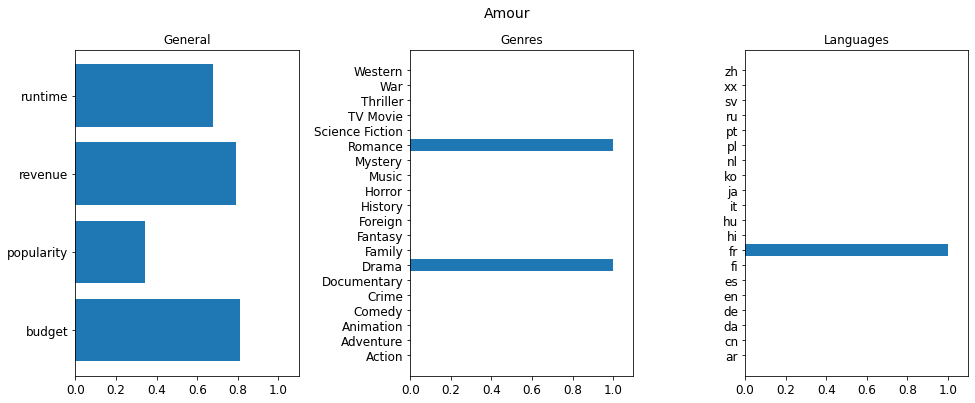

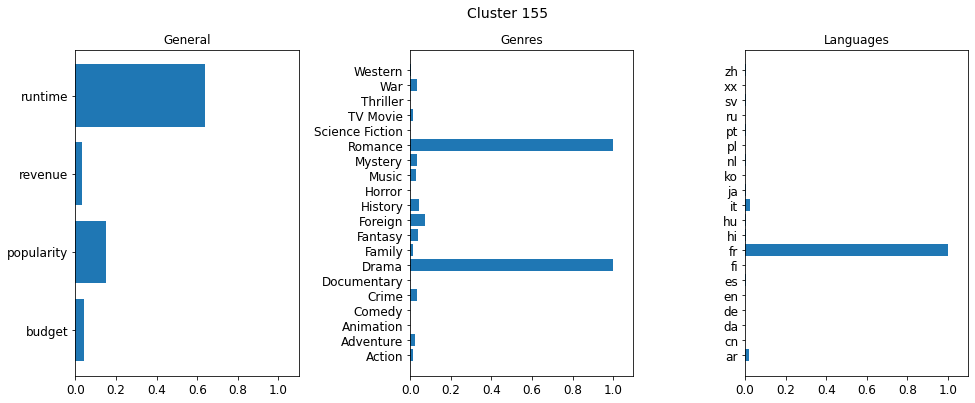

In [286]:
i = 86837
md.plot_movie_info(movie_pre_cluster, some_movies_df.loc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters_1, some_movies_df.loc[i]['cluster'], meta_cat, genres_cat, languages_cat)

In [287]:
idx = 194
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Le fabuleux destin d'Amélie Poulain:


,original_title,model
10761,Made of Honor,k-means_1
8265,Bienvenue chez les ch'tis,k-means_1
3981,What Women Want,k-means_1
22897,It's Complicated,k-means_1
155887,Un Prince (presque) charmant,hierarchical
127894,Do Not Disturb,hierarchical
50530,Tarif Novogodniy,hierarchical
57701,Na Kryuchke!,hierarchical
6024,À la folie... pas du tout,actores
28,La Cité des Enfants Perdus,director


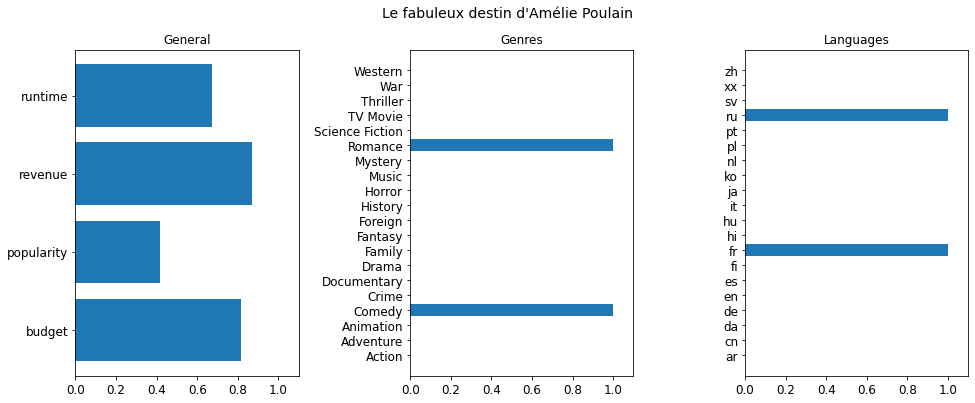

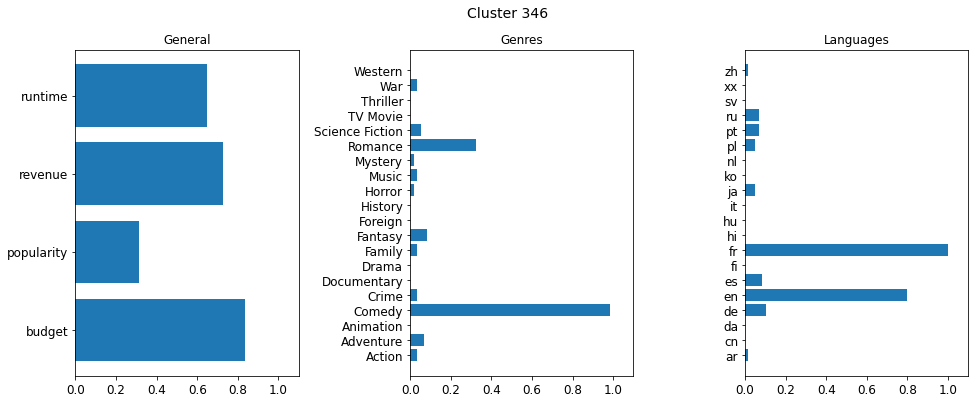

In [288]:
i = 194
md.plot_movie_info(movie_pre_cluster, some_movies_df.loc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters_1, some_movies_df.loc[i]['cluster'], meta_cat, genres_cat, languages_cat)

#### Nelson

In [289]:
some_movies = {18785 : 'The Hangover',
               473 : 'Pi'
               } 

In [290]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 0.3, 
     'coocurrencia_actores': 0.9}

In [291]:
n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
N_dir, M_dir, factor_proba_dir =  30, 50, 1# Director
n_ov = 15 # Overview
n_0, n_f, c = 15000, 10, 0.05 

n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
N_dir, M_dir, factor_proba_dir =  30, 50, 1# Director
n_ov = 15 # Overview
n_0, n_f, c = 15000, 20, 0.01

In [292]:
idx = 18785
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Hangover:


,original_title,model
38365,Grown Ups,k-means_1
109439,The Hangover Part III,k-means_1
225886,Sex Tape,k-means_1
227159,Horrible Bosses 2,k-means_1
38365,Grown Ups,hierarchical
109439,The Hangover Part III,hierarchical
225886,Sex Tape,hierarchical
227159,Horrible Bosses 2,hierarchical
4519,Wet Hot American Summer,actores
20961,The Hangover Part III,actores


In [345]:
idx = 18785
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
temp = md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Hangover:


In [346]:
df_byPage = temp.groupby(by = 'original_title').count()
df_byPage.sort_values(by = 'model', ascending=False).head(50)
# df_byPage

,model
original_title,
Grown Ups,2
Horrible Bosses 2,2
Sex Tape,2
The Hangover Part III,2
National Treasure,1
Old School,1
School for Scoundrels,1
Starsky & Hutch,1
The Hangover Part II,1


In [293]:
idx = 473
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó Pi:


,original_title,model
996,Double Indemnity,k-means_1
4174,Spellbound,k-means_1
567,Rear Window,k-means_1
26388,Buried,k-means_1
996,Double Indemnity,hierarchical
4174,Spellbound,hierarchical
567,Rear Window,hierarchical
26388,Buried,hierarchical
3823,Requiem for a Dream,actores
3823,Requiem for a Dream,director


#### Adrián

In [294]:
some_movies = {694 : 'The Shining',
               9552 : 'The Exorcist'
               } 

some_movies_df = pd.DataFrame(pd.Series(some_movies), columns = ['original_title']).join(
                    pd.DataFrame(km_model_1.predict(pre_clusters.loc[[key for key in some_movies.keys()]]), 
                                 index = some_movies.keys(), columns = ['cluster']))

some_movies_df

,original_title,cluster
694,The Shining,53
9552,The Exorcist,305


In [295]:
### Que sume 1 no es fundamental pues no dependemos, pero es deseable para darle interpretación como proporciones
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.8,
     'director': 1, 
     'coocurrencia_actores': 0.6}

In [296]:
n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 4, 4, 1, 4 # Actores
N_dir, M_dir, factor_proba_dir =  5, 5, 1 # Director
n_ov = 15 # Overview
n_0, n_f, c = 15000, 10, 0.05 

# n_1 = 20 # K-Means 1
# n_2 = 10 # K-Means 2
# n_3 = 10 # K-Means 3
# n_h = 20 # Hierarchical Clustering
# N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
# N_dir, M_dir, factor_proba_dir =  30, 50, 1# Director
# n_ov = 15 # Overview
# n_0, n_f, c = 15000, 20, 0.01

In [297]:
idx = 694
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Shining:


,original_title,model
9792,The Hills Have Eyes,k-means_1
11351,Jeepers Creepers 2,k-means_1
17692,Jaws 3-D,k-means_1
292280,The Bye Bye Man,k-means_1
9792,The Hills Have Eyes,hierarchical
11351,Jeepers Creepers 2,hierarchical
17692,Jaws 3-D,hierarchical
292280,The Bye Bye Man,hierarchical
77,The Crossing Guard,actores
6844,Hoffa,actores


In [338]:
idx = 694
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
temp = md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Shining:


In [344]:
df_byPage = temp.groupby(by = 'original_title').count()
df_byPage.sort_values(by = 'model', ascending=False).head(50)
# df_byPage

,model
original_title,
The Bye Bye Man,2
The Hills Have Eyes,2
Jaws 3-D,2
Jeepers Creepers 2,2
2001: A Space Odyssey,1
The Terror,1
The King of Marvin Gardens,1
The Fortune,1
The Crossing Guard,1


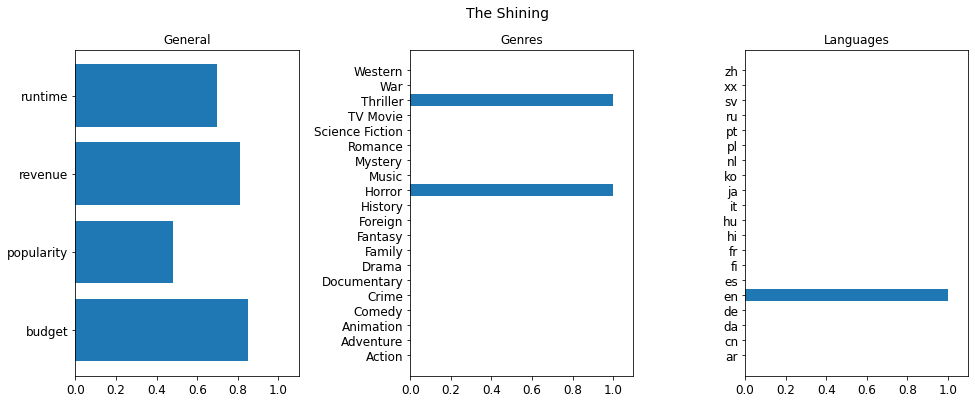

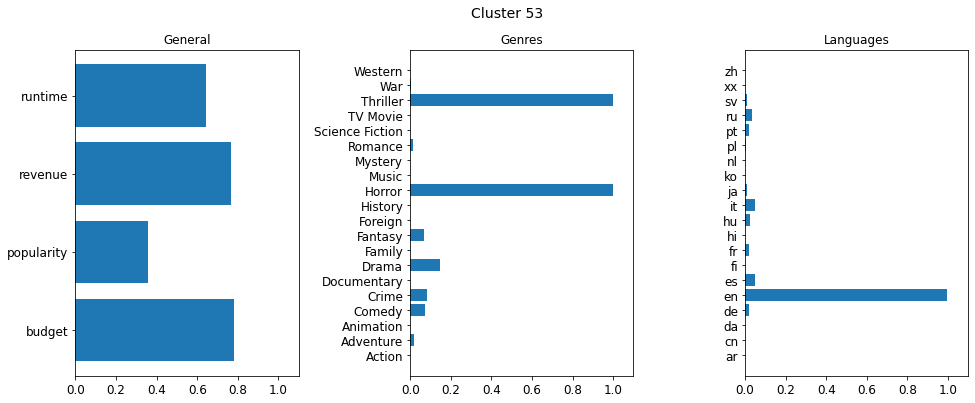

In [298]:
i = 694
md.plot_movie_info(movie_pre_cluster, some_movies_df.loc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters_1, some_movies_df.loc[i]['cluster'], meta_cat, genres_cat, languages_cat)

In [299]:
idx = 9552
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v2(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c  # Coocurrencia Actores
                )

Porque te gustó The Exorcist:


,original_title,model
52001,Citadel,k-means_1
25894,Above Suspicion,k-means_1
43566,Before and After,k-means_1
11222,Der amerikanische Freund,k-means_1
332567,The Shallows,hierarchical
65086,The Woman in Black,hierarchical
10065,The Amityville Horror,hierarchical
10320,The Ring Two,hierarchical
3823,Requiem for a Dream,actores
12770,The Stone Angel,actores


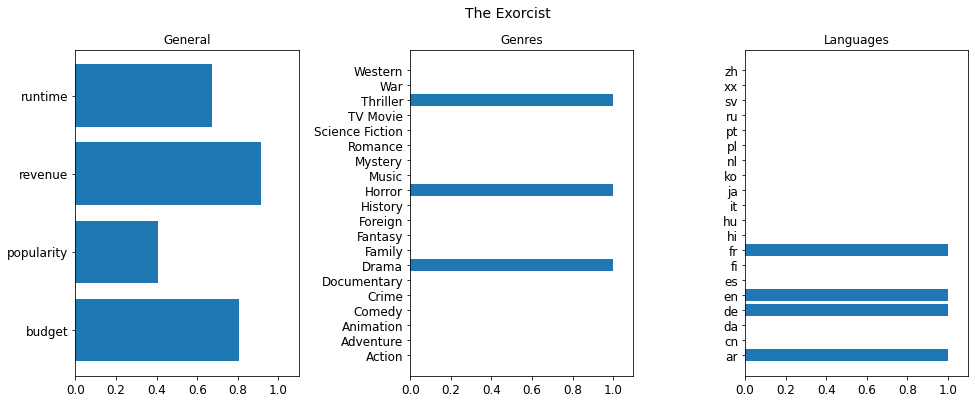

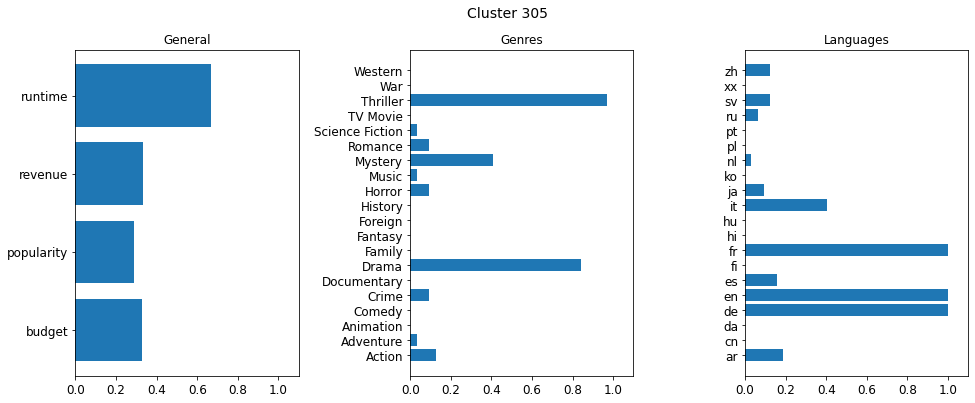

In [300]:
i = 9552
md.plot_movie_info(movie_pre_cluster, some_movies_df.loc[i]['original_title'], meta_cat, genres_cat, languages_cat)
md.plot_cluster_info(clusters_1, some_movies_df.loc[i]['cluster'], meta_cat, genres_cat, languages_cat)

#### Algunas lineas que sirvieron para encontrar las películas

In [301]:
import re
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Slumdog Millionaire', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
13057,False,NaN,15000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.foxsearchlight.com/slumdogmillionaire,12405,tt1010048,en,Slumdog Millionaire,Jamal Malik is an impoverished Indian teen who...,...,2008-05-12,377910544,120.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,What does it take to find a lost love? A. Mone...,Slumdog Millionaire,False,7.6,2918


In [302]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Parnassus', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
13910,False,NaN,30000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://doctorparnassus.com/,8054,tt1054606,en,The Imaginarium of Doctor Parnassus,A traveling theater company gives its audience...,...,2009-10-01,64352607,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,The Imaginarium of Doctor Parnassus,False,6.3,885


In [303]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Isle', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1368,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}, {'id': 104...",NaN,74239,tt0117028,en,Message to Love: The Isle of Wight Festival,"In August 1970, 600,000 fans flocked to the Is...",...,1996-02-15,0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Message to Love: The Isle of Wight Festival,False,6.4,4
8430,False,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,30348,tt0037820,en,Isle of the Dead,"On a Greek island during the 1912 war, several...",...,1945-09-01,0,71.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Will keep you screaming!,Isle of the Dead,False,5.6,20
19501,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://www.magpictures.com/themagicofbelleisle/,101731,tt1839654,en,The Magic of Belle Isle,"In an effort to tap into his original talent, ...",...,2012-07-06,102388,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Re-Coming of Age Story.,The Magic of Belle Isle,False,7.0,91
22471,False,NaN,0,[],NaN,170399,tt0101970,en,Grand Isle,A married woman in 1890s Louisiana meets a han...,...,1991-08-23,0,112.0,[],Released,Her unfulfilled passion was awakened on...,Grand Isle,False,0.0,0
29696,False,NaN,0,"[{'id': 10402, 'name': 'Music'}, {'id': 99, 'n...",http://www.thewho.com/listening-to-you-the-who...,54002,tt0116891,en,Listening to You: The Who Live at the Isle of ...,Mod rockers the Who are captured live by direc...,...,1998-11-03,0,85.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Listening to You: The Who Live at the Isle of ...,True,4.8,2
37811,False,NaN,0,"[{'id': 12, 'name': 'Adventure'}]",NaN,121848,tt0027805,en,Isle of Fury,An island fugitive (Humphrey Bogart) and his b...,...,1936-10-10,0,60.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Isle of Fury,False,0.0,0


In [523]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Legally', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
4318,False,"{'id': 86024, 'name': 'Legally Blonde Collecti...",18000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,8835,tt0250494,en,Legally Blonde,Elle Woods has it all. She's the president of ...,...,2001-07-13,141774679,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Don't judge a book by its hair color!,Legally Blonde,False,6.2,908
6385,False,"{'id': 86024, 'name': 'Legally Blonde Collecti...",45000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,10327,tt0333780,en,"Legally Blonde 2: Red, White & Blonde","After Elle Woods, the eternally perky, fashion...",...,2003-07-02,124914842,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Bigger. Bolder. Blonder.,"Legally Blonde 2: Red, White & Blonde",False,5.2,386
22155,False,"{'id': 86024, 'name': 'Legally Blonde Collecti...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,16985,tt1015999,en,Legally Blondes,"Moving from England to California, the younges...",...,2009-04-28,0,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Legally Blondes,False,4.4,48


In [304]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Hangover', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
13579,False,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,35849,tt0037761,en,Hangover Square,A composer who can't control his creative temp...,...,1945-10-29,0,77.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Hangover Square,False,5.0,10
13742,False,"{'id': 86119, 'name': 'The Hangover Collection...",35000000,"[{'id': 35, 'name': 'Comedy'}]",http://hangoverpart2.warnerbros.com/dvd/,18785,tt1119646,en,The Hangover,When three friends finally come to after a rau...,...,2009-06-05,459270619,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some guys just can't handle Vegas.,The Hangover,False,7.2,6324
17131,False,"{'id': 86119, 'name': 'The Hangover Collection...",80000000,"[{'id': 35, 'name': 'Comedy'}]",http://hangoverpart2.warnerbros.com/,45243,tt1411697,en,The Hangover Part II,The Hangover crew heads to Thailand for Stu's ...,...,2011-05-25,254455986,102.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Wolfpack Is Back,The Hangover Part II,False,6.2,3836
18123,False,NaN,0,[],NaN,238616,tt0042247,en,The Big Hangover,A young law school graduate is hired by a pres...,...,1950-05-26,0,82.0,[],Released,NaN,The Big Hangover,False,0.0,0
20961,False,"{'id': 86119, 'name': 'The Hangover Collection...",103000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,109439,tt1951261,en,The Hangover Part III,"This time, there's no wedding. No bachelor par...",...,2013-05-23,362000072,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It all ends.,The Hangover Part III,False,6.0,2991


In [305]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Shining', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1213,False,NaN,19000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,694,tt0081505,en,The Shining,Jack Torrance accepts a caretaker job at the O...,...,1980-05-22,44017374,144.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A masterpiece of modern horror.,The Shining,False,8.1,3890
9010,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,31962,tt0105391,en,Shining Through,Spirited New Yorker Linda Voss goes to work fo...,...,1992-01-31,21621000,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,He needed to trust her with his secret. She ha...,Shining Through,False,6.2,34
20604,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,206266,tt2073077,en,Shining Night: A Portrait of Composer Morten L...,"A tribute to a living legend, celebrating the ...",...,2012-02-07,0,74.0,[],Released,NaN,Shining Night: A Portrait of Composer Morten L...,False,0.0,0
25865,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,78531,tt0468528,en,One Bright Shining Moment,ONE BRIGHT SHINING MOMENT retraces George McGo...,...,2005-09-16,15504,123.0,[],Released,"For once in American politics, sunshine and li...",One Bright Shining Moment,False,0.0,1
28711,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.imdb.com/title/tt0126220/,13923,tt0126220,en,A Bright Shining Lie,Something in his past keeps career Army man Jo...,...,1998-01-01,0,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,"In war as in life, the difference between trut...",A Bright Shining Lie,False,6.1,7


In [306]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Exorcist', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1887,False,"{'id': 12263, 'name': 'The Exorcist Collection...",8000000,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",http://theexorcist.warnerbros.com/,9552,tt0070047,en,The Exorcist,12-year-old Regan MacNeil begins to adapt an e...,...,1973-12-26,441306145,122.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,Something almost beyond comprehension is happe...,The Exorcist,False,7.5,2046
1888,False,"{'id': 12263, 'name': 'The Exorcist Collection...",14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,11586,tt0076009,en,Exorcist II: The Heretic,Bizarre nightmares plague Regan MacNeil four y...,...,1977-06-17,30749142,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,It's four years later... what does she remember?,Exorcist II: The Heretic,False,4.5,137
1889,False,"{'id': 12263, 'name': 'The Exorcist Collection...",0,"[{'id': 53, 'name': 'Thriller'}, {'id': 27, 'n...",NaN,11587,tt0099528,en,The Exorcist III,"Set fifteen years after the original film, The...",...,1990-08-17,39024251,110.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Do you dare walk these steps again?,The Exorcist III,False,6.1,135
8087,False,"{'id': 12263, 'name': 'The Exorcist Collection...",80000000,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,11026,tt0204313,en,Exorcist: The Beginning,Having lived through traumatizing events durin...,...,2004-08-20,78000586,114.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Go back to where the horror began.,Exorcist: The Beginning,False,4.7,189
10092,False,"{'id': 12263, 'name': 'The Exorcist Collection...",30000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",NaN,12700,tt0449086,en,Dominion: Prequel to the Exorcist,Having lived through traumatizing events durin...,...,2005-05-20,251495,117.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Go back before the beginning, to the place whe...",Dominion: Prequel to the Exorcist,False,4.8,77


In [307]:
movies_metadata[movies_metadata['original_title'] == 'Pi']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
1811,False,NaN,60000,"[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...",http://www.pithemovie.com/,473,tt0138704,en,Pi,The debut film from Darren Aronofsky in which ...,...,1998-07-10,3221152,84.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"There will be no order, only chaos",Pi,False,7.1,600


In [308]:
movies_metadata[movies_metadata['original_title'] == 'Amour']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19765,False,NaN,8900000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,86837,tt1602620,fr,Amour,Georges and Anne are in their eighties. They a...,...,2012-07-01,29844753,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Amour,False,7.5,413


In [309]:
movies_metadata[movies_metadata['original_title'].apply(lambda x : isinstance(re.search('Amel', x), re.Match))]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
14303,False,NaN,40000000,"[{'id': 12, 'name': 'Adventure'}]",http://www.foxsearchlight.com/amelia/,8915,tt1129445,en,Amelia,A look at the life of legendary American pilot...,...,2009-10-22,19258519,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Amelia,False,5.4,71
29355,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 18,...",NaN,265741,tt0109096,en,Amelia Earhart: The Final Flight,A telling of the story of the famous U.S. avia...,...,1994-06-12,0,95.0,[],Released,NaN,Amelia Earhart: The Final Flight,False,0.0,0
33568,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,158939,tt0088149,en,Something About Amelia,The movie follows the Bennett family after Ame...,...,1984-01-09,0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Something About Amelia,False,6.5,1


In [310]:
credits_cast[credits_cast['name'].apply(lambda x : isinstance(re.search('Audrey Tautou', x), re.Match))]

,cast_id,character,credit_id,gender,id,name,order,profile_path,parent_id,id_credits,order_metric,order_metric2
82736,4.0,Amélie Poulain,52fe4225c3a36847f800779b,1.0,2405,Audrey Tautou,0.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,4842,194,1.000000,1.000000
95140,1001.0,Michèle,52fe4534c3a368484e04dd9d,1.0,2405,Audrey Tautou,0.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,5674,27204,1.000000,1.000000
100423,9.0,Angélique,52fe44b79251416c7503e8d5,1.0,2405,Audrey Tautou,0.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,6024,12112,1.000000,1.000000
103341,3.0,Martine,52fe42fdc3a36847f803217d,1.0,2405,Audrey Tautou,1.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,6225,1555,0.950000,0.950000
106191,12.0,Senay,52fe4394c3a36847f805f2e5,1.0,2405,Audrey Tautou,1.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,6402,3472,0.923077,0.923077
129119,1.0,NaN,52fe44aec3a368484e030d7b,1.0,2405,Audrey Tautou,0.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,7848,24908,1.000000,1.000000
149379,1.0,Marie,52fe451e9251416c9102809f,1.0,2405,Audrey Tautou,0.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,9173,33491,1.000000,1.000000
151998,8.0,Mathilde,52fe4370c3a36847f80542c5,1.0,2405,Audrey Tautou,0.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,9396,2841,1.000000,1.000000
159040,3.0,Huguette Verberie,52fe480ec3a36847f815605d,1.0,2405,Audrey Tautou,2.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,9894,51945,0.714286,0.714286
163699,8.0,Martine,52fe4318c3a36847f8039c6b,1.0,2405,Audrey Tautou,2.0,/pKfmpmZgH2LDPK4l1GbtnCWTukf.jpg,10200,1826,0.925926,0.925926


In [311]:
movies_metadata[movies_metadata['id'] == 194]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
4842,False,NaN,10000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www.die-fabelhafte-welt-der-amelie.de,194,tt0211915,fr,Le fabuleux destin d'Amélie Poulain,"At a tiny Parisian café, the adorable yet pain...",...,2001-04-25,173921954,122.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,One person can change your life forever.,Amélie,False,7.8,3403


## Idea #7 : Popularidad

Esta idea se agrega para tomar en cuenta promedio de votos:

$$ \frac{v}{m+v}R + \frac{m}{m+v}C$$

<br>
<center>
$v$  es el número de votos que tiene la película;
</center>
<br>
<center>
$m$  es el mínimo de votos requeridos para poder aparecer en nuestra recomendación;
</center>
<br>
<center>
$R$  es la calificación promedio de la película;
</center>
<br>
<center>
$C$ es el promedio general de todas las películas
</center>
<br>
Observamos que si la película casi no tiene votos, entonces se le asigna mayor ponderación al promedio general, y conforme el número de votos crece, se le va asignando mayor peso a la clasificación de la película.

In [591]:
m = movies_metadata['vote_count'].quantile(0.5) # El 0.5 es hiperparámetro
C = movies_metadata['vote_average'].mean() 

In [584]:
def promedio_ponderado(x, m = m, C = C):    
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [610]:
pop_metric = movies_metadata.set_index('id').apply(lambda x : promedio_ponderado(x), 1)
pop_metric = pd.concat([pd.DataFrame(pop_metric),movies_metadata.set_index('id')[['original_title']]], 1)
pop_metric.columns = ['pop_metric', 'original_title']

In [611]:
pop_metric.head()

,pop_metric,original_title
id,,
862,7.668947,Toy Story
8844,6.857876,Jumanji
15602,6.084491,Grumpier Old Men
31357,5.759496,Waiting to Exhale
11862,5.673731,Father of the Bride Part II


Podemos hacer ahora dos cosas, ambas igual de validas para el propósito que quieren cumplir:

    1. Recomendar las más populares. Si bien esto ignora la(s) película(s) que ha visto la persona, puede ser efectivo recomendarlo como el "Top 10 de películas en México" que hace Netflix, o bien que esa recomendación aparezca en la parte de "Trending". Cabe notar que hay muchas mejoras que hacer, por ejemplo, en vez de tomar el rating promedio de toda la historia, podría ser mejor tomar los ratings recientes, así como la cantidad de los recientes. O bien, tomar los ratings recientes de otras películas relativas al año de lanzamiento de esa película. En si, localizar los ratings más allá de solo tomar el promedio.
    
    2. Dada una película, localizar a las del mismo cluster, y dentro de ese cluster recomendar las más populares.

Este en si nunca va a cambiar porque ordenamos de todas las películas. Por eso en alguna mejora futura nos gustaría tomar en cuenta cierta localidad en cuestión de fechas.

In [613]:
pop_metric.sort_values(by = 'pop_metric', ascending = False).head(10)

,pop_metric,original_title
id,,
19404,8.715749,Dilwale Dulhania Le Jayenge
278,8.472003,The Shawshank Redemption
238,8.461301,The Godfather
372058,8.287501,君の名は。
155,8.282196,The Dark Knight
550,8.277469,Fight Club
680,8.274874,Pulp Fiction
424,8.251328,Schindler's List
244786,8.250673,Whiplash


Y este sí cambia dado el cluster:

In [635]:
idx = 862
aux = movie_clusters_1.loc[idx]['cluster']
aux = movie_clusters_1[movie_clusters_1['cluster'] == aux][['original_title']]
pop_metric.join(aux, on = 'id', rsuffix = '_').dropna().sort_values(
    by = 'pop_metric', ascending = False)[['pop_metric','original_title']].head(10)

,pop_metric,original_title
id,,
150540,7.872562,Inside Out
862,7.668947,Toy Story
10193,7.566090,Toy Story 3
585,7.475241,"Monsters, Inc."
863,7.265491,Toy Story 2
771,7.052706,Home Alone
93456,6.976450,Despicable Me 2
116149,6.884507,Paddington
35,6.856517,The Simpsons Movie


Al momento solo implementaremos en el script el segundo caso (tomando en cuenta cluster), pues el primero en si nunca cambia y además dentro de la interfaz del sistema de recomendación se haría saber que son recomendaciones por "Tendencias" y no necesariamente por quien es la persona o qué película ha visto

In [640]:
idx = 862
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

,original_title,pop_metric
id,,
150540,Inside Out,7.872562
10193,Toy Story 3,7.566090
585,"Monsters, Inc.",7.475241
863,Toy Story 2,7.265491
771,Home Alone,7.052706
93456,Despicable Me 2,6.976450
116149,Paddington,6.884507
35,The Simpsons Movie,6.856517
14306,Marley & Me,6.828698


Verificamos con las películas que hemos venido analizando:

In [645]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

Porque te gustó Donnie Darko:


,original_title,pop_metric
id,,
15,Citizen Kane,7.852716
1923,Twin Peaks: Fire Walk with Me,7.030140
1939,Laura,6.962751
14359,Doubt,6.785012
5165,L'avventura,6.783425
5961,Fanny och Alexander,6.673189
9270,Brick,6.583709
249397,Nymphomaniac: Vol. II,6.510756
280996,Mr. Holmes,6.405861


In [646]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

Porque te gustó Toy Story:


,original_title,pop_metric
id,,
150540,Inside Out,7.872562
10193,Toy Story 3,7.566090
585,"Monsters, Inc.",7.475241
863,Toy Story 2,7.265491
771,Home Alone,7.052706
93456,Despicable Me 2,6.976450
116149,Paddington,6.884507
35,The Simpsons Movie,6.856517
14306,Marley & Me,6.828698


In [647]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

Porque te gustó Reservoir Dogs:


,original_title,pop_metric
id,,
807,Se7en,8.066067
107,Snatch,7.643757
521,Dial M for Murder,7.598714
963,The Maltese Falcon,7.453968
161,Ocean's Eleven,7.167073
2252,Eastern Promises,7.063331
1598,Cape Fear,6.853619
395834,Wind River,6.844492
15196,Clue,6.835297


In [648]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

Porque te gustó White Chicks:


,original_title,pop_metric
id,,
914,The Great Dictator,7.857162
583,Life of Brian,7.569894
3034,Young Frankenstein,7.522559
9377,Ferris Bueller's Day Off,7.391492
11031,This Is Spinal Tap,7.271720
620,Ghostbusters,7.245126
2292,Clerks,7.228321
18785,The Hangover,7.179754
257211,The Intern,7.039493


In [649]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

Porque te gustó Transformers: Dark of the Moon:


,original_title,pop_metric
id,,
1891,The Empire Strikes Back,8.165181
11,Star Wars,8.070335
118340,Guardians of the Galaxy,7.881468
1892,Return of the Jedi,7.861383
62,2001: A Space Odyssey,7.840735
100402,Captain America: The Winter Soldier,7.572749
329,Jurassic Park,7.567745
283995,Guardians of the Galaxy Vol. 2,7.567106
24428,The Avengers,7.387908


In [650]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.pop_in_cluster(idx, movie_clusters_1, pop_metric, 10)[['original_title', 'pop_metric']]

Porque te gustó Love & Other Drugs:


,original_title,pop_metric
id,,
13,Forrest Gump,8.174274
901,City Lights,7.797531
334533,Captain Fantastic,7.786676
284,The Apartment,7.749140
703,Annie Hall,7.641120
20453,3 Idiots,7.608049
83666,Moonrise Kingdom,7.508862
164,Breakfast at Tiffany's,7.460396
137,Groundhog Day,7.340124


# Modelo Final Final (Ahora sí)

Para el final final recuperaremos el modelo de overview, ya que no está demás que esté y simplemenmte podemos hacer su valor en el vector de probas 0, y agragaremos la nueva métrica de popularidad por cluster.

# Modelo Final (Versión 2)

Habiendo corregido algunas cosas desde como procesábamos la base, realizando pruebas preguntando a conocidos e implementando el modelo de coocurrencia de actores, nos sentimos cómodos para definir de nuevo el modelo final. Este nuevamente tomará en cuenta recomendaciones por diferentes pesos. 

### Vector de proporciones $p$

In [676]:
### Que sume 1 no es fundamental,
### pero es deseable para darle
### interpretación como proporciones

p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 0.15, 
     'coocurrencia_actores': 0.15,
     'overview' : 0.05,
     'pop_metric' : 0.15}

### Parámetros

In [684]:
n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
N_dir, M_dir, factor_proba_dir =  30, 50, 1 # Director
n_0, n_f, c = 15000, 10, 0.05  #Coocurrencia Actores
n_ov = 15 # Overview
n_pop = 20 # Pop Metric

In [685]:
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 1, 
     'coocurrencia_actores': 0.7,
     'overview' : 0.2,
     'pop_metric' :0.2}

Probamos con las películas que hemos estado revisando:

In [678]:
idx = 141
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó Donnie Darko:


,original_title,model
1923,Twin Peaks: Fire Walk with Me,k-means_1
1939,Laura,k-means_1
1411,The Rapture,k-means_1
9777,Proof,k-means_1
297,Meet Joe Black,hierarchical
9667,The Jacket,hierarchical
137321,Winter's Tale,hierarchical
9697,Lady in the Water,hierarchical
42831,Life,actores
22648,Enemy,actores


In [686]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó Toy Story:


,original_title,model
863,Toy Story 2,k-means_1
93456,Despicable Me 2,k-means_1
585,"Monsters, Inc.",k-means_1
35,The Simpsons Movie,k-means_1
863,Toy Story 2,hierarchical
93456,Despicable Me 2,hierarchical
585,"Monsters, Inc.",hierarchical
35,The Simpsons Movie,hierarchical
2554,"Run Silent, Run Deep",actores
34501,Enter Laughing,actores


In [687]:
idx = 500
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó Reservoir Dogs:


,original_title,model
10909,Kalifornia,k-means_1
158011,The Call,k-means_1
64689,Killing Them Softly,k-means_1
199373,The Frozen Ground,k-means_1
10909,Kalifornia,hierarchical
158011,The Call,hierarchical
64689,Killing Them Softly,hierarchical
199373,The Frozen Ground,hierarchical
550,True Romance,actores
693,Mulholland Falls,actores


In [689]:
idx = 12153
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó White Chicks:


,original_title,model
2018,The Wedding Planner,k-means_1
32823,Get Him to the Greek,k-means_1
384682,Office Christmas Party,k-means_1
257091,Get Hard,k-means_1
2018,The Wedding Planner,hierarchical
32823,Get Him to the Greek,hierarchical
384682,Office Christmas Party,hierarchical
257091,Get Hard,hierarchical
729,The Stupids,actores
382,A Low Down Dirty Shame,director


In [690]:
idx = 38356
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó Transformers: Dark of the Moon:


,original_title,model
72545,Journey 2: The Mysterious Island,k-means_1
82700,After Earth,k-means_1
1895,Star Wars: Episode III - Revenge of the Sith,k-means_1
2135,The Time Machine,k-means_1
72545,Journey 2: The Mysterious Island,hierarchical
82700,After Earth,hierarchical
1895,Star Wars: Episode III - Revenge of the Sith,hierarchical
2135,The Time Machine,hierarchical
600,Fargo,actores
1442,Paradise Road,actores


In [691]:
idx = 43347
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó Love & Other Drugs:


,original_title,model
38408,Life As We Know It,k-means_1
11355,Never Been Kissed,k-means_1
82696,Hope Springs,k-means_1
76494,What to Expect When You're Expecting,k-means_1
38408,Life As We Know It,hierarchical
11355,Never Been Kissed,hierarchical
82696,Hope Springs,hierarchical
76494,What to Expect When You're Expecting,hierarchical
30194,Song One,actores
4570,The Princess Diaries,actores


# Traslado a jupyter limpio

Con los modelos y variables ajustadas para que funcione, nos moveremos a otro jupyter en el que tengamos todo de manera más limpia, tal que podamos cargar los datasets y modelos más fácilmente.

#### Nota: 

No nos preocuparemos por querer volver a limpiar la base en un futuro, ya que el alcance de este proyecto termina en la obtención de resultados coherentes. Para hacer una arquitectura capaz de recibir nuevos datos, procesarlos, guardarlos y reentrenar modelos, se requiere de un esfuerzo y tiempo considerable que se escapan del alcance actual.

In [319]:
import os

In [322]:
def create_folder(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
def save_file_as_csv(data, file, path):
    try:
        data.to_csv(path + file + '.csv')
    except FileExistsError:
        pass

Guardamos todas las variables relevantes en archivos csv para ser leidos facilmente

In [564]:
# ### Creamos las carpetas 
# create_file('../final/')
# create_file('../final/data/')

# ### Guardamos las variables
# data_path = '../final/data/'

# # En general relevantes
# save_file_as_csv(movies_metadata, 'movies_metadata', data_path)
# save_file_as_csv(credits, 'credits', data_path)

# # Relevantes para K-Means
# save_file_as_csv(movie_clusters_1, 'movie_clusters_1', data_path)
# save_file_as_csv(movie_clusters_2, 'movie_clusters_2', data_path)
# save_file_as_csv(movie_clusters_3, 'movie_clusters_3', data_path)
# save_file_as_csv(movie_pre_cluster, 'movie_pre_cluster', data_path)
# save_file_as_csv(pd.DataFrame(meta_cat), 'meta_cat', data_path)
# save_file_as_csv(pd.DataFrame(genres_cat), 'genres_cat', data_path)
# save_file_as_csv(pd.DataFrame(languages_cat), 'languages_cat', data_path)

# # Relevantes para Hierarchical Clustering
# save_file_as_csv(movie_clusters_h, 'movie_clusters_h', data_path)

# # Relevantes para métrica por actor
# save_file_as_csv(credits_cast, 'credits_cast', data_path)
# save_file_as_csv(score_actor, 'score_actor', data_path)

# # Relevantes para métrica por director
# save_file_as_csv(credits_crew, 'credits_crew', data_path)
# save_file_as_csv(score_director, 'score_director', data_path)

# # Relevantes para métrica por overview
# save_file_as_csv(overview, 'overview', data_path)
# save_file_as_csv(indices, 'indices', data_path)
# save_file_as_csv(pd.DataFrame(cosine_sim), 'cosine_sim', data_path)

# # Relevantes para métrica por coocurrencia de actores
# save_file_as_csv(conjunto_actores_df, 'score_director', data_path)
# save_file_as_csv(indices_actores, 'indices_actores', data_path)
# save_file_as_csv(pd.DataFrame(cosine_sim_actores), 'cosine_sim_actores', data_path)
# save_file_as_csv(conjunto_actores_id, 'conjunto_actores_id', data_path)

## Resultados para la presentación

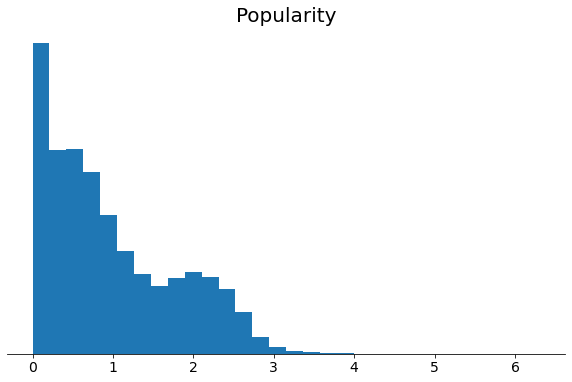

In [385]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(np.log(movies_metadata['popularity']+1), bins = 30);
ax.set_title('Popularity', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
ax.get_yaxis().set_visible(False)

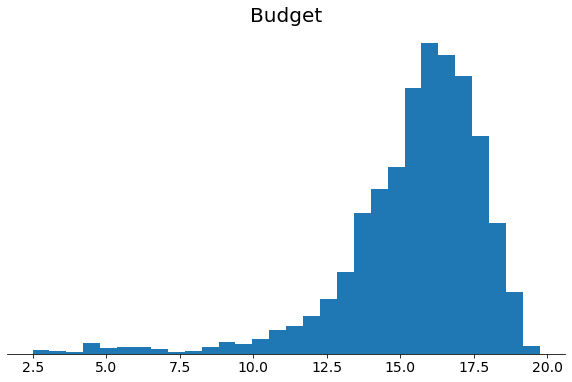

In [386]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(np.log(movies_metadata['budget'][movies_metadata['budget'] > 10]+1), bins = 30);
ax.set_title('Budget', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
ax.get_yaxis().set_visible(False)

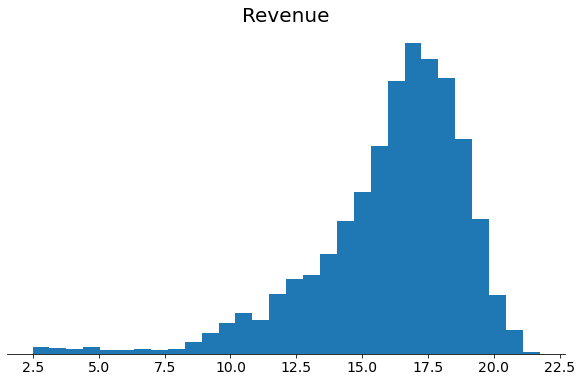

In [387]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(np.log(movies_metadata['revenue'][movies_metadata['revenue'] > 10]+1), bins = 30);
ax.set_title('Revenue', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
ax.get_yaxis().set_visible(False)

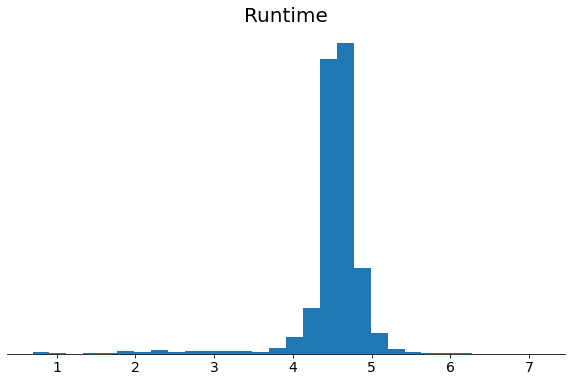

In [389]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(np.log(movies_metadata['runtime'][movies_metadata['runtime'] > 0]+1), bins = 30);
ax.set_title('Runtime', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
ax.get_yaxis().set_visible(False)

[None, None, None]

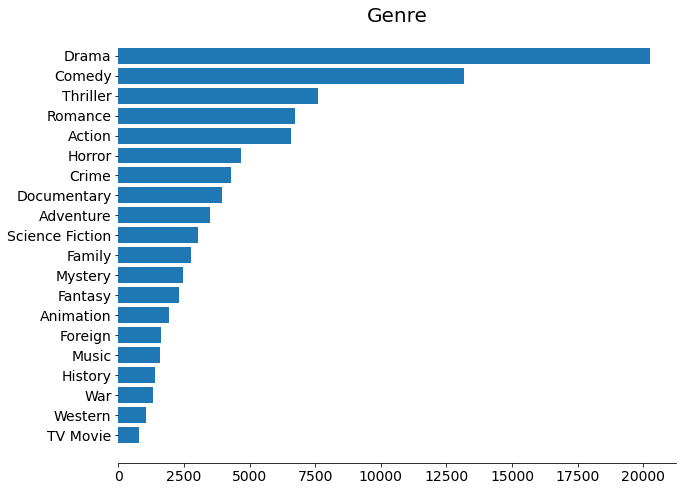

In [403]:
aux = movies_metadata_genres.groupby(by = 'name').count()
aux.columns = ['n', 'm']
aux = aux.sort_values(by = 'n')
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(aux.index, aux.n, );
ax.set_title('Genre', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
# ax.get_yaxis().set_visible(False)

[None, None, None]

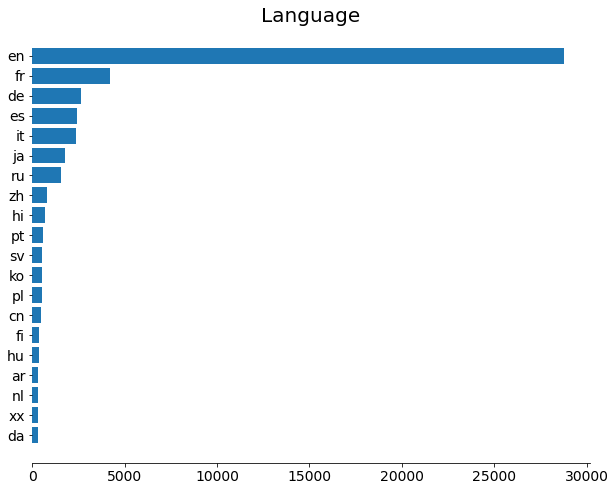

In [419]:
aux = movies_metadata_spoken_languages.groupby(by = 'iso_639_1').count()
aux.columns = ['n', 'm']
aux = aux.sort_values(by = 'n')
aux = aux.tail(20)
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(aux.index, aux.n, );
ax.set_title('Language', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
# ax.get_yaxis().set_visible(False)

[None, None, None]

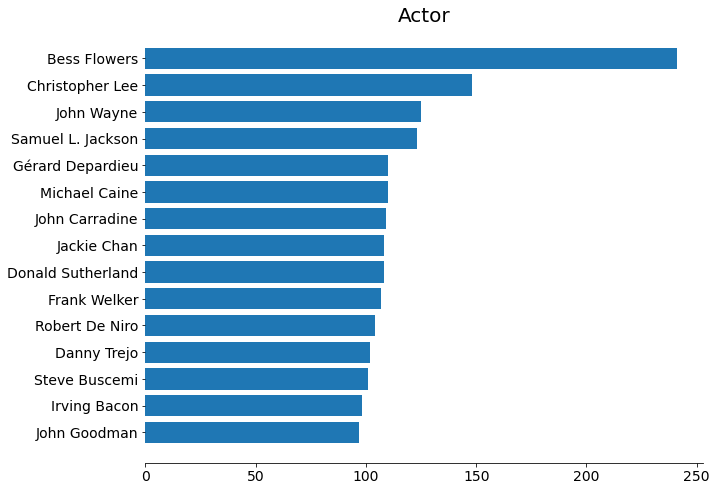

In [433]:
aux = credits_cast.groupby(by = 'name').count()[['id', 'character']]
aux.columns = ['n', 'm']
aux = aux.sort_values(by = 'n')
aux = aux.tail(15)
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(aux.index, aux.n, );
ax.set_title('Actor', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
# ax.get_yaxis().set_visible(False)
# aux

[None, None, None]

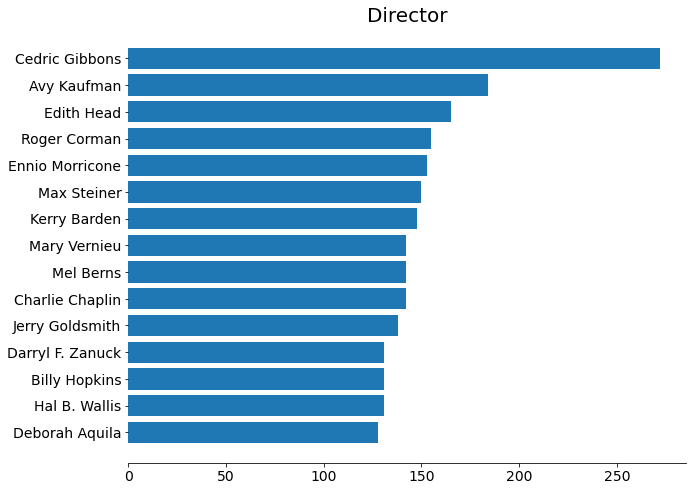

In [431]:
aux = credits_crew.groupby(by = 'name').count()[['id', 'department']]
aux.columns = ['n', 'm']
aux = aux.sort_values(by = 'n')
aux = aux.tail(15)
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(aux.index, aux.n, );
ax.set_title('Director', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']]
# ax.get_yaxis().set_visible(False)
# aux

In [445]:
overview['overview'][0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [440]:
overview['overview'][7831]

"Two FBI agent brothers, Marcus and Kevin Copeland, accidentally foil a drug bust. As punishment, they are forced to escort a pair of socialites to the Hamptons, where they're going to be used as bait for a kidnapper. But when the girls realize the FBI's plan, they refuse to go. Left without options, Marcus and Kevin decide to pose as the sisters, transforming themselves from African-American men into a pair of blonde, white women."

In [442]:
movies_metadata.shape

(45443, 24)

In [443]:
45443/500

90.886

In [444]:
45443/120

378.69166666666666

In [499]:
credits_cast.id.nunique()

206146

In [503]:
credits_crew[credits_crew['job'] == 'Director'].id.nunique()

19894

In [466]:
score_director['name'][score_director['name'].apply(lambda x: isinstance(re.match('Stanley K', x), re.Match))]

11767    Stanley Kubrick
19900     Stanley Kramer
84541       Stanley Kwan
Name: name, dtype: object

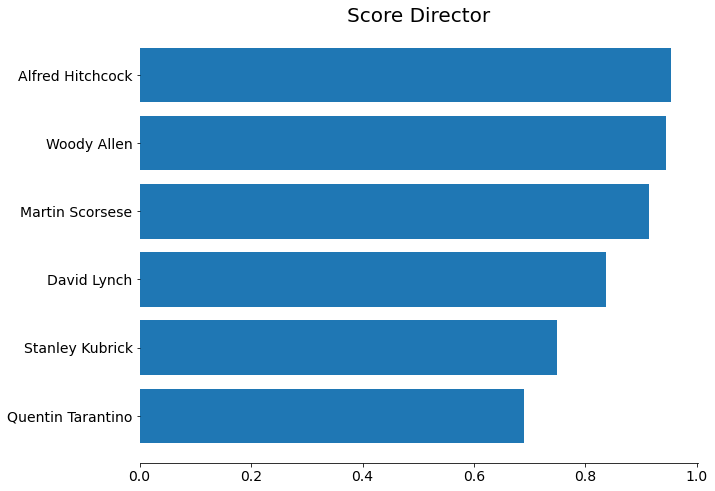

In [496]:
presentacion_directores = [13770, 1367, 379, 403, 3078, 11767]
aux = score_director.loc[presentacion_directores].sort_values(by = 'prob', ascending = True).head(10)[['name', 'prob']]
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(aux.name, aux.prob, );
ax.set_title('Score Director', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']];

In [513]:
score_actor['name'][score_actor['name'].apply(lambda x: isinstance(re.search('Emma S', x), re.Match))]

79052        Emma Samuelsson
85076            Emma Suárez
88367             Emma Samms
99954            Emma Sutton
111313          Emma Stevens
167713           Emma Straub
191770            Emma Stone
244510    Emma Sehested Høeg
248367        Emma Salokoski
259365        Emma Schweiger
278038           Emma Shorey
288080        Emma Stickgold
370921       Emma Stansfield
374460     Rachel Emma Slack
Name: name, dtype: object

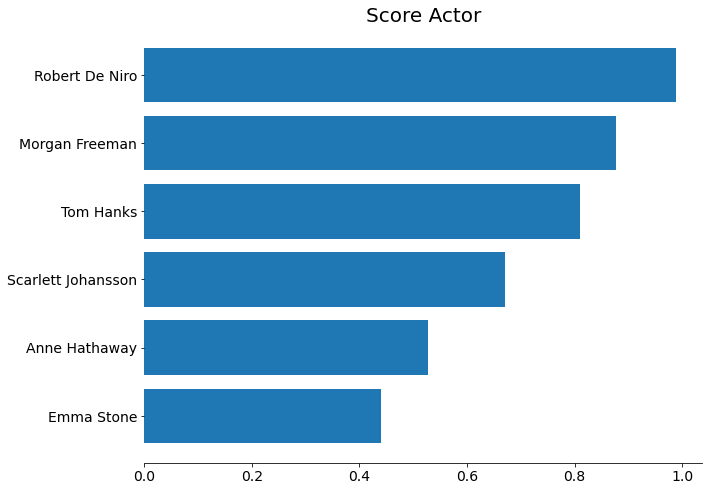

In [514]:
presentacion_actores = [78364, 69, 909, 0, 1962, 191770]
aux = score_actor.loc[presentacion_actores].sort_values(by = 'prob', ascending = True).head(10)[['name', 'prob']]
fig, ax = plt.subplots(figsize = (10,8))
ax.barh(aux.name, aux.prob, );
ax.set_title('Score Actor', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']];

In [511]:
score_actor.sort_values(by = 'prob', ascending = False).head(100).tail(20)

,name,id,actor_score,prob
70,Val Kilmer,5576,13.405557,0.748676
2883,Stanley Tucci,2283,13.377904,0.747131
16335,Barbara Stanwyck,14974,13.377853,0.747129
2759,Sean Connery,738,13.368318,0.746596
2826,Keanu Reeves,6384,13.352428,0.745709
815,Robert Downey Jr.,3223,13.252406,0.740123
462,Sigourney Weaver,10205,13.237310,0.739280
13694,Gary Cooper,4068,13.233175,0.739049
1507,Johnny Depp,85,13.229265,0.738830
33512,Edward G. Robinson,13566,13.200842,0.737243


$$\frac{A \cdot B}{||A||||B||}$$




$$\frac{|A \cap B|}{|A \cup B|}$$

In [662]:
aux

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45438    4.0
45439    9.0
45440    3.8
45441    0.0
45442    0.0
Name: vote_average, Length: 45443, dtype: float64

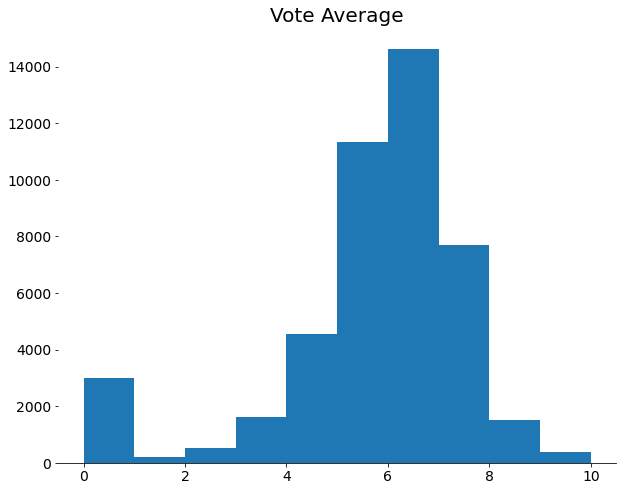

In [664]:
aux = movies_metadata['vote_average']
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(aux);
ax.set_title('Vote Average', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']];

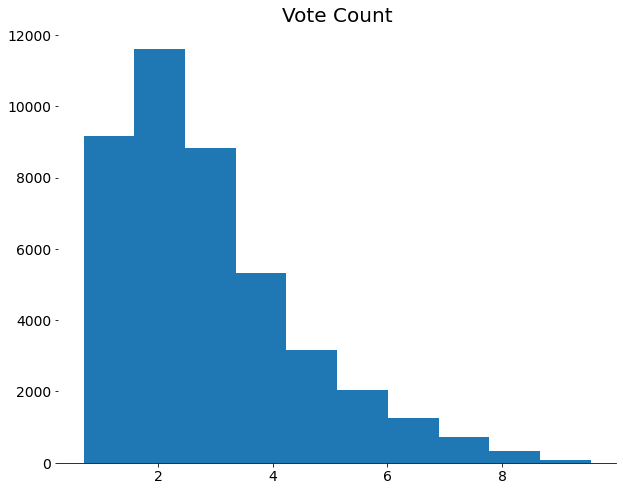

In [668]:
aux = np.log(movies_metadata['vote_count'][movies_metadata['vote_count'] > 0]+1)
fig, ax = plt.subplots(figsize = (10,8))
ax.hist(aux);
ax.set_title('Vote Count', fontsize = 20)
ax.tick_params(labelsize = 14)
[ax.spines[spine].set_visible(False) for spine in ax.spines if spine not in ['bottom']];

In [684]:
n_1 = 20 # K-Means 1
n_2 = 10 # K-Means 2
n_3 = 10 # K-Means 3
n_h = 20 # Hierarchical Clustering
N_ac, M_ac, factor_proba_ac, maximo_actores = 15, 25, 0.8, 4 # Actores
N_dir, M_dir, factor_proba_dir =  30, 50, 1 # Director
n_0, n_f, c = 15000, 10, 0.05  #Coocurrencia Actores
n_ov = 15 # Overview
n_pop = 20 # Pop Metric

In [708]:
p = {'k-means_1': 0.2,
     'k-means_2': 0, 
     'k-means_3': 0,
     'hierarchical':0.2,
     'actores': 0.1,
     'director': 0.5, 
     'coocurrencia_actores': 0.7,
     'overview' : 0.2,
     'pop_metric' :0.2}

In [709]:
idx = 862
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
res = md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó Toy Story:


In [714]:
res.shape

(26, 2)

In [719]:
res.iloc[:14].drop(40353)

,original_title,model
863,Toy Story 2,k-means_1
93456,Despicable Me 2,k-means_1
585,"Monsters, Inc.",k-means_1
35,The Simpsons Movie,k-means_1
863,Toy Story 2,hierarchical
93456,Despicable Me 2,hierarchical
585,"Monsters, Inc.",hierarchical
35,The Simpsons Movie,hierarchical
15344,Toy Story 3,actores
2241,A Bug's Life,director


In [720]:
res.iloc[14:]

,original_title,model
863,Toy Story 2,coocurrencia_actores
213121,Toy Story of Terror!,coocurrencia_actores
256835,Toy Story That Time Forgot,coocurrencia_actores
10193,Toy Story 3,coocurrencia_actores
82424,Small Fry,coocurrencia_actores
77887,Hawaiian Vacation,coocurrencia_actores
130925,Partysaurus Rex,coocurrencia_actores
10193,Toy Story 3,overview
863,Toy Story 2,overview
150540,Inside Out,pop_metric


In [722]:
res[['original_title']].drop_duplicates().drop(40353)

,original_title
863,Toy Story 2
93456,Despicable Me 2
585,"Monsters, Inc."
35,The Simpsons Movie
15344,Toy Story 3
2241,A Bug's Life
10656,Luxo Jr.
10976,Cars
213121,Toy Story of Terror!
256835,Toy Story That Time Forgot


In [739]:
idx = 121
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
res = md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó The Lord of the Rings: The Two Towers:


In [740]:
res

,original_title,model
120,The Lord of the Rings: The Fellowship of the Ring,k-means_1
122,The Lord of the Rings: The Return of the King,k-means_1
102382,The Amazing Spider-Man 2,k-means_1
209112,Batman v Superman: Dawn of Justice,k-means_1
120,The Lord of the Rings: The Fellowship of the Ring,hierarchical
122,The Lord of the Rings: The Return of the King,hierarchical
102382,The Amazing Spider-Man 2,hierarchical
209112,Batman v Superman: Dawn of Justice,hierarchical
10336,Everything is Illuminated,actores
24257,Open Windows,actores


In [733]:
res[['original_title']].drop_duplicates()

,original_title
120,The Lord of the Rings: The Fellowship of the Ring
122,The Lord of the Rings: The Return of the King
102382,The Amazing Spider-Man 2
209112,Batman v Superman: Dawn of Justice
10336,Everything is Illuminated
18213,Happy Feet Two
243,Heavenly Creatures
778,The Frighteners
1196,Braindead
1210,Bad Taste


In [728]:
idx = 18785
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
res = md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó The Hangover:


In [729]:
res[['original_title']].drop_duplicates()

,original_title
38365,Grown Ups
109439,The Hangover Part III
225886,Sex Tape
227159,Horrible Bosses 2
4519,Wet Hot American Summer
3494,Road Trip
6049,Old School
7171,Starsky & Hutch
11309,School for Scoundrels
24438,Did You Hear About the Morgans?


In [734]:
idx = 694
aux = movie_clusters.loc[idx]['original_title']
print(f'Porque te gustó {aux}:')
res = md.modelo_final_v3(idx, p, 
                movie_clusters_1, n_1, # K-Means 1
                movie_clusters_2, n_2, # K-Means 2
                movie_clusters_3, n_3, # K-Means 3
                movie_clusters_h, n_h, # Hierarchical Clustering
                credits_cast, score_actor, movies_metadata, N_ac, M_ac, factor_proba_ac, maximo_actores, # Actores
                credits_crew, score_director, N_dir, M_dir, factor_proba_dir, # Director
                conjunto_actores_df, indices_actores, cosine_sim_actores, conjunto_actores_id, credits, n_0, n_f, c, # Coocurrencia Actores
                overview, indices, cosine_sim, n_ov, # Pop Metric
                movie_clusters_1, pop_metric, n_pop, 
                )

Porque te gustó The Shining:


In [735]:
res[['original_title']].drop_duplicates()

,original_title
9792,The Hills Have Eyes
11351,Jeepers Creepers 2
17692,Jaws 3-D
292280,The Bye Bye Man
1152,One Flew Over the Cuckoo's Nest
732,Dr. Strangelove or: How I Learned to Stop Worr...
897,2001: A Space Odyssey
1138,Paths of Glory
1163,A Clockwork Orange
1179,Full Metal Jacket
